# *1. Importar paquetes y cambiar directorio al actual*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import sqlite3
from scipy.signal import argrelextrema
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import optuna



In [2]:
# Cambiar directorio a carpeta del proyecto
os.chdir('C:/Python/my_projects/dexboost/')
print(os.getcwd())

C:\Python\my_projects\dexboost


# *2. Cargar datasets LP y Boost*

In [3]:
def conectar_db(ruta_db: str):
    try:
        conn = sqlite3.connect(ruta_db)
        print("Conexión exitosa a la base de datos.")
        return conn
    except sqlite3.Error as e:
        print(f"Error al conectar con la base de datos: {e}")
        raise

def cerrar_conexion(conn):
    try:
        if conn:
            conn.close()
            print("Conexión cerrada correctamente.")
    except sqlite3.Error as e:
        print(f"Error al cerrar la conexión: {e}")
        raise

def cargar_tabla(conn, tabla):
    try:
        query = f"SELECT * FROM {tabla}"
        df = pd.read_sql(query, conn)
        return df
    except sqlite3.DatabaseError as e:
        print(f"Error al cargar la tabla '{tabla}': {e}")
        raise

In [4]:
# Conexión a la base de datos
conn = conectar_db('data/main_2025-02-20_19-28-33.db')

# Cargar tabla 'Analysis'
df_boost = cargar_tabla(conn, 'analysis')

# Cerrar conexión

cerrar_conexion(conn)

Conexión exitosa a la base de datos.
Conexión cerrada correctamente.


In [55]:
data_ant = pd.read_csv("data/AnalysisDex3.txt", sep=',')

In [5]:
def process_boost_data(df):
    """
    Optimiza el procesamiento de datos para calcular 'AdjustedBoostAmount' evitando valores negativos.

    Parámetros:
    df (pd.DataFrame): DataFrame que contiene las columnas ['TokenMint', 'Time', 'BoostAmount'].

    Retorna:
    pd.DataFrame: DataFrame con la columna 'AdjustedBoostAmount' corregida.
    """

    # Ordenar por TokenMint y Time
    df = df.sort_values(by=['TokenMint', 'Time'], ascending=True).copy()

    # Crear BoostID basado en el orden de tiempo dentro de cada TokenMint
    df['BoostID'] = df.groupby('TokenMint')['Time'].rank(method='dense', ascending=True).astype(int)

    # Eliminar la columna 'id' si existe
    df.drop(columns='id', errors='ignore', inplace=True)

    # Resetear el índice
    df.reset_index(drop=True, inplace=True)

    # Calcular la diferencia entre BoostAmount y su valor anterior en cada grupo
    df['AdjustedBoostAmount'] = df.groupby('TokenMint')['BoostAmount'].diff()

    # Reemplazar valores negativos y NaN con el valor original de BoostAmount
    mask = df['AdjustedBoostAmount'].isna() | (df['AdjustedBoostAmount'] < 0)
    df.loc[mask, 'AdjustedBoostAmount'] = df.loc[mask, 'BoostAmount']
    # Conversión de tiempos
    df['CreatedAt'] = pd.to_datetime(df['CreatedAt'].astype(str).str[:19])
    # Asegurar que Time es string antes de la conversión
    df['BoostTime'] = pd.to_datetime(df['Time'].astype(str).str[:19])
    df['TokenAge (mins)'] = (df['BoostTime'] - df['CreatedAt']).dt.total_seconds().round(3) / 60

    # Preprocesar StartLiquidity y convertir a USD
    df['StartLiquidityUSD'] = df['StartLiquidity'].apply(
        lambda x: json.loads(x.replace("'", '"')).get('usd', 0.0)
    )

    return df

# Uso de la función
df_analysis = process_boost_data(df_boost)

df_analysis

,Time,CreatedAt,NumberOfSocials,BoostAmount,Markets,TokenName,StartPrice,StartMktCap,StartLiquidity,IsPump,TokenMint,Risks,PriceHistory,BoostID,AdjustedBoostAmount,BoostTime,TokenAge (mins),StartLiquidityUSD
0,2025-02-18T17:42:09.976+01:00,2025-02-18 17:31:01,1,10,"[{""pubkey"":""5rYtxXa916zKwrgof2QvLSkFxRTRgdeY8a...",United States of America Meme,0.264600,2646921174,"{""usd"":457450.03,""base"":862522,""quote"":1398.00...",0,1237CG2ArmADzr7po2LvTNoBar7cSpqjbucWg6FQCRok,"[{""Name"":""High holder correlation"",""Descriptio...","""[{\""price\"":\""0.271685\"",\""time\"":\""2025-02-1...",1,10.0,2025-02-18 17:42:09,11.133333,457450.03
1,2025-02-10T16:15:24.306+01:00,2025-02-10 16:11:16,1,10,"[{""pubkey"":""AtkrY3AztamXV3QrYSSNrt8FQDTZjk8SKa...",Republic of Sol,0.000226,225823,"{""usd"":84535.21,""base"":186394480,""quote"":206.4...",0,12WJtTWYMA99d2XVdGoxmgqV4Qj8pxZhxBdDZ5Q9AbjL,"[{""Name"":""Large Amount of LP Unlocked"",""Descri...","""[{\""price\"":\""0.00021436504988001296\"",\""time...",1,10.0,2025-02-10 16:15:24,4.133333,84535.21
2,2025-02-05T18:40:50.032+01:00,2025-02-05 18:31:07,0,10,"[{""pubkey"":""9JC1dzt1xTHsKPhqc9TJQaftfcJnt9JzBU...",THE SYSADMIN,0.000016,16211,"{""usd"":14616.58,""base"":450357137,""quote"":37.0634}",0,12iY44KgaEyqGkzrRb27F1KXdau97ugq4e5o7R7iSVZa,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.000007182066997247362\"",\""tim...",1,10.0,2025-02-05 18:40:50,9.716667,14616.58
3,2025-02-02T19:57:05.167+01:00,2025-02-02 16:47:31,2,3610,"[{""pubkey"":""AybF7GZXLPaZ2ChriqGJLeR3cFkoWyK24C...",PAIN,0.000560,560352,"{""usd"":93173.86,""base"":83240991,""quote"":234.09...",1,12ifMz54Sq4Ab4RiPezsbDYkY2fo5L3VTabfJJ2ppump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.0005705496891061883\"",\""time\...",1,3610.0,2025-02-02 19:57:05,189.566667,93173.86
4,2025-02-08T11:41:51.289+01:00,2025-02-08 11:08:51,3,50,"[{""pubkey"":""6SBVZLfpSPdyTDUVMd3Ld7ptAD4KCmyKkN...",Doodle Jump,0.000200,199803,"{""usd"":40485.06,""base"":101185707,""quote"":104.5...",0,1332NrDAqXSjFZTVCPgVC4f6RDnygpzPxaVk6Gsfjump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.00021894934908580184\"",\""time...",1,50.0,2025-02-08 11:41:51,33.000000,40485.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5490,2025-02-18T02:02:59.268+01:00,2025-02-18 01:37:59,1,500,"[{""pubkey"":""EPGjnZ2uqgXsBGu4WuZvuxrFyvFRWRMZHj...",Adam22,0.000696,695789,"{""usd"":92025.21,""base"":65871651,""quote"":261.107}",1,zbxtFPCwwLQ77D2UuwMjf9xQ6zDWp1BvCaH6kArpump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.000652872\"",\""time\"":\""2025-0...",1,500.0,2025-02-18 02:02:59,25.000000,92025.21
5491,2025-02-11T10:47:11.779+01:00,2025-02-11 10:45:12,0,10,"[{""pubkey"":""65JmYJoXLHvv4gHjTXhBSu8cTkrBbSZ5vq...",United States Trump Jailed Coin,0.000081,80538,"{""usd"":32700.84,""base"":203395412,""quote"":80.3813}",1,zizzqUreKbQWpbYsQ35fD18WE9KpdSES8oJqvrZpump,"[{""Name"":""Top 10 holders high ownership"",""Desc...","""[{\""price\"":\""0.00008237073226658043\"",\""time...",1,10.0,2025-02-11 10:47:11,1.983333,32700.84
5492,2025-02-06T18:55:06.994+01:00,2025-02-06 00:44:09,2,10,"[{""pubkey"":""FiayaafFKioRfPNr1VbauuBfXPQt1mfoVb...",Doge Derangement Syndrome,0.000006,6359,"{""usd"":9332,""base"":732975249,""quote"":24.4472}",1,zjfHtUJYAdzzaytaZzGTjodGMjHK1ELLHUEmd6Dpump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.0000060188959005966695\"",\""ti...",1,10.0,2025-02-06 18:55:06,1090.950000,9332.00
5493,2025-02-19T05:39:49.092+01:00,2025-02-19 04:54:54,3,10,"[{""pubkey"":""CXgcuECqdaBpvJWH5cwEir9Y5FY9SKTjhG...",Infinite Money Glitch,0.000182,182331,"{""usd"":48172.16,""base"":132282106,""quote"":145.4...",0,znv3FZt2HFAvzYf5LxzVyryh3mBXWuTRRng25gEZAjh,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.000177037\"",\""time\"":\""2025-0...",1,10.0,2025-02-19 05:39:49,44.916667,4

In [ ]:
from datetime import datetime as dt

def cut_max_days(df, max_days):
    """
    Filters DataFrame to only include rows where CreatedAt is within max_days from now.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'CreatedAt' column
        max_days (int): Maximum number of days to include before now
        
    Returns:
        pd.DataFrame: Filtered DataFrame
    """
    df = df.copy()
    
    # Convert CreatedAt to datetime if it's not already
    df['CreatedAt'] = pd.to_datetime(df['CreatedAt'])
    
    # Calculate cutoff date
    cutoff_date = pd.Timestamp.now() - pd.Timedelta(days=max_days)
    
    # Filter rows where CreatedAt is after the cutoff date
    result = df[df['CreatedAt'] > cutoff_date]
    
    return result

# Test the function with 4 days
df_with_days_until_now = cut_max_days(df_analysis, 4)
print(f"Original rows: {len(df_analysis)}")
print(f"Filtered rows: {len(df_with_days_until_now)}")
df_with_days_until_now

Original rows: 5495
Filtered rows: 769


,Time,CreatedAt,NumberOfSocials,BoostAmount,Markets,TokenName,StartPrice,StartMktCap,StartLiquidity,IsPump,TokenMint,Risks,PriceHistory,BoostID,AdjustedBoostAmount,BoostTime,TokenAge (mins),StartLiquidityUSD
0,2025-02-18T17:42:09.976+01:00,2025-02-18 17:31:01,1,10,"[{""pubkey"":""5rYtxXa916zKwrgof2QvLSkFxRTRgdeY8a...",United States of America Meme,0.264600,2646921174,"{""usd"":457450.03,""base"":862522,""quote"":1398.00...",0,1237CG2ArmADzr7po2LvTNoBar7cSpqjbucWg6FQCRok,"[{""Name"":""High holder correlation"",""Descriptio...","""[{\""price\"":\""0.271685\"",\""time\"":\""2025-02-1...",1,10.0,2025-02-18 17:42:09,11.133333,457450.03
8,2025-02-17T17:45:24.616+01:00,2025-02-17 17:21:49,2,1500,"[{""pubkey"":""6E9PzPR49Th8ULtkamBDLL2pi2tVLhJwrN...",GROK 3,0.000487,487295,"{""usd"":76285.19,""base"":78179672,""quote"":214.098}",1,13Dcce9KRt7gRkwDKQjfFHAUqvDmdsBhAuT6v1Eopump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.000528386\"",\""time\"":\""2025-0...",1,1500.0,2025-02-17 17:45:24,23.583333,76285.19
9,2025-02-17T19:10:46.337+01:00,2025-02-17 17:21:49,2,2000,"[{""pubkey"":""6E9PzPR49Th8ULtkamBDLL2pi2tVLhJwrN...",GROK 3,0.000539,539125,"{""usd"":85372.97,""base"":79047522,""quote"":241.4801}",1,13Dcce9KRt7gRkwDKQjfFHAUqvDmdsBhAuT6v1Eopump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.000560268\"",\""time\"":\""2025-0...",2,500.0,2025-02-17 19:10:46,108.950000,85372.97
10,2025-02-17T19:19:05.952+01:00,2025-02-17 17:21:49,2,2500,"[{""pubkey"":""6E9PzPR49Th8ULtkamBDLL2pi2tVLhJwrN...",GROK 3,0.000528,528451,"{""usd"":85354.7,""base"":80835866,""quote"":239.03619}",1,13Dcce9KRt7gRkwDKQjfFHAUqvDmdsBhAuT6v1Eopump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.000515626\"",\""time\"":\""2025-0...",3,500.0,2025-02-17 19:19:05,117.266667,85354.70
11,2025-02-17T20:09:05.579+01:00,2025-02-17 17:21:49,2,3000,"[{""pubkey"":""6E9PzPR49Th8ULtkamBDLL2pi2tVLhJwrN...",GROK 3,0.000522,522107,"{""usd"":87319.36,""base"":83622804,""quote"":247.7405}",1,13Dcce9KRt7gRkwDKQjfFHAUqvDmdsBhAuT6v1Eopump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.000515643\"",\""time\"":\""2025-0...",4,500.0,2025-02-17 20:09:05,167.266667,87319.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5488,2025-02-17T15:25:56.897+01:00,2025-02-17 15:11:56,3,50,"[{""pubkey"":""Dd2LijEkvCiVBKxDrGpXVSTYGHjxZn9h98...",FINE,0.000098,97564,"{""usd"":35110.26,""base"":179731970,""quote"":94.6315}",1,zZ7DdNfZhjZffVrr38K56q3PCRgqgiQUnm91rt6pump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.000101496\"",\""time\"":\""2025-0...",1,50.0,2025-02-17 15:25:56,14.000000,35110.26
5489,2025-02-17T18:39:39.000+01:00,2025-02-17 15:11:56,3,150,"[{""pubkey"":""Dd2LijEkvCiVBKxDrGpXVSTYGHjxZn9h98...",FINE,0.000040,40171,"{""usd"":22437.05,""base"":280725247,""quote"":62.6049}",1,zZ7DdNfZhjZffVrr38K56q3PCRgqgiQUnm91rt6pump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.000032432\"",\""time\"":\""2025-0...",2,100.0,2025-02-17 18:39:39,207.716667,22437.05
5490,2025-02-18T02:02:59.268+01:00,2025-02-18 01:37:59,1,500,"[{""pubkey"":""EPGjnZ2uqgXsBGu4WuZvuxrFyvFRWRMZHj...",Adam22,0.000696,695789,"{""usd"":92025.21,""base"":65871651,""quote"":261.107}",1,zbxtFPCwwLQ77D2UuwMjf9xQ6zDWp1BvCaH6kArpump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.000652872\"",\""time\"":\""2025-0...",1,500.0,2025-02-18 02:02:59,25.000000,92025.21
5493,2025-02-19T05:39:49.092+01:00,2025-02-19 04:54:54,3,10,"[{""pubkey"":""CXgcuECqdaBpvJWH5cwEir9Y5FY9SKTjhG...",Infinite Money Glitch,0.000182,182331,"{""usd"":48172.16,""base"":132282106,""quote"":145.4...",0,znv3FZt2HFAvzYf5LxzVyryh3mBXWuTRRng25gEZAjh,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.000177037\"",\""time\"":\""2025-0...",1,10.0,2025-02-19 05:39:49,44.916667,48172.16


In [14]:
df_with_days_until_now = df_with_days_until_now[(df_with_days_until_now['TokenAge (mins)'] < 10) & \
          (df_with_days_until_now['StartMktCap'] > 100000) & \
          (df_with_days_until_now['StartLiquidityUSD'] > 40000) & \
          (df_with_days_until_now['AdjustedBoostAmount'] >= 200) & \
          (df_with_days_until_now['BoostID'] == 1)]

df_with_days_until_now

,Time,CreatedAt,NumberOfSocials,BoostAmount,Markets,TokenName,StartPrice,StartMktCap,StartLiquidity,IsPump,TokenMint,Risks,PriceHistory,BoostID,AdjustedBoostAmount,BoostTime,TokenAge (mins),StartLiquidityUSD
520,2025-02-20T09:57:28.133+01:00,2025-02-20 09:48:55,1,550,"[{""pubkey"":""XHeMNc39siau4zE11B1QN531yAdzc3hWXN...",Jail Zelensky,0.000244,244346,"{""usd"":52617.92,""base"":108348739,""quote"":151.6...",1,3hWSpeMr3k6aqrPthpEkjUi8E6pqRrt38hK6Usc7pump,"[{""Name"":""Top 10 holders high ownership"",""Desc...","""[{\""price\"":\""0.000249304\"",\""time\"":\""2025-0...",1,550.0,2025-02-20 09:57:28,8.550000,52617.92
564,2025-02-17T13:20:22.179+01:00,2025-02-17 13:12:09,2,500,"[{""pubkey"":""Ei83uY8c2b1adt76cbsre3HdUzc9TYySti...",DOGE state,0.587300,587350490,"{""usd"":2669394.61,""base"":2275231,""quote"":7204....",1,3oFmz2acjkbdHuRpAdHeWtBdUYhav4v1YRHJxLybpump,"[{""Name"":""High holder correlation"",""Descriptio...","""[{\""price\"":\""0.602581\"",\""time\"":\""2025-02-1...",1,500.0,2025-02-17 13:20:22,8.216667,2669394.61
2242,2025-02-18T13:15:24.715+01:00,2025-02-18 13:07:21,1,500,"[{""pubkey"":""H6svkdBbLfwzr3goKBJpuAVvxD5ivhcabW...",FORT KNOX,0.005681,5681412,"{""usd"":253726.61,""base"":22296889,""quote"":749.1...",1,9MA94ps7nX1o7vvwVpjZrjbPC6mDTzbPCFeoefc5pump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.00575351\"",\""time\"":\""2025-02...",1,500.0,2025-02-18 13:15:24,8.050000,253726.61
2556,2025-02-17T17:22:35.735+01:00,2025-02-17 17:19:27,0,500,"[{""pubkey"":""8XTcE35CG6GJazTM7v4srDR91GiojkrMX4...",Crazy Frog,0.000287,287429,"{""usd"":58249.06,""base"":101328683,""quote"":162.126}",1,AVrNeiU54AdXxvpHXkjrMZfpM1v22ZYU94urYH6cpump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.000011340637474910015\"",\""tim...",1,500.0,2025-02-17 17:22:35,3.133333,58249.06
3532,2025-02-20T17:58:46.297+01:00,2025-02-20 17:55:46,0,500,"[{""pubkey"":""7WZTak147ZGNntaMSmAyAwVTF7jVrCSroB...",CRYPTO BRO,0.000404,404441,"{""usd"":67692.29,""base"":83769799,""quote"":196.6065}",1,DmvLQMMU5SnXnioVxgsq7EPqyc727AUDSZ3WAKd2pump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.000435784\"",\""time\"":\""2025-0...",1,500.0,2025-02-20 17:58:46,3.000000,67692.29
4391,2025-02-17T11:10:22.090+01:00,2025-02-17 11:05:46,1,500,"[{""pubkey"":""8XpbX7BMi2dn6hpphaYFz9sENb6teKgvGf...",Department Of State,0.199900,199927609,"{""usd"":1558730.18,""base"":3903100,""quote"":4199....",0,GgMfHd4VHR85f6wScvWBx1GSJS58rD55BXx5mo1XZfiw,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.203924\"",\""time\"":\""2025-02-1...",1,500.0,2025-02-17 11:10:22,4.600000,1558730.18
4450,2025-02-17T00:30:58.024+01:00,2025-02-17 00:21:00,2,600,"[{""pubkey"":""A8YBPPaZAoYZtKMqjLZExdTocZpXTkHJPL...",Grok 4,0.000139,138593,"{""usd"":41569.76,""base"":150158713,""quote"":110.1...",1,GpDzQVu8gTLfnTEJdsbWiLBJo8SduQtkGpJfmEJnpump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.000131939\"",\""time\"":\""2025-0...",1,600.0,2025-02-17 00:30:58,9.966667,41569.76
4568,2025-02-18T17:48:35.480+01:00,2025-02-18 17:42:19,0,500,"[{""pubkey"":""84KGo4Frsm4i6yXNmdKW7iYQA6CBWGFufr...",FTX,0.000232,231634,"{""usd"":49968.46,""base"":107453828,""quote"":152.8...",1,HCz7kboCUYCGEs4UBepSzrkNLTu2VgNkFZkze4Aepump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.00023409\"",\""time\"":\""2025-02...",1,500.0,2025-02-18 17:48:35,6.266667,49968.46
4757,2025-02-17T22:50:45.434+01:00,2025-02-17 22:45:04,1,500,"[{""pubkey"":""DbrwAgA926KgDxHD6Si7dxrVDsMsJWFEDW...",Sam Bankman-Milei,0.422300,422353576,"{""usd"":2234920.84,""base"":2642529,""quote"":6208....",1,HnYJeoxoTrx9YZUrSpXaPzowQLxViKN4iNpNvzSppump,"[{""Name"":""High holder correlation"",""Descriptio...","""[{\""price\"":\""0.437139\"",\""time\"":\""2025-02-1...",1,500.0,2025-02-17 22:50:45,5.683333,2234920.84
5040,2025-02-19T18:40:13.380+01:00,2025-02-19 18:33:45,3,500,"[{""pubkey"

# *3. Análisis completo Boost Data*

## *3.1. Parseando PriceHistory y calculando variaciones de precio*

### *3.1.1. Funciones*

In [57]:
def parse_to_flat_format_optimized_with_boundaries(df):
    df = df.copy()
    
    # Calcular TotalScore a partir de la columna 'Risks'
    def compute_total_risk_score(risks):
        try:
            if pd.isna(risks) or not risks:
                return 0
            if isinstance(risks, str):
                if "no risks found" in risks.lower():
                    return 0
                try:
                    risks_list = json.loads(risks)
                except json.JSONDecodeError:
                    risks_list = json.loads(risks.replace("'", '"'))
            else:
                risks_list = risks
            return sum(r.get("Score", 0) for r in risks_list)
        except Exception:
            return 0

    # Si la columna 'Risks' existe, calculamos TotalScore; si no, se asigna 0
    if 'Risks' in df.columns:
        df['TotalScore'] = df['Risks'].apply(compute_total_risk_score)
    else:
        df['TotalScore'] = 0

    # Preprocesar StartLiquidity y convertir a USD
    df['StartLiquidityUSD'] = df['StartLiquidity'].apply(
        lambda x: json.loads(x.replace("'", '"')).get('usd', 0.0)
    )
    
    # Parsear PriceHistory: corregir formato y convertir a lista de diccionarios
    df['PriceHistory'] = (
        df['PriceHistory']
        .astype(str)
        .str.replace(r'\\"', '"', regex=True)
        .str.strip('"')
        .apply(json.loads)
    )
    
    # Ordenar por TokenMint y BoostTime para asegurar el orden cronológico de los boosts
    df = df.sort_values(by=['TokenMint', 'BoostTime'])
    
    # Calcular NextBoostTime usando groupby y shift sobre BoostTime
    df['NextBoostTime'] = df.groupby('TokenMint')['BoostTime'].shift(-1)
    df['NextBoostTime'] = df['NextBoostTime'].fillna(pd.Timestamp.max)
    
    # Explode de PriceHistory para pasar a filas individuales
    exploded = df.explode('PriceHistory')
    exploded = exploded[exploded['PriceHistory'].notnull()]
    
    # Normalizar la información de PriceHistory (extraer 'time' y 'price', entre otros si los hubiera)
    price_data = pd.json_normalize(exploded['PriceHistory'])
    
    # Reiniciar índices y concatenar la información normalizada
    exploded = exploded.reset_index(drop=True)
    price_data = price_data.reset_index(drop=True)
    flat_df = pd.concat([exploded, price_data], axis=1)
    
    # Convertir de forma vectorizada la columna de tiempo extraída (la de PriceHistory)
    flat_df['PriceTime'] = pd.to_datetime(flat_df['time'].astype(str).str[:19])
    
    # Registrar el nuevo boost en otra columna en vez de filtrar los datos
    flat_df['NewBoostAt'] = flat_df.groupby('TokenMint')['BoostTime'].shift(-1)
    
    # Copiar datos estáticos en la nueva fila de NewBoostAt
    static_cols = ['StartMktCap', 'AdjustedBoostAmount', 'StartLiquidityUSD', 'IsPump', 'NumberOfSocials']
    for col in static_cols:
        flat_df[col] = flat_df.groupby('TokenMint')[col].ffill()
    
    # Calcular métricas temporales
    flat_df['TimeSinceBoostStart'] = (
        flat_df.groupby(['TokenMint', 'BoostTime'])['PriceTime']
        .transform(lambda x: (x - x.min()).dt.total_seconds().round(3))
    )
    
    # Renombrar columnas: por ejemplo, 'price' a 'Price'
    flat_df = flat_df.rename(columns={'price': 'Price', 'time': 'OriginalPriceTime'})

    # Asegurarse de que 'Price' y 'StartPrice' sean numéricos
    flat_df['Price'] = pd.to_numeric(flat_df['Price'], errors='coerce')
    flat_df['StartPrice'] = pd.to_numeric(flat_df['StartPrice'], errors='coerce')
    
    # Agregar columna de PriceVariation respecto a StartPrice (variación en forma decimal)
    flat_df['PriceVariation'] = ((flat_df['Price'] - flat_df['StartPrice']) / flat_df['StartPrice']) * 100
    
    # Función para determinar la decisión según las condiciones indicadas
    def determine_decision(group):
        # Si no hay valores válidos de PriceVariation, retornamos "Hold"
        if group['PriceVariation'].dropna().empty:
            return "Hold"
        
        idx_peak = group['PriceVariation'].idxmax()
        # Si idx_peak es NaN, retornamos "Hold"
        if pd.isna(idx_peak):
            return "Hold"
        
        peak_variation = group.loc[idx_peak, 'PriceVariation']
        peak_time = group.loc[idx_peak, 'PriceTime']
        
        # 1. Caída fuerte (>20% en 60s o menos) → SL (Rugpull)
        if ((group['PriceVariation'] <= -0.20) & (group['TimeSinceBoostStart'] <= 60)).any():
            return "SL (Rugpull)"
        
        # 2. Subida fuerte (>50%) y caída rápida después del pico → TP (Peak Sell)
        if peak_variation > 0.50:
            # Seleccionar transacciones posteriores al pico
            post_peak = group[group['PriceTime'] > peak_time]
            if not post_peak.empty:
                first_post_peak = post_peak.iloc[0]
                time_diff = (first_post_peak['PriceTime'] - peak_time).total_seconds()
                if (peak_variation - first_post_peak['PriceVariation'] >= 0.10) and (time_diff <= 60):
                    return "TP (Peak Sell)"
        
        # 3. Si el resultado final es negativo sin activar SL → SL (Late Exit)
        final_row = group.iloc[-1]
        if final_row['PriceVariation'] < 0:
            return "SL (Late Exit)"
        
        # 4. En caso contrario, se mantiene "Hold"
        return "Hold"
    
    # Aplicar la función de decisión a cada boost (agrupado por TokenMint y BoostTime)
    decisions = (
        flat_df.groupby(['TokenMint', 'BoostTime'])
        .apply(determine_decision)
        .reset_index()
        .rename(columns={0: 'Decision'})
    )
    
    # Incorporar la decisión en el dataframe final
    flat_df = flat_df.merge(decisions, on=['TokenMint', 'BoostTime'], how='left')
    
    # Seleccionar columnas finales y convertir tipos de datos
    cols = [
        'TokenMint', 'BoostTime', 'TokenAge (mins)', 'BoostID', 
        'AdjustedBoostAmount', 'NumberOfSocials', 'IsPump', 'StartMktCap', 
        'StartLiquidityUSD', 'TotalScore', 'StartPrice', 'Price', 'PriceTime', 
        'TimeSinceBoostStart', 'NewBoostAt', 'PriceVariation', 'Decision'
    ]
    
    dtypes = {
        'AdjustedBoostAmount': 'int32',
        'StartMktCap': 'int64',
        'StartPrice': 'float32',
        'StartLiquidityUSD': 'int64',
        'TotalScore': 'int32',
        'Price': 'float32',
        'TokenAge (mins)': 'float32',
        'TimeSinceBoostStart': 'float32',
        'NumberOfSocials': 'int8',
        'IsPump': 'bool',
        'PriceVariation': 'float32'
    }
    
    return flat_df[cols].astype(dtypes).reset_index(drop=True)




def prepare_and_simulate_boosts_with_metrics(data, stop_loss=-10, take_profit=20, max_time_diff=600, slippage=0.02):
    # Copia del dataset
    df = data.copy()

    # Asegurar que las columnas de tiempo estén en formato datetime
    df['BoostTime'] = pd.to_datetime(df['BoostTime'])
    df['PriceTime'] = pd.to_datetime(df['PriceTime'])

    # Paso 1: Identificar Boosts únicos
    df = df.sort_values(by=['TokenMint', 'BoostID']).reset_index(drop=True)

    # Paso 2: Simular métricas para cada boost
    results = []
    grouped = df.groupby(['TokenMint', 'BoostID', 'BoostTime'])
    for (tokenmint, boost_id, boost_time), group in grouped:
        group = group.dropna(subset=['Price']).query('Price > 0').sort_values('PriceTime')
        if group.empty:
            continue
        
        # Get metadata for this specific boost
        ispump = group.iloc[0]['IsPump']
        num_socials = group.iloc[0]['NumberOfSocials']
        boost_amount = group.iloc[0]['AdjustedBoostAmount']

        # Instante y precio de entrada
        entry_time = group.iloc[0]['BoostTime']
        entry_price = group.iloc[0]['Price']

        # Aplicar slippage al precio
        group['adjusted_price'] = group['Price'] * (1 - slippage)

        # Filtrar hasta max_time_diff segundos después del boost
        cutoff_time = entry_time + pd.Timedelta(seconds=max_time_diff)
        group_interval = group[group['PriceTime'] <= cutoff_time].copy()
        if group_interval.empty:
            continue

        # Calcular máximos y mínimos dentro del intervalo
        max_price = group_interval['adjusted_price'].max()
        min_price = group_interval['adjusted_price'].min()

        # Tiempo hasta el máximo y el mínimo
        idx_max = group_interval['adjusted_price'].idxmax()
        time_max = group_interval.loc[idx_max, 'PriceTime']
        max_time_diff_sec = round((time_max - entry_time).total_seconds(), 1)

        idx_min = group_interval['adjusted_price'].idxmin()
        time_min = group_interval.loc[idx_min, 'PriceTime']
        min_time_diff_sec = round((time_min - entry_time).total_seconds(), 1)

        # Variaciones porcentuales
        max_variation = ((max_price - entry_price) / entry_price) * 100
        min_variation = ((min_price - entry_price) / entry_price) * 100

        # Simulación de salida (TP, SL o corte)
        trigger_signal = "None"
        trigger_time = cutoff_time
        exit_price = group_interval.iloc[-1]['adjusted_price']
        for _, row in group_interval.iterrows():
            variation = ((row['adjusted_price'] - entry_price) / entry_price) * 100
            if variation >= take_profit:
                trigger_signal = "TP"
                trigger_time = row['PriceTime']
                exit_price = row['adjusted_price']
                break
            elif variation <= stop_loss:
                trigger_signal = "SL"
                trigger_time = row['PriceTime']
                exit_price = row['adjusted_price']
                break

        trigger_time_diff_sec = round((trigger_time - entry_time).total_seconds(), 2)
        final_variation = ((exit_price - entry_price) / entry_price) * 100

       # Cálculo de slope_metric corregido con porcentaje
        slope_window_seconds = 30  # Intervalo de tiempo fijo después del máximo o mínimo

        if max_price > entry_price:
            # Filtrar datos 30 segundos después del máximo
            post_max_time = time_max + pd.Timedelta(seconds=slope_window_seconds)
            post_max_data = group_interval[(group_interval['PriceTime'] > time_max) & (group_interval['PriceTime'] <= post_max_time)]

            if not post_max_data.empty:
                final_price_post_max = post_max_data.iloc[-1]['adjusted_price']
                delta_time = (post_max_data.iloc[-1]['PriceTime'] - time_max).total_seconds()
                slope_metric = ((final_price_post_max - max_price) / max_price / delta_time) * 100 if delta_time != 0 else 0
            else:
                slope_metric = "No data after max"

        elif min_price < entry_price:
            # Filtrar datos 30 segundos después del mínimo
            post_min_time = time_min + pd.Timedelta(seconds=slope_window_seconds)
            post_min_data = group_interval[(group_interval['PriceTime'] > time_min) & (group_interval['PriceTime'] <= post_min_time)]

            if not post_min_data.empty:
                final_price_post_min = post_min_data.iloc[-1]['adjusted_price']
                delta_time = (post_min_data.iloc[-1]['PriceTime'] - time_min).total_seconds()
                slope_metric = ((final_price_post_min - min_price) / min_price / delta_time) * 100 if delta_time != 0 else 0
            else:
                slope_metric = "No data after min"

        else:
            slope_metric = "No max or min detected"


        results.append({
            'TokenMint': tokenmint,
            'BoostID': boost_id,
            'AdjustedBoostAmount': boost_amount,
            'IsPump': ispump,
            'NumberOfSocials': num_socials,
            'StartMktCap': group.iloc[0]['StartMktCap'],
            'StartLiquidityUSD': group.iloc[0]['StartLiquidityUSD'],
            'max_price_variation (%)': max_variation,
            'min_price_variation (%)': min_variation,
            'final_variation (%)': final_variation,
            'trigger_signal': trigger_signal,
            'trigger_time_diff (s)': trigger_time_diff_sec,
            'max_price_time_diff (s)': max_time_diff_sec,
            'min_price_time_diff (s)': min_time_diff_sec,
            'slope_metric': slope_metric,
            'TokenAge (mins)': group.iloc[0]['TokenAge (mins)'],
            'BoostTime': boost_time
        })

    # Crear DataFrame final y ordenar columnas
    final_df = pd.DataFrame(results)
    final_df = final_df[
        ['TokenMint', 'BoostID', 'AdjustedBoostAmount', 'TokenAge (mins)', 'BoostTime', 'IsPump', 'NumberOfSocials',
         'StartMktCap', 'StartLiquidityUSD', 'max_price_variation (%)', 'min_price_variation (%)',
         'final_variation (%)', 'trigger_signal', 'trigger_time_diff (s)', 'max_price_time_diff (s)',
         'min_price_time_diff (s)', 'slope_metric']
    ]
    final_df[['trigger_time_diff (s)', 'max_price_time_diff (s)', 'min_price_time_diff (s)']] = final_df[['trigger_time_diff (s)', 'max_price_time_diff (s)', 'min_price_time_diff (s)']].astype(int)


    return final_df


### *3.1.2. Price evolution*

In [ ]:
price_evo_boost = parse_to_flat_format_optimized_with_boundaries(df_analysis)

price_evo_boost_filtered = price_evo_boost[(price_evo_boost['TokenAge (mins)'] < 10) & \
              (price_evo_boost['StartMktCap'] >= 100000) & \
              (price_evo_boost['StartLiquidityUSD'] >= 40000) & \
              (price_evo_boost['AdjustedBoostAmount'] > 190) & \
              (price_evo_boost['TotalScore'] <= 1000) & \
              (price_evo_boost['BoostID'] == 1)]


price_evo_boost_filtered.reset_index(drop=True, inplace=True)
price_evo_boost_filtered.sort_values(by=['BoostTime', 'TokenMint'], inplace=True)

price_evo_boost_filtered

C:\Users\Laú\AppData\Local\Temp\ipykernel_22164\2216473275.py:127: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(determine_decision)
C:\Users\Laú\AppData\Local\Temp\ipykernel_22164\2432325670.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_evo_boost_filtered.sort_values(by=['BoostTime', 'TokenMint'], inplace=True)


,TokenMint,BoostTime,TokenAge (mins),BoostID,AdjustedBoostAmount,NumberOfSocials,IsPump,StartMktCap,StartLiquidityUSD,TotalScore,StartPrice,Price,PriceTime,TimeSinceBoostStart,NewBoostAt,PriceVariation,Decision
15127,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,2025-02-03 19:49:55,6.316667,1,500,3,True,255242,59419,400,0.000255,0.000300,2025-02-03 19:49:58,0.0,2025-02-03 19:49:55,17.442945,Hold
15128,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,2025-02-03 19:49:55,6.316667,1,500,3,True,255242,59419,400,0.000255,0.000308,2025-02-03 19:50:08,10.0,2025-02-03 19:49:55,20.881910,Hold
15129,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,2025-02-03 19:49:55,6.316667,1,500,3,True,255242,59419,400,0.000255,0.000316,2025-02-03 19:50:19,21.0,2025-02-03 19:49:55,23.814455,Hold
15130,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,2025-02-03 19:49:55,6.316667,1,500,3,True,255242,59419,400,0.000255,0.000336,2025-02-03 19:50:29,31.0,2025-02-03 19:49:55,31.524092,Hold
15131,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,2025-02-03 19:49:55,6.316667,1,500,3,True,255242,59419,400,0.000255,0.000331,2025-02-03 19:50:39,41.0,2025-02-03 19:49:55,29.692171,Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4719,9Ss13eKoTYJGVQpNREEriNwJkkiDNBrnXjADUgPpump,2025-02-14 22:02:55,5.000000,1,500,0,True,145980,44004,400,0.000146,0.000272,2025-02-14 22:38:37,2138.0,2025-02-14 22:02:55,86.328506,TP (Peak Sell)
4720,9Ss13eKoTYJGVQpNREEriNwJkkiDNBrnXjADUgPpump,2025-02-14 22:02:55,5.000000,1,500,0,True,145980,44004,400,0.000146,0.000281,2025-02-14 22:38:47,2148.0,2025-02-14 22:02:55,92.616402,TP (Peak Sell)
4721,9Ss13eKoTYJGVQpNREEriNwJkkiDNBrnXjADUgPpump,2025-02-14 22:02:55,5.000000,1,500,0,True,145980,44004,400,0.000146,0.000278,2025-02-14 22:38:57,2158.0,2025-02-14 22:02:55,90.634476,TP (Peak Sell)
4722,9Ss13eKoTYJGVQpNREEriNwJkkiDNBrnXjADUgPpump,2025-02-14 22:02:55,5.000000,1,500,0,True,145980,44004,400,0.000146,0.000279,2025-02-14 22:39:08,2169.0,2025-02-14 22:02:55,91.505501,TP (Peak Sell)


### 3.1.3. Optimizando estrategia

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.027907848358154297s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19619039370119726s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12345314025878906s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    0.6s
[Parallel(n_jo

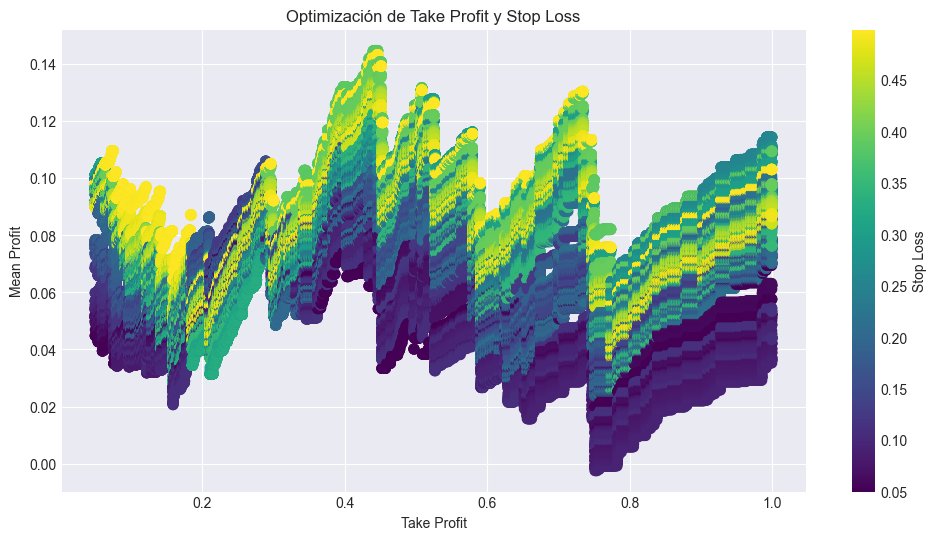


Mejores Resultados:
take_profit      0.508000
stop_loss        0.489000
mean_profit      0.130883
median_profit    0.506936
win_rate         0.696970
std_dev          0.549962
score            0.356916
Name: 206539, dtype: float64


In [137]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# Cargar dataset
df = price_evo_boost_filtered.copy()

# Preprocesar DataFrame
df['PriceTime'] = pd.to_datetime(df['PriceTime'], errors='coerce')
df = df.dropna(subset=['Price', 'PriceTime'])
df = df[df['Price'] > 0]
df.sort_values(['TokenMint', 'PriceTime'], inplace=True)

# Filtrar tokens con al menos 3 precios
valid_tokens = df['TokenMint'].value_counts()[df['TokenMint'].value_counts() >= 3].index
df = df[df['TokenMint'].isin(valid_tokens)]

# Crear arrays de precios por token
token_arrays = []
token_names = []

for token_id, group in df.groupby('TokenMint'):
    arr = group['Price'].to_numpy(np.float64)
    token_arrays.append(arr)
    token_names.append(token_id)


def simulate_trade_tp_sl(price_series, take_profit, stop_loss, fee=0.001):
    """
    Simula una estrategia de trading simple con Take Profit y Stop Loss.
    """
    buy_price = price_series[0]
    tokens = 1.0 - fee  # Compra inicial con comisión

    for current_price in price_series[1:]:
        profit_pct = (current_price / buy_price) - 1.0
        if profit_pct >= take_profit:
            return ((tokens * current_price * (1 - fee)) / buy_price) - 1.0
        if profit_pct <= -stop_loss:
            return ((tokens * current_price * (1 - fee)) / buy_price) - 1.0

    # Si no se ejecuta TP ni SL, vendemos al último precio
    return ((tokens * price_series[-1] * (1 - fee)) / buy_price) - 1.0


def simulate_strategy(token_arrays, token_names, take_profit, stop_loss):
    profits = []
    for i, arr in enumerate(token_arrays):
        p = simulate_trade_tp_sl(arr, take_profit, stop_loss)
        profits.append(p)
    valid = np.array(profits)[~np.isnan(profits)]
    return {
        'mean_profit': np.mean(valid),
        'median_profit': np.median(valid),
        'win_rate': np.mean(valid > 0),
        'std_dev': np.std(valid)
    }


# Definir rango de parámetros
take_profit_list = np.arange(0.05, 1.0, 0.001)
stop_loss_list = np.arange(0.05, 0.5, 0.001)
param_grid = [(tp, sl) for tp in take_profit_list for sl in stop_loss_list]


def evaluate_params(tp, sl):
    metrics = simulate_strategy(token_arrays, token_names, tp, sl)
    return {
        'take_profit': tp,
        'stop_loss': sl,
        'mean_profit': metrics['mean_profit'],
        'median_profit': metrics['median_profit'],
        'win_rate': metrics['win_rate'],
        'std_dev': metrics['std_dev']
    }


# Calcular en paralelo
results = Parallel(n_jobs=-1, verbose=10)(delayed(evaluate_params)(tp, sl) for tp, sl in param_grid)
results_df = pd.DataFrame(results)
results_df['score'] = results_df['mean_profit'] * 0.5 + results_df['median_profit'] * 0.3 + results_df['win_rate'] * 0.2
best = results_df.sort_values('score', ascending=False).iloc[0]

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.scatter(results_df['take_profit'], results_df['mean_profit'], c=results_df['stop_loss'], cmap='viridis', s=50)
plt.colorbar(label='Stop Loss')
plt.xlabel('Take Profit')
plt.ylabel('Mean Profit')
plt.title('Optimización de Take Profit y Stop Loss')
plt.grid(True)
plt.show()

# Imprimir mejores resultados
print("\nMejores Resultados:")
print(best)



In [131]:
import pandas as pd
import matplotlib.pyplot as plt

def simulate_token(group, stop_loss, safe_zone, trailing_loss, take_profit):
    group_sorted = group.sort_values("TimeSinceBoostStart").reset_index(drop=True)
    token_mint = group_sorted["TokenMint"].iloc[0]
    prices = group_sorted["Price"]
    times = group_sorted["TimeSinceBoostStart"]

    trailing_active = False
    max_price = prices.iloc[0]

    event1 = event2 = None
    time_event1 = time_event2 = None
    event1_pct = event2_pct = None
    sell_price = prices.iloc[0]

    for i in range(len(prices)):
        current_price = prices.iloc[i]

        if not trailing_active:
            if current_price <= max_price * (1 - stop_loss):
                event1, time_event1 = "SL", times.iloc[i]
                event1_pct = ((current_price / max_price) - 1) * 100
                sell_price = current_price
                break
            if current_price >= max_price * (1 + take_profit):
                event1, time_event1 = "TP", times.iloc[i]
                event1_pct = ((current_price / max_price) - 1) * 100
                if i + 1 < len(prices):
                    sell_price = prices.iloc[i + 1]
                    time_event2 = times.iloc[i + 1]
                    event2, event2_pct = "TP", ((sell_price / max_price) - 1) * 100
                else:
                    sell_price = current_price
                    event2, event2_pct = "TP", event1_pct
                break
            if current_price >= max_price * (1 + safe_zone):
                event1, time_event1 = "SF", times.iloc[i]
                event1_pct = ((current_price / max_price) - 1) * 100
                trailing_active = True
                max_price = current_price
        else:
            if current_price > max_price:
                max_price = current_price
            if current_price <= max_price * (1 - trailing_loss):
                event2, time_event2 = "TL", times.iloc[i]
                event2_pct = ((current_price / max_price) - 1) * 100
                if i + 1 < len(prices):
                    sell_price = prices.iloc[i + 1]
                    time_event2 = times.iloc[i + 1]
                    event2_pct = ((sell_price / max_price) - 1) * 100
                else:
                    sell_price = current_price
                break

    final_variation = ((sell_price / prices.iloc[0]) - 1) * 100
    capital_multiplier = sell_price / prices.iloc[0]

    plt.figure(figsize=(10, 5))
    plt.plot(times, prices, marker='o', label='Price')
    plt.xlabel('Time Since Boost Start')
    plt.ylabel('Price (USDC)')
    plt.title(f'Token {token_mint} Price Evolution')
    for i, price in enumerate(prices):
        plt.text(times.iloc[i], price + 0.00002, f'{price:.6f}', ha='center', fontsize=8, color='gray')
    plt.legend()
    plt.show()

    return {"TokenMint": token_mint, "startprice": prices.iloc[0], "timesinceboost_event1": time_event1,
            "evento1": event1, "event1_percentage": event1_pct, "timesinceboost_event2": time_event2,
            "evento2": event2, "event2_percentage": event2_pct, "sell_price": sell_price,
            "final_variation": final_variation, "capital_multiplier": capital_multiplier}


def simulate_trading_optimized(df, stop_loss, safe_zone, trailing_loss, take_profit, capital_inicial=200, max_multiplier=3.0):
    resultados = []
    capital = capital_inicial
    outlier_tokens = []
    
    for token, group in df.groupby("TokenMint"):
        sim_result = simulate_token_optimized(group, stop_loss, safe_zone, trailing_loss, take_profit)
        if sim_result["capital_multiplier"] > max_multiplier:
            outlier_tokens.append(sim_result["TokenMint"])
            effective_multiplier = max_multiplier
        else:
            effective_multiplier = sim_result["capital_multiplier"]
        capital *= effective_multiplier
        sim_result["capital_restante"] = capital
        resultados.append(sim_result)
    
    df_result = pd.DataFrame(resultados, columns=[
        "TokenMint", "startprice", 
        "timesinceboost_event1", "evento1", "event1_percentage",
        "timesinceboost_event2", "evento2", "event2_percentage",
        "sell_price", "final_variation", "capital_restante"
    ])
    return df_result, outlier_tokens

df_summary, outliers = simulate_trading_optimized(price_evo_boost_filtered, 0.35, 0.3, 0.2, 0.7, 200, 3)

df_summary


,TokenMint,startprice,timesinceboost_event1,evento1,event1_percentage,timesinceboost_event2,evento2,event2_percentage,sell_price,final_variation,capital_restante
0,3ALHT6WfDgjQBTxYvTvEWSJfHDSkgCEzYrsmifGbpump,0.000156,123.0,SL,-38.038773,NaN,None,NaN,0.000102,-34.181721,131.636566
1,3GsqZXf5DP1pwW7ZoQ16pw6dtbwc9haNwuEaaWc8pump,0.000150,1042.0,SL,-37.176865,NaN,None,NaN,0.000091,-39.703922,79.371681
2,3jqoNt5YT1Wp2CVmX1nvsew21mFge5bRQonBgZWapump,0.000160,82.0,SF,41.465557,103.0,TL,15.348051,0.000169,5.734885,83.923553
3,45uRPQ2ktFFXQEtnSpABbgZo2o4QZ2UU62hQXrZgpump,0.000165,797.0,SF,30.049461,1117.0,TL,52.982513,0.000233,41.098846,118.415161
4,4CQJwTSHvLt2HNWsiXkYBf9N5fED4N2R6AK2QPWYpump,0.000149,846.0,SL,-58.635895,NaN,None,NaN,0.000055,-63.279152,43.483055
...,...,...,...,...,...,...,...,...,...,...,...
61,wq98CvTqZCmM6suvyBXUKjCBWJBeAJJbKxt1pr2pump,0.000093,0.0,SL,-36.400696,NaN,None,NaN,0.000093,0.000000,NaN
62,xVPYVqLbomaf2t2KWE4xDEXwrPm89HvZHnhno1wpump,0.000317,828.0,SL,-52.736713,NaN,None,NaN,0.000151,-52.238487,NaN
63,yYffzr4HFYB3T6nVWXSkGag6JKpZ2Dio7kWUtf3pump,0.000142,465.0,SF,32.494183,815.0,TL,26.842802,0.000169,19.541431,NaN
64,ykPcmFuaN3JhRsbBxu83t3QN7w9EDFqJiutQ8mKpump,0.000180,83.0,SF,31.533270,144.0,TL,3.515305,0.000145,-19.140875,NaN


In [125]:
print("\nTokens outlier (beneficio excesivo):", outliers)


Tokens outlier (beneficio excesivo): []


In [126]:
df_summary['evento1'].value_counts()

evento1
SF    47
SL    10
TP     2
Name: count, dtype: int64

In [127]:
df_summary['evento2'].value_counts()

evento2
TL    46
TP     2
Name: count, dtype: int64

In [100]:
df_summary[df_summary['TokenMint'] == "j5rsPzdE5AXYRPgiE28BoZ3xdAR2EBMSqquVGzmpump"]

,TokenMint,startprice,timesinceboost_event1,evento1,event1_percentage,timesinceboost_event2,evento2,event2_percentage,sell_price,final_variation,capital_restante
53,j5rsPzdE5AXYRPgiE28BoZ3xdAR2EBMSqquVGzmpump,0.000205,0.0,TP,214.468353,10.0,TP,238.252563,0.000694,238.252563,4600.122559


In [138]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Parámetros optimizados
TP_OPTIMIZED = 0.508
SL_OPTIMIZED = 0.489

def plot_trades_for_tokens(token_arrays, token_names, take_profit, stop_loss, pdf_filename="tokens_trades.pdf"):
    with PdfPages(pdf_filename) as pdf:
        for i, prices in enumerate(token_arrays):
            token_id = token_names[i]
            buy_price = prices[0]

            # Simulación
            tokens = 1.0 - 0.001
            sell_price = prices[-1]
            event = "Hold"
            for p in prices[1:]:
                profit_pct = (p / buy_price) - 1.0
                if profit_pct >= take_profit:
                    sell_price = p * (1 - 0.001)
                    event = "Take Profit"
                    break
                if profit_pct <= -stop_loss:
                    sell_price = p * (1 - 0.001)
                    event = "Stop Loss"
                    break

            # Gráfico
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.plot(prices, label="Price", color="blue")
            ax.axhline(y=buy_price, color='gray', linestyle='--', label=f'Start Price: {buy_price:.6f}')
            ax.scatter(0, buy_price, color="green", marker="^", s=100, label="Buy")
            ax.scatter(len(prices) - 1, sell_price, color="red", marker="v", s=100, label=f"Sell ({event})")
            ax.text(len(prices) - 1, sell_price, f'{((sell_price / buy_price)-1)*100:.2f}%', color="red", fontsize=8, ha='left')

            ax.set_title(f"Token: {token_id}\nTP={take_profit*100:.2f}%, SL={stop_loss*100:.2f}%")
            ax.set_xlabel("Time Steps")
            ax.set_ylabel("Price (USDC)")
            ax.legend()
            ax.grid(True)
            pdf.savefig(fig)
            plt.close(fig)
    print(f"✅ PDF generado: {pdf_filename}")



In [129]:
plot_trades_for_tokens(price_evo_boost_filtered, df_summary, pdf_filename="tokens_debug_plots.pdf")


✅ Gráficos mejorados generados en: tokens_debug_plots.pdf


### *3.1.4. Comprobando efectividad*

In [20]:
def simulate_trade_debug(price_series, time_series, safe_zone, trailing_drop, sol_fee=0.001):
    """
    Versión 'debug' de simulate_trade_fixed_fee_in_SOL:
      - Mismo concepto: partimos con 1 SOL, pagamos 'sol_fee' al comprar (restado de SOL).
      - price_series: array de precios de SOL en USDC
      - time_series: array de timestamps (mismo orden que price_series)
      - Activamos trailing en 'safe_zone'
      - Vendemos en -'trailing_drop' desde el máximo
      - Al final, calculamos rentabilidad en USDC vs. la inversión inicial.
    
    Devuelve:
      - final_profit: float (ej. 0.10 = +10%)
      - events: lista de (time, price_usdc, event_type, description)
        para poder trazar o imprimir en consola.
    """
    if len(price_series) < 1:
        return np.nan, []
    
    buy_price_usdc = price_series[0]
    if buy_price_usdc <= 0.0:
        return np.nan, []
    
    # Empezamos con 1 SOL
    initial_sol = 1.0
    
    # "Compramos": restamos fee de compra
    sol_in_position = initial_sol - sol_fee
    if sol_in_position <= 0:
        return np.nan, []
    
    # Valor inicial en USDC, para calcular rentabilidad al final
    invested_usdc = initial_sol * buy_price_usdc
    
    events = []
    # Registramos la compra
    events.append((time_series[0], buy_price_usdc, "buy", f"Buy. Fee {sol_fee:.4f} SOL"))
    
    in_trailing = False
    max_price = buy_price_usdc
    
    final_profit = np.nan
    
    for i in range(len(price_series)):
        current_price_usdc = price_series[i]
        current_time = time_series[i]
        
        if current_price_usdc <= 0:
            continue
        
        profit_pct = (current_price_usdc / buy_price_usdc) - 1.0
        
        # Activar trailing en safe_zone
        if (not in_trailing) and (profit_pct >= safe_zone):
            in_trailing = True
            max_price = current_price_usdc
            events.append((current_time, current_price_usdc, "trailing_on", 
                           f"Trailing ON at +{safe_zone*100:.1f}%"))
        
        if in_trailing:
            if current_price_usdc > max_price:
                max_price = current_price_usdc
            
            drawdown_pct = (current_price_usdc / max_price) - 1.0
            if drawdown_pct <= -trailing_drop:
                # Vendemos al 'max_price' (justo cuando el drawdown se activa)
                value_in_usdc = sol_in_position * max_price
                fee_in_usdc = sol_fee * max_price
                final_in_usdc = value_in_usdc - fee_in_usdc
                if final_in_usdc <= 0:
                    final_profit = -1.0
                else:
                    final_profit = (final_in_usdc / invested_usdc) - 1.0
                
                events.append((current_time, current_price_usdc, "sell", 
                               f"Sell at drawdown -{trailing_drop*100:.1f}%. "
                               f"Profit={final_profit*100:.2f}%"))
                return final_profit, events
    
    # Si no se vendió en todo el recorrido, vendemos al último precio
    last_price_usdc = price_series[-1]
    last_time = time_series[-1]
    
    value_in_usdc = sol_in_position * last_price_usdc
    fee_in_usdc = sol_fee * last_price_usdc
    final_in_usdc = value_in_usdc - fee_in_usdc
    
    if final_in_usdc <= 0:
        final_profit = -1.0
    else:
        final_profit = (final_in_usdc / invested_usdc) - 1.0
    
    events.append((last_time, last_price_usdc, "sell", 
                   f"Sell at last price. Profit={final_profit*100:.2f}%"))
    
    return final_profit, events

import matplotlib.pyplot as plt

def debug_plot_token(df, token_id, safe_zone, trailing_drop, sol_fee=0.001):
    """
    Toma el DataFrame filtrado para un solo token, obtiene sus prices/time,
    llama a 'simulate_trade_debug' y dibuja la evolución.
    """
    token_df = df[df['TokenMint'] == token_id].copy()
    token_df.sort_values('PriceTime', inplace=True)

    if len(token_df) < 2:
        print(f"No hay suficientes datos para el token {token_id}.")
        return

    price_series = token_df['Price'].values
    time_series  = token_df['PriceTime'].values
    
    final_profit, events = simulate_trade_debug(price_series, time_series,
                                                safe_zone, trailing_drop, sol_fee)
    
    print(f"\n=== Debug {token_id} ===")
    print(f"Parámetros: safe_zone={safe_zone*100:.2f}%, trailing_drop={trailing_drop*100:.2f}%, fee={sol_fee} SOL")
    print(f"Resultado final: {final_profit*100:.2f}%")
    for e in events:
        print(f"- {e}")
    
    # Graficamos
    plt.figure(figsize=(12,6))
    plt.plot(time_series, price_series, label="Price (USDC/SOL)", color='blue')
    
    # Marcar eventos:
    for (t, p, ev_type, desc) in events:
        if ev_type == "buy":
            plt.scatter(t, p, color='green', marker='^', s=100, label="Buy")
        elif ev_type == "trailing_on":
            plt.scatter(t, p, color='orange', marker='o', s=100, label="Trailing ON")
        elif ev_type == "sell":
            plt.scatter(t, p, color='red', marker='v', s=100, label="Sell")
    
    plt.title(f"Token {token_id} - Debug Strategy\n"
              f"Final Profit: {final_profit*100:.2f}%")
    plt.xlabel("Time")
    plt.ylabel("Price (USDC)")
    plt.legend()
    plt.grid(True)
    plt.show()




=== Debug 45uRPQ2ktFFXQEtnSpABbgZo2o4QZ2UU62hQXrZgpump ===
Parámetros: safe_zone=1.00%, trailing_drop=49.00%, fee=0.001 SOL
Resultado final: 73.10%
- (np.datetime64('2025-02-04T03:06:10.000000000'), np.float32(0.0001653439), 'buy', 'Buy. Fee 0.0010 SOL')
- (np.datetime64('2025-02-04T03:06:31.000000000'), np.float32(0.00017204386), 'trailing_on', 'Trailing ON at +1.0%')
- (np.datetime64('2025-02-04T03:38:53.000000000'), np.float32(5.4331216e-05), 'sell', 'Sell at drawdown -49.0%. Profit=73.10%')


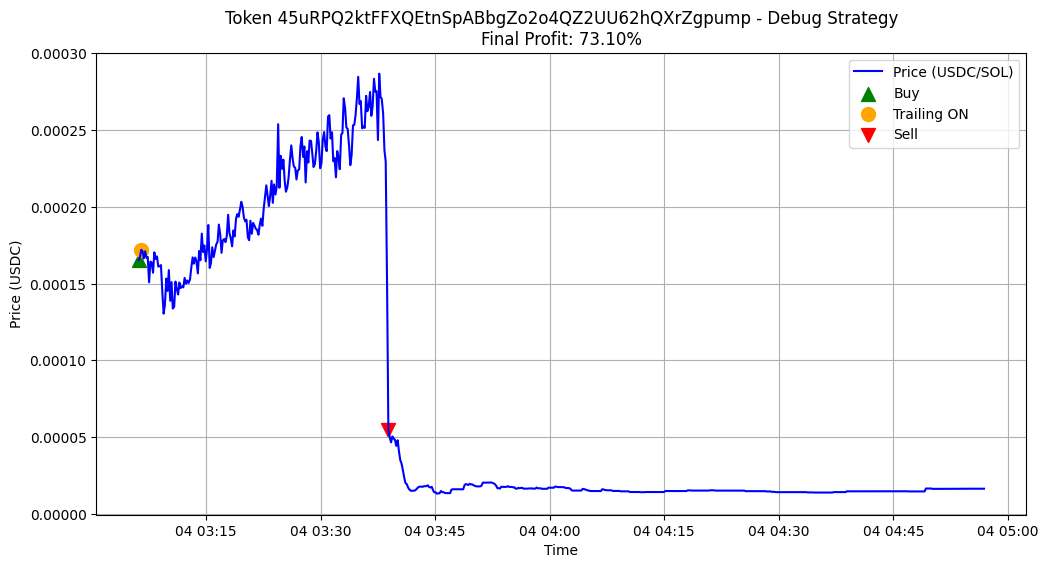

In [24]:
# Imagina que la mejor config resultó en safe_zone=0.01 y trailing_drop=0.49
best_sz = 0.01
best_td = 0.49

# Elige un token cualquiera de tu df
some_token = df['TokenMint'].unique()[3]  # primer token, o uno que conozcas
debug_plot_token(df, some_token, best_sz, best_td, sol_fee=0.001)


In [25]:
def get_all_profits_fixed_fee(df, safe_zone, trailing_drop, sol_fee=0.001):
    """
    Similar a simulate_strategy_on_tokens_fixed_fee, 
    pero devolviendo el array de profits de cada token, 
    en vez de las métricas agregadas.
    """
    profits = []
    
    # Evitar re-ordenar df completo en cada iteración: confiamos en que ya está ordenado.
    for token_id, group in df.groupby('TokenMint'):
        prices_array = group['Price'].to_numpy(dtype=np.float64)
        p = simulate_trade_fixed_fee_in_SOL(prices_array, safe_zone, trailing_drop, sol_fee)
        profits.append(p)
        
    return np.array(profits, dtype=np.float64)


def plot_distribution_of_profits(df, safe_zone, trailing_drop, sol_fee=0.001):
    all_profits = get_all_profits_fixed_fee(df, safe_zone, trailing_drop, sol_fee)
    valid_profits = all_profits[~np.isnan(all_profits)]
    
    if len(valid_profits) == 0:
        print("No hay datos válidos.")
        return
    
    mean_p = np.mean(valid_profits)
    med_p = np.median(valid_profits)
    win_rate = np.mean(valid_profits > 0)
    
    print(f"Distribución con SZ={safe_zone*100:.2f}%, TD={trailing_drop*100:.2f}%")
    print(f" - Mean Profit:   {mean_p*100:.2f}%")
    print(f" - Median Profit: {med_p*100:.2f}%")
    print(f" - Win Rate:      {win_rate*100:.2f}%")

    plt.figure(figsize=(8,5))
    plt.hist(valid_profits, bins=50, color='skyblue', edgecolor='black')
    plt.axvline(mean_p, color='red', linestyle='--', label=f'Mean={mean_p*100:.2f}%')
    plt.axvline(med_p, color='green', linestyle='--', label=f'Med={med_p*100:.2f}%')
    plt.title("Distribution of Final Profits (decimal)")
    plt.xlabel("Profit (decimal)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()


Distribución con SZ=1.00%, TD=49.00%
 - Mean Profit:   53.82%
 - Median Profit: 44.98%
 - Win Rate:      95.45%


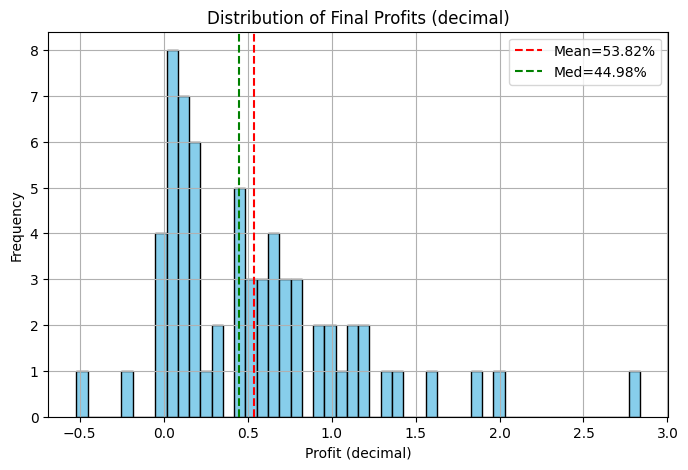

In [26]:
best_sz = 0.01
best_td = 0.49

plot_distribution_of_profits(df, best_sz, best_td, sol_fee=0.001)


### *3.1.5. Data rich*

In [13]:
rich = ["""AQGwBB1pFBSwwzqcGfAmo9MKn9v78hQWnW6eRuYaqLE4,
Ev3AbP3Tq8Q1kQoCs5A5ACyK1xkBhpJ8KSphMXMVnLDR,
VF229R5wg6m9Ts184KRLtBWRiA6LWZqj7FugGiYpump,
3Z7aasEPcSTruJErFBdpJRPyvEPWhKABXHRFcLxoqSpw,
271tiouVizsNSPysMdk4n4Pn5ecyJ3vcmDS9JiYGcfEm,
CRGKtm1fUaqd8f4KWUjkdX3aLSvRHvPEReppLJ4kM6yH,
9aXEF9SoNbaZheiVhDEu7Wrsxfz9m3cUVubv1Be1wT7v,
26AAknygTqz5xHyzkdnbaKZAHk1w5RXQXnjiJihDstua,
9jkZ1ASHRFe33LihDnr1KTZo8mXiR8td69Vub4uEhrCa,
81zjDp8XK6vS76X83b8DPxhTSLfRADNMZHVmMiBv4QQh,
7C76s3D21jns3z5aETyMhbTFaJYv24WxhidSaPTsZiGD,
JDYajNK2L4P2anLBqCSktzTAHjdEQJEqQVZmu5ZgQi6e,
GeXvaV3snrfofV3Hpe3R2mwgFQCmE2h9NKKFbjiexd8W,
3SvssPwT7iT19yNLMmi8B9oof5hHSFhjzxFPuRraixxd,
53hTy7hASc469WxjGm1u5dvqt5hSocufbZc1DrAw8XE1,
678w6zXExN6mme1p8ma7mmzkG535K8oPV7gLXvho9nKd,
Gi2VXBMBQyfnuhneSfG4GunvfaYr2ZfuH4gHb2jJEhnm,
E2eDhos8iQBprPtRRS5DSPff3bMbmuGngxp16uTYpump,
GX8nU8e87CrSNtaZnDtEQGAc4dXpuaijvvDozeaM34LY,
5knyU8JKuHqaQyhq4xqSogeFK9exKYCCac9HKj1J5Snf,
4MFaTE9UrxqmfVj2rU8g1uJmBt3xbEWoAGcroUH57UXx,
9Pv5G7Mtg1UnX19TE1W9H1MXM7e3hNhJivfKHFqRYxAG,
BamsXrwQ6CDVfAYMhdCR72UP6QeTdnRr84cvn1WpGxEo,
Gc2GmghCoZqRkpG2HaKtzALSmDLRjabghdFZoRaV5Y1t,
6kC9kjTA2FPsa8rsJHHdB9H7Vrc7SQiQvqFT9McMuvej,
14XsrWExvHkNkhBN6nxyiFMDW4565DugdkmRrQ5wBaZs,
3yASDSMwcQ4RzikMM9Zf5RzvWCnEyFTVK2LjcU7Ps4LM,
H6ap1dRwvUUvEnUDMwyLRpdVM8uHmgZTpkQYXF8H9CrE,
46BGsg9Q24ou87yviPNZZb7bGtTZQTndUHJXo2DEAtzJ,
DhjmzZU2b8yvT23PPpBkvtzptL4CK6XDeyQJSg3JhJgT,
CeFpMkUrWF4AZsKjhgdoQ7LqpeoUd3W1cca4my7PAXG2,
DT2dynvXxym1Gue5Qqj862oq2J1PzwLUHjrUNPZi4hvh,
6UKPJQfUSX7wgoLq6V5SwjJKwQxb5W7f9LnyEYwGnH2K,
7Sw7bVc6LkZ3sQE6YMu4FVgejpFVzDj83cJnf9xSZbqz,
8FdBaPyLcU4s7LMMYfaciQhtPGKJEY4THEdj3fPLqcTU,
3pVJ5eDPdfunDsRWkNyRRKrMrNGPPjg27F5nG2y4UFuf,
4FZ3G8TKHzWe2Aoc528mHCPiWekdeXvGo6XaBALZtQLE,
9RVwReeNnckDHFHhrr6CfMKCMbL7KiPao68vaRyhJcqc,
3VnauQckEM7148jVHwkkHywt33EgkvsZuoAPCQWdgCRM,
83k8saJmWq2JLe3D3byMKRMMhNJ1TAVLPA9G1CjDgzC1,
ALNT9Q6epHLfiYkSpFtPeh5LCHygtMudaPxZrTN1Kjn4,
HcpAwP1KAyAmVvPa7hQERyzjPsE1SEuvyS2XZPvigfsA,
2dAy7G1rHZbBfoGqKgZgERwb6GHFGTA6JwcwoeW1EDpP,
4DYQBGfp95bwdQ4DycGg7zgrraAcUKdF9QHQXuadSors,
CF53N2Cc65ayCXc6waj6WXhBPNPSd7HwDRGxF5FdKARa,
FKMriWTBUpkhPGeV6PBMN8sihL3iey1Zb7euC6BRtVm6,
sZADPSqrgMKdagdwXgfyXavrYKZNE4nYUWSP7aN8RBf,
7zS6D3tqZYiqzAvMTDxU8iScCznXw9TJsydXaj1mHDU6,
DN5b4wrR3tuJ1K1eTJfpHwGP6XoeCvKgYQRZM3q62T6h,
GgvnWTZh2bxF4qTnVZizgF1ko8kyEajVg4Vk6WJESX3p,
4Niuzu2oDxdrVH9HLVF4DG1GvMgUg3NVjcm8ncos8jf8,
4gie6nQYDXKjJpJMY3rHeS5RyshSymwdP9EquccX3c8L,
CmwGpEgeoVKabQEPSqpAMsn6d2PN9nM6eeJShXHPAgoU,
6deoeWJ9D7wuoWGFPJnhsnoegDC3RYk3mf2GeYKhKKrR,
38PyBgnro9wYLi43QwR6pyoD4G8kiXzu7TFLo64qswzz,
4VjCzEQi7MXRo6J1HbwNo66uiQJCrMjRuyUaZT1Lg4nQ,
DjsL4xHfzPBhZwvsCLeRnzRLby8bb3iVzavLin25a73H,
2RuDRx9RAcXrSoLupeMLGuBay6w5Q1nUrdPySjA3pump,
Hc82SjKTPGo7g2QBCjLZqgWKCPYyRXgqJDCoP8vUEr37,
FgocGdnY9BDBneDDQ7hhjRPTy2nBi14hfa8jEsSjKGhv,
JCjw5HFnuhyXqdCF94EFgrXmKL2CCpVMx8M6i6hiesUZ,
2rMJ4x12r4qPJToRW1Ci4h54QrVj4tkatrtJcwXRHeFZ,
EpKe5ADw3ocjEpsRMvWyejaxNDWc2CEqvpM6CfbYNQFj,
HbU5gVbpJiNcw5SSoEeWLWPrFcSEV5VyL8WYnFooyfrE,
ApSpfpFdP68dQqeNPcKRnLQPSvv8e1THRN9ktBVbtFut,
GqYu4MxDzH84ngUcUBdai6bjqhwhNDz2VyV8Rf5YNeK5,
4R5nPZdd7JLFMNYNf7EsAMUdaiMx7BorNjKRrTeb3Jfi,
BjJvKMRTaXEj5WAL4cLZm1jJWAfYuUGUAKNi9jMrrTvG,
AjyRRwdjqkKXnmdZXdDxHzSBUWjZgFL3oSi8L3WcN6ZN,
BNfZqMvwQKhsmX43hRmPTp7fmMSrkd7Uc6Do6aNkZmHV,
BwYVhz3nacSbsHEUNrJUvZCDwsTHvWdoLMSMM4qNgAXq,
38K7nGA8FFbYR7NTQiHmMDeZGkAFD9xtQNjYVhmP5BrU,
Fj5tf8P1sqdbTMAeT9D55ExjsMmfxRGq8U6TH2mi4EKJ,
CZw1oPBE9Nrm1rvdBS2duwSaSiF5oj6cpvqK94oWsLAH,
F9hxzsGhwMcped6kdnJFLm1LMyyif7bVjKg5ZTLXWjk2,
ATR4vv6qK9hMxtWuf62ywcESBZT282oGNzGvQrENdNFK,
59YQDjmNzWJqpY5a7r9FoW8XvM7gsCHNphH9ABYK7wBU,
7HxLQge9Tt2vvueAqCWBdaaQxPcDhp5UqZmW8k8b99qx,
7tdL61mTkmzpkF4S7zNR7NZiksXAANHbRTUNCd5ASLHF,
HatHCMgRzbH8meTKhkruovVciseeg5kaFnLgdqWWR38v,
2U5sVmgdR1zthqShLpmh8agw9cB8FU62F4BWMtBB8MEp,
8rmuA3KWcGUqQK6Vq5P6ZskpCFGCo5sEKP3F8uy5JgSs,
4BnWEQdKNHf5KVC5NaM7smY8L6JRZkusQyKn21x2bFDv,
EvMMYRcLRg3MLzYkzv465jqxSeE97KNvA4KpsdhTfKrB,
2LPpDTHWUXRcxTD6pj6r3zT64rbny7PFXmmj95S19fZW,
DuMLRmq8yyfrQRsEyU2vSeX5SKvvcm69i6ZRcLyUda3W,
BMyYveSgYekm8mfBm4BS4vsKYxFkU9StyMYMUt3mLtdh,
4CbDVUjrBwqcZbnfz3Xdc9TqSoNRTEVHEao32anMGYcH,
FqngfLiyGBcKctfh1hQARzwjHdzwJNWJQXrnPkKFv2yZ,
9Aiusy4zEqVp328Ye4bxV1PcgWtc5AxjR4cGLago47rW,
HaczwBnsUBAubyVe25eLXe7GrmxPASNDpQoiF8eB8Sxp,
DfzDDqmodQfSyuGefqjqL21bnweA17GtsQKiNbjAtab4,
5pczx1kLvUyBG6Q95DqujVdQKTcsJEXVw3gwiATbgAi9,
7tmhUF37jKD1hwGFfDiuJkw6aarrtcLtDoUFg2ekpcPC,
3j7hJe8ewZcBLPQaqSJYTZnYjR2bz5n1Hr2MVd2kHwnt,
3r4uVuWHcVRnH4xeFAmh9w6s69R4wGcDGkWEjLdtFpxf,
S1LtKefMqh2eHDya1ZNAAwiFGz9ovCD4UPbh8XLv8jg,
H66LP9b8eUUMGrUAtPB5zEU87Xjf3jUuWnyoswm1YNMW,
2qTYpoKTM5jABwHRgMo4zfVsufrKfJG76zYNMBeujiuc,
4j7v6jBjDPcT5WhegqDwtnUTRw98g8hDZjwiQM6Kv4Xy,
CDCAepnkaQLPe53q77iqNDA5CcjPGYy2REBxy3Z6gPB3,
5d7RTeoYt7tXnCmKwbJZbG633QX1aJTDCK1JtsHe37R2,
4eB1BfQi5Ar52Jjd3itFcCNSTvKKTqBjfXzN5akNPLgi,
B6F2XF2FzYGum7G5wgiAijiTr7Tirzu32Cd65nTNe2ox,
BY631CXiQWbzRNpr4oL43cvURFdwECqzNchnGcdFsiqx,
BXuiviCvdQ118soCRoC5aCKBVsARcp3jzk4TSTZTgNsP,
5GM67mqcfSn6PQmCohCw3XyG1J2G92v6pEpfABL8hyxY,
5BgWFxXhJvE8dDWUrvNrYCE2y2ip381aApUZrWsew4Jo,
HSGJ9zQihjymWd6ZEdmoNFrxYmyxhMn13nEKnRyFrupz,
F8x2YSUsiXQHPvSd6jAjTxeDyFbVLFETq8PtsfTAp3AG,
Ar4XnrkhRaquvPDtmQdDxdY3bXgwqTgmiJxaLoWSH7a5,
8JvntSgCyaW19p52JdnkkMezjSroh2dyxTYTXaycijpH,
Fh1w48Y9S4Rckrucsd2ThpEc3J9vhMYyVWMYQrw7mbzS,
FKZwG4onXk9dt3S5kA5nwyHaGdVSH6Kn7mm7zb9pdytk,
AfsQXKg6t6gZCKZC7SHfaUMs3YUdaQv9sVEM4oD59Nr6,
4SSFdadUZhfohKPWnkvcbnmLj4aXpZVYYqHwYqUc97dM"""]

# Extraer la cadena única de la lista
rich_str = rich[0]

# Dividir la cadena por comas y quitar espacios o saltos de línea adicionales
rich_list = [token.strip() for token in rich_str.split(",") if token.strip()]

# Ahora puedes iterar sobre rich_list
for token in rich_list:
    print(token)

rich_list


AQGwBB1pFBSwwzqcGfAmo9MKn9v78hQWnW6eRuYaqLE4
Ev3AbP3Tq8Q1kQoCs5A5ACyK1xkBhpJ8KSphMXMVnLDR
VF229R5wg6m9Ts184KRLtBWRiA6LWZqj7FugGiYpump
3Z7aasEPcSTruJErFBdpJRPyvEPWhKABXHRFcLxoqSpw
271tiouVizsNSPysMdk4n4Pn5ecyJ3vcmDS9JiYGcfEm
CRGKtm1fUaqd8f4KWUjkdX3aLSvRHvPEReppLJ4kM6yH
9aXEF9SoNbaZheiVhDEu7Wrsxfz9m3cUVubv1Be1wT7v
26AAknygTqz5xHyzkdnbaKZAHk1w5RXQXnjiJihDstua
9jkZ1ASHRFe33LihDnr1KTZo8mXiR8td69Vub4uEhrCa
81zjDp8XK6vS76X83b8DPxhTSLfRADNMZHVmMiBv4QQh
7C76s3D21jns3z5aETyMhbTFaJYv24WxhidSaPTsZiGD
JDYajNK2L4P2anLBqCSktzTAHjdEQJEqQVZmu5ZgQi6e
GeXvaV3snrfofV3Hpe3R2mwgFQCmE2h9NKKFbjiexd8W
3SvssPwT7iT19yNLMmi8B9oof5hHSFhjzxFPuRraixxd
53hTy7hASc469WxjGm1u5dvqt5hSocufbZc1DrAw8XE1
678w6zXExN6mme1p8ma7mmzkG535K8oPV7gLXvho9nKd
Gi2VXBMBQyfnuhneSfG4GunvfaYr2ZfuH4gHb2jJEhnm
E2eDhos8iQBprPtRRS5DSPff3bMbmuGngxp16uTYpump
GX8nU8e87CrSNtaZnDtEQGAc4dXpuaijvvDozeaM34LY
5knyU8JKuHqaQyhq4xqSogeFK9exKYCCac9HKj1J5Snf
4MFaTE9UrxqmfVj2rU8g1uJmBt3xbEWoAGcroUH57UXx
9Pv5G7Mtg1UnX19TE1W9H1MXM7e3hNhJivfKHFqRYxAG
BamsXrwQ6CD

['AQGwBB1pFBSwwzqcGfAmo9MKn9v78hQWnW6eRuYaqLE4',
 'Ev3AbP3Tq8Q1kQoCs5A5ACyK1xkBhpJ8KSphMXMVnLDR',
 'VF229R5wg6m9Ts184KRLtBWRiA6LWZqj7FugGiYpump',
 '3Z7aasEPcSTruJErFBdpJRPyvEPWhKABXHRFcLxoqSpw',
 '271tiouVizsNSPysMdk4n4Pn5ecyJ3vcmDS9JiYGcfEm',
 'CRGKtm1fUaqd8f4KWUjkdX3aLSvRHvPEReppLJ4kM6yH',
 '9aXEF9SoNbaZheiVhDEu7Wrsxfz9m3cUVubv1Be1wT7v',
 '26AAknygTqz5xHyzkdnbaKZAHk1w5RXQXnjiJihDstua',
 '9jkZ1ASHRFe33LihDnr1KTZo8mXiR8td69Vub4uEhrCa',
 '81zjDp8XK6vS76X83b8DPxhTSLfRADNMZHVmMiBv4QQh',
 '7C76s3D21jns3z5aETyMhbTFaJYv24WxhidSaPTsZiGD',
 'JDYajNK2L4P2anLBqCSktzTAHjdEQJEqQVZmu5ZgQi6e',
 'GeXvaV3snrfofV3Hpe3R2mwgFQCmE2h9NKKFbjiexd8W',
 '3SvssPwT7iT19yNLMmi8B9oof5hHSFhjzxFPuRraixxd',
 '53hTy7hASc469WxjGm1u5dvqt5hSocufbZc1DrAw8XE1',
 '678w6zXExN6mme1p8ma7mmzkG535K8oPV7gLXvho9nKd',
 'Gi2VXBMBQyfnuhneSfG4GunvfaYr2ZfuH4gHb2jJEhnm',
 'E2eDhos8iQBprPtRRS5DSPff3bMbmuGngxp16uTYpump',
 'GX8nU8e87CrSNtaZnDtEQGAc4dXpuaijvvDozeaM34LY',
 '5knyU8JKuHqaQyhq4xqSogeFK9exKYCCac9HKj1J5Snf',
 '4MFaTE9UrxqmfVj2rU8

In [14]:
filtered_tokens = price_variations_lp[price_variations_lp['TokenMint'].isin(rich_list)]
filtered_tokens

,TokenMint,BoostID,AdjustedBoostAmount,TokenAge (mins),BoostTime,IsPump,NumberOfSocials,StartMktCap,StartLiquidityUSD,max_price_variation (%),min_price_variation (%),final_variation (%),trigger_signal,trigger_time_diff (s),max_price_time_diff (s),min_price_time_diff (s),slope_metric
10,14XsrWExvHkNkhBN6nxyiFMDW4565DugdkmRrQ5wBaZs,1,10,6.433333,2025-02-11 06:59:57,False,0,2002962489,497586,15.857471,-0.010002,15.838986,None,1000,957,9,-0.00076
43,26AAknygTqz5xHyzkdnbaKZAHk1w5RXQXnjiJihDstua,1,10,6.916667,2025-02-12 04:32:32,False,0,1970093516,481266,18.226866,-0.010001,18.226866,None,1000,907,6,0.0
49,271tiouVizsNSPysMdk4n4Pn5ecyJ3vcmDS9JiYGcfEm,1,10,7.766667,2025-02-13 14:59:50,False,0,2006545555,480577,3.235012,-99.999992,-96.357048,SL,151,69,492,-0.02179
117,2LPpDTHWUXRcxTD6pj6r3zT64rbny7PFXmmj95S19fZW,1,10,9.066667,2025-02-08 04:44:54,False,0,2182490487,451319,28.959837,-0.010000,28.959837,None,1000,991,0,No data after max
124,2RuDRx9RAcXrSoLupeMLGuBay6w5Q1nUrdPySjA3pump,1,50,1.783333,2025-02-09 06:44:58,True,2,129652,41934,210.106018,-24.366676,60.053612,TP,309,381,42,-0.516419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3201,JCjw5HFnuhyXqdCF94EFgrXmKL2CCpVMx8M6i6hiesUZ,1,10,6.500000,2025-02-09 04:54:47,False,0,2352767592,623392,31.712687,-0.010000,31.712687,None,1000,999,10,No data after max
3202,JDYajNK2L4P2anLBqCSktzTAHjdEQJEqQVZmu5ZgQi6e,1,10,8.033334,2025-02-12 01:10:41,False,0,1966996055,484467,15.752453,-0.344306,15.752453,None,1000,976,58,0.0
3299,S1LtKefMqh2eHDya1ZNAAwiFGz9ovCD4UPbh8XLv8jg,1,10,7.950000,2025-02-07 11:08:57,False,0,2342186031,608239,35.720139,-0.009999,35.720139,None,1000,993,5,No data after max
3310,VF229R5wg6m9Ts184KRLtBWRiA6LWZqj7FugGiYpump,1,500,7.983333,2025-02-13 15:30:47,True,1,290413,60435,78.263290,-2.733247,63.924820,TP,419,429,615,-0.427716


### *3.1.6.* Métricas resumen en X segundos

In [ ]:
old_data_price_metrics = prepare_and_simulate_boosts_with_metrics(price_evo_boost_filtered_old, stop_loss=-20, take_profit=30, max_time_diff=1600, slippage=0.001)

old_data_price_metrics

In [48]:
price_metrics_filtered_tokens = prepare_and_simulate_boosts_with_metrics(price_evo_boost_filtered, stop_loss=-20, take_profit=30, max_time_diff=1600, slippage=0.001)

price_metrics_filtered_tokens

,TokenMint,BoostID,AdjustedBoostAmount,TokenAge (mins),BoostTime,IsPump,NumberOfSocials,StartMktCap,StartLiquidityUSD,max_price_variation (%),min_price_variation (%),final_variation (%),trigger_signal,trigger_time_diff (s),max_price_time_diff (s),min_price_time_diff (s),slope_metric
0,3ALHT6WfDgjQBTxYvTvEWSJfHDSkgCEzYrsmifGbpump,1,500,5.400000,2025-02-11 01:38:40,True,3,165330,46955,-0.100003,-55.678894,-20.442495,SL,112,9,831,0.047974
1,3GsqZXf5DP1pwW7ZoQ16pw6dtbwc9haNwuEaaWc8pump,1,500,3.950000,2025-02-12 01:03:40,True,3,144213,43347,8.925894,-46.578667,-22.728481,SL,86,778,1066,-0.022412
2,3jqoNt5YT1Wp2CVmX1nvsew21mFge5bRQonBgZWapump,1,500,5.500000,2025-02-14 12:11:09,True,3,146654,44252,29.546085,-95.854691,-59.202396,SL,214,88,245,-0.879148
3,45uRPQ2ktFFXQEtnSpABbgZo2o4QZ2UU62hQXrZgpump,1,500,7.416667,2025-02-04 03:06:04,True,2,152577,47079,56.963856,-21.188644,-21.188644,SL,203,1505,203,-0.205332
4,4CQJwTSHvLt2HNWsiXkYBf9N5fED4N2R6AK2QPWYpump,1,500,5.850000,2025-02-04 19:16:18,True,2,132153,43076,3.047661,-95.696396,-31.188757,SL,832,47,1203,-0.039697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,wq98CvTqZCmM6suvyBXUKjCBWJBeAJJbKxt1pr2pump,1,500,3.916667,2025-02-12 01:31:13,True,0,146919,43723,45.010750,-94.250732,45.010750,TP,106,106,1326,-0.366722
62,xVPYVqLbomaf2t2KWE4xDEXwrPm89HvZHnhno1wpump,1,500,9.616667,2025-02-11 15:07:30,True,0,320243,65771,9.847370,-71.995209,-52.286255,SL,834,68,1442,0.0
63,yYffzr4HFYB3T6nVWXSkGag6JKpZ2Dio7kWUtf3pump,1,500,5.633333,2025-02-13 19:29:57,True,1,133470,41147,52.383389,-96.451378,37.283966,TP,554,760,987,-0.094884
64,ykPcmFuaN3JhRsbBxu83t3QN7w9EDFqJiutQ8mKpump,1,500,4.366667,2025-02-08 22:26:31,True,0,140462,42792,18.474609,-93.991127,-93.279709,SL,349,308,585,-0.364938


## *3.2. Parseando markets y filtrando columnas útiles*

## *3.2.1. Funciones*

In [15]:
def parse_and_process_markets_with_holders(df, markets_column, time_column, index_column, boost_col):
    registros = []

    # Convertir Time a formato datetime y ordenar correctamente
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.sort_values(by=[index_column, time_column])  # Ordenamos por TokenMint y Time

    for _, row in df.iterrows():
        token_mint = row[index_column]
        boost_id = row[boost_col]
        time = row[time_column]  # Extraer el tiempo de la fila actual
        raw_data = row[markets_column]

        if pd.notna(raw_data) and raw_data != 'null':
            try:
                data_json = json.loads(raw_data) if isinstance(raw_data, str) else raw_data
            except Exception as e:
                print(f"Error decodificando JSON para {token_mint} en {time}: {e}")
                continue

            # Si es un dict, lo convertimos en lista para iterar
            if isinstance(data_json, dict):
                data_json = [data_json]

            for entrada in data_json:
                # Nos centramos en mercados tipo "raydium"
                if entrada.get('marketType') != 'raydium':
                    continue

                # Aplanamos toda la información del JSON
                flat_entry = pd.json_normalize(entrada, sep='_')
                flat_entry['TokenMint'] = token_mint
                flat_entry['BoostTime'] = time  # Usamos esta columna para el tiempo
                flat_entry['BoostID'] = boost_id

                # Extraer el propietario de liquidez a partir de las cuentas (si están presentes)
                if 'liquidityAAccount_owner' in flat_entry.columns:
                    flat_entry['lp_liquidity_owner'] = flat_entry['liquidityAAccount_owner']
                elif 'liquidityBAccount_owner' in flat_entry.columns:
                    flat_entry['lp_liquidity_owner'] = flat_entry['liquidityBAccount_owner']

                # Procesar lp_holders para extraer métricas y direcciones
                if 'lp_holders' in flat_entry.columns:
                    lp_holders_val = flat_entry.at[0, 'lp_holders']
                    if isinstance(lp_holders_val, str):
                        try:
                            holders = json.loads(lp_holders_val)
                        except Exception as e:
                            print(f"Error procesando lp_holders para {token_mint} en {time}: {e}")
                            holders = []
                    else:
                        holders = lp_holders_val

                    if isinstance(holders, list):
                        unique_addresses = len({h.get('address') for h in holders if 'address' in h})
                        flat_entry['lp_holders_unique_addresses'] = unique_addresses

                        pcts = [h.get('pct', 0) for h in holders]
                        pcts_sorted = sorted(pcts, reverse=True)
                        flat_entry['lp_holders_top_holder_pct'] = round(pcts_sorted[0], 4) if pcts_sorted else 0
                        flat_entry['lp_holders_top_5_holders_pct'] = round(sum(pcts_sorted[:5]), 4) if pcts_sorted else 0

                        # Extraer las direcciones de los holders
                        addresses = [h.get('address') for h in holders if 'address' in h]
                        flat_entry['lp_holders_addresses'] = ",".join(addresses)

                registros.append(flat_entry)
        else:
            registros.append(pd.DataFrame({
                'TokenMint': [token_mint],
                'BoostTime': [time],
                'BoostID': [boost_id]
            }))

    df_result = pd.concat(registros, ignore_index=True) if registros else pd.DataFrame()

    # Seleccionar las columnas de interés. Se incluyen campos adicionales para rastrear grupos:
    selected_columns = [
        'TokenMint',
        'BoostID',
        'BoostTime',
        'pubkey',                    # Identificador único del mercado
        'mintA',                     # Token A de la pool
        'mintB',                     # Token B de la pool
        'mintLP',                    # Token LP
        'liquidityA',                # Dirección de liquidez A
        'liquidityB',                # Dirección de liquidez B
        'lp_liquidity_owner',        # Propietario principal de la liquidez
        'lp_quotePrice',             # Precio de la cotización en el LP
        'lp_basePrice',              # Precio base en el LP
        'lp_quoteUSD',               # Valor en USD basado en la cotización
        'lp_baseUSD',                # Valor en USD basado en el precio base
        'lp_lpLockedPct',            # Porcentaje bloqueado del LP
        'lp_lpLockedUSD',            # Valor en USD bloqueado en el LP
        'lp_holders_unique_addresses',  # Número de holders únicos
        'lp_holders_top_holder_pct',    # Porcentaje del holder principal
        'lp_holders_top_5_holders_pct',   # Porcentaje combinado de los 5 principales holders
        'lp_holders_addresses'           # Direcciones de los holders
    ]
    final_columns = [col for col in selected_columns if col in df_result.columns]
    df_result = df_result[final_columns].sort_values(by=['TokenMint', 'BoostID']) if not df_result.empty else df_result

    # Merge con el dataframe original para conservar la correspondencia con el índice y tiempo original
    df_unique = df.drop_duplicates(subset=[index_column, time_column])[[index_column, time_column]]
    df_final = pd.merge(
        df_unique,
        df_result,
        left_on=[index_column, time_column],
        right_on=['TokenMint', 'BoostTime'],
        how='left'
    )

    return df_final



## *3.2.2. Probando*

In [16]:
# Ensure unique index before setting multi-index
markets_data_boost = parse_and_process_markets_with_holders(df_analysis, 'Markets', 'Time', 'TokenMint', 'BoostID')


In [17]:
markets_data_boost

,TokenMint,Time,BoostID,BoostTime,pubkey,mintA,mintB,mintLP,liquidityA,liquidityB,...,lp_quotePrice,lp_basePrice,lp_quoteUSD,lp_baseUSD,lp_lpLockedPct,lp_lpLockedUSD,lp_holders_unique_addresses,lp_holders_top_holder_pct,lp_holders_top_5_holders_pct,lp_holders_addresses
0,12WJtTWYMA99d2XVdGoxmgqV4Qj8pxZhxBdDZ5Q9AbjL,2025-02-10 16:15:24.306000+01:00,1.0,2025-02-10 16:15:24.306000+01:00,AtkrY3AztamXV3QrYSSNrt8FQDTZjk8SKaLioZ99iFPz,So11111111111111111111111111111111111111112,12WJtTWYMA99d2XVdGoxmgqV4Qj8pxZhxBdDZ5Q9AbjL,68cV4AQt2Kh1RDHNKVnTwnGtnfMRubBqmZ3TFoBddwr3,6B1KLDBxqrKNocAKecrEXmz3NB824RKasBtptJGG6dFy,ErC2YvcaGRwqUypTpGT71ELiT6h7vHX4fw6DGMNcUT17,...,0.000249,205.721547,44789.689409,44094.059113,0.016135,14.341458,1.0,99.9839,99.9839,8WWR6SPHEnDjEcLVeo6oxkR8eJvgRQrMLUGzgPP7GPH1
1,12iY44KgaEyqGkzrRb27F1KXdau97ugq4e5o7R7iSVZa,2025-02-05 18:40:50.032000+01:00,1.0,2025-02-05 18:40:50.032000+01:00,9JC1dzt1xTHsKPhqc9TJQaftfcJnt9JzBUhRwLBx2K21,So11111111111111111111111111111111111111112,12iY44KgaEyqGkzrRb27F1KXdau97ugq4e5o7R7iSVZa,7k28DYvx1GdM6Rx5C64LCkiPK897AvQzporoB4THEhbr,5JcCkehaoJVxjYjLe6CxDkEJ8cvA9tnWmWE7Gn7mTPdm,ASVWuM8Y3xALM2L1udVF36TqxjGdjXv2y1jZo3DEA77C,...,0.000014,197.828691,8007.716951,5732.890684,100.000000,13740.607635,1.0,0.0000,0.0000,H37yXaVwugZrAaRftAtq5uYKHcax5PT5gtY8CTYUphjS
2,12ifMz54Sq4Ab4RiPezsbDYkY2fo5L3VTabfJJ2ppump,2025-02-02 19:57:05.167000+01:00,1.0,2025-02-02 19:57:05.167000+01:00,AybF7GZXLPaZ2ChriqGJLeR3cFkoWyK24CbeuA4FkZd5,So11111111111111111111111111111111111111112,12ifMz54Sq4Ab4RiPezsbDYkY2fo5L3VTabfJJ2ppump,BtMCycjuKF8hTz17TyzPFKLrjsHH2kinGkowa5G2rFH9,AngtxiozQaemPdwP2TLvr6BhCXRBqYgsVxdmx731ZHeh,HEVF6E2gfXz2akFPSoHfDDnzeWfs9mUGUQmEwxU7Amf9,...,0.000505,199.786992,44022.391197,44451.864771,99.989379,88464.859342,4.0,0.0106,0.0106,"36zcTgnPyXFHKXiPerJdZH62Ur3VHRNHsDRuawuky1dp,D..."
3,1332NrDAqXSjFZTVCPgVC4f6RDnygpzPxaVk6Gsfjump,2025-02-08 11:41:51.289000+01:00,1.0,2025-02-08 11:41:51.289000+01:00,6SBVZLfpSPdyTDUVMd3Ld7ptAD4KCmyKkNUoSfeS7dnE,1332NrDAqXSjFZTVCPgVC4f6RDnygpzPxaVk6Gsfjump,So11111111111111111111111111111111111111112,GEbkFwHX33z1dqsW4g2Ame8o9VChXhHS9DL18h6Kkf2B,C4y8xDmkB1CtfYP47ZkbAdtSZghFgMBh3M3GiQA9Y4mN,48NTWNS6qHD7Lcn1mcSi18nr6U3Mtx4eMvh4JqzCpznt,...,193.884188,0.000212,21001.547041,20698.916866,100.000000,41700.463907,1.0,0.0000,0.0000,6FgoEtAJUEoupqqZf4NaD1iiwnyHRVq8QxonaM5DswpW
4,1332NrDAqXSjFZTVCPgVC4f6RDnygpzPxaVk6Gsfjump,2025-02-08 12:02:32.100000+01:00,2.0,2025-02-08 12:02:32.100000+01:00,6SBVZLfpSPdyTDUVMd3Ld7ptAD4KCmyKkNUoSfeS7dnE,1332NrDAqXSjFZTVCPgVC4f6RDnygpzPxaVk6Gsfjump,So11111111111111111111111111111111111111112,GEbkFwHX33z1dqsW4g2Ame8o9VChXhHS9DL18h6Kkf2B,C4y8xDmkB1CtfYP47ZkbAdtSZghFgMBh3M3GiQA9Y4mN,48NTWNS6qHD7Lcn1mcSi18nr6U3Mtx4eMvh4JqzCpznt,...,193.583474,0.000324,24165.818100,28106.221824,100.000000,52272.039925,1.0,0.0000,0.0000,6FgoEtAJUEoupqqZf4NaD1iiwnyHRVq8QxonaM5DswpW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3818,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,2025-02-03 19:52:35.506000+01:00,2.0,2025-02-03 19:52:35.506000+01:00,AZ2HfxLzkPUoxeCyUGiKVxfRajRANwDmLMZWMGJdGUVL,So11111111111111111111111111111111111111112,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,7tfizWCXEPV2rHkh9KKtMpLfr3HVqmffQsKNaU3ZmEa5,GSreEc8rCKMRdomJXmYWQx6qyz5UwXpPMdpiT2ZyoeBk,E5VM2g54b8AfLJYD4TgjwJuyz79xWd17kHhRoHLcQ2eq,...,0.000318,211.716034,31591.553866,35097.419838,100.000000,66688.973704,1.0,0.0000,0.0000,2yyGqk2HQBbAFcWjYpYwwUPLpdoJgdEoVSZJ31cCxKAf
3819,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,2025-02-03 20:08:45.633000+01:00,3.0,2025-02-03 20:08:45.633000+01:00,AZ2HfxLzkPUoxeCyUGiKVxfRajRANwDmLMZWMGJdGUVL,So11111111111111111111111111111111111111112,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,7tfizWCXEPV2rHkh9KKtMpLfr3HVqmffQsKNaU3ZmEa5,GSreEc8rCKMRdomJXmYWQx6qyz5UwXpPMdpiT2ZyoeBk,E5VM2g54b8AfLJYD4TgjwJuyz79xWd17kHhRoHLcQ2eq,...,0.000339,212.254990,33958.531776,35556.009347,100.000000,69514.541123,1.0,0.0000,0.0000,2yyGqk2HQBbAFcWjYpYwwUP

In [18]:
rich_markets = markets_data_boost[markets_data_boost['TokenMint'].isin(rich_list)]
rich_markets

,TokenMint,Time,BoostID,BoostTime,pubkey,mintA,mintB,mintLP,liquidityA,liquidityB,...,lp_quotePrice,lp_basePrice,lp_quoteUSD,lp_baseUSD,lp_lpLockedPct,lp_lpLockedUSD,lp_holders_unique_addresses,lp_holders_top_holder_pct,lp_holders_top_5_holders_pct,lp_holders_addresses
10,14XsrWExvHkNkhBN6nxyiFMDW4565DugdkmRrQ5wBaZs,2025-02-11 06:59:57.716000+01:00,1.0,2025-02-11 06:59:57.716000+01:00,8iKar5349xApBviMb6RPBE2HLsdmRJckY3VvFDx9iYjq,14XsrWExvHkNkhBN6nxyiFMDW4565DugdkmRrQ5wBaZs,So11111111111111111111111111111111111111112,EFASrSe7mCzttQUZMRdVyxn3AcguRURiKKetkDT8raP4,FMjmSGsxxewwpWFMHbKRDsiueinWskoemc2qNbQM1SCX,Brm7LJKD4hZJJGci3ADXS7S78VfFRK9jb77JyP1psUEH,...,204.984821,0.000200,248884.632099,248294.834465,100.000000,497179.466564,1.0,0.0,0.0,AmQPTXUy9nBACc4mruVgwKHYQvYsvJLN4gQFLCm3zFum
43,26AAknygTqz5xHyzkdnbaKZAHk1w5RXQXnjiJihDstua,2025-02-12 04:32:32.698000+01:00,1.0,2025-02-12 04:32:32.698000+01:00,9JCr5Qn9EqgahT9PP22TT9bWBGZmpg7gVnS5Wtks2th6,26AAknygTqz5xHyzkdnbaKZAHk1w5RXQXnjiJihDstua,So11111111111111111111111111111111111111112,7P4AtPpbVnisJrQqY7BYjbYTa5ZdV2WMWnavJDte7MoS,9wMcC1NCDvfHmsf5uStTcHvr3hLrvjTqXQyU7QeCMQce,9W6y6kFWskRDjotgxk46Apcg6H6zSGvqjpPMwSH5XyxT,...,194.912808,0.000202,243202.208477,243364.746918,100.000000,486566.955394,1.0,0.0,0.0,9P3g1j5yspAMHSoWouAWcC3F2P9HdJ2unyTJxc8eyUZy
49,271tiouVizsNSPysMdk4n4Pn5ecyJ3vcmDS9JiYGcfEm,2025-02-13 14:59:50.051000+01:00,1.0,2025-02-13 14:59:50.051000+01:00,A8mjaiXNqo3R9Pvja2c8NC4vXM9AFCuViAQLSjBvfDa4,271tiouVizsNSPysMdk4n4Pn5ecyJ3vcmDS9JiYGcfEm,So11111111111111111111111111111111111111112,3bmkgLC9X1ZUxPSc7yyrfyDtiJRUeVCwVGpL8mbt5Xo6,BGW9YTVCv8veD93UJo7QPcS8hUnSMqE5ff16UCZRA8ih,94qH2zQ9juKHidbTSkDbkjdT77JQC3etrNgCx68X1gNG,...,191.136800,0.000201,241805.225803,238992.970348,100.000000,480798.196151,1.0,0.0,0.0,GCZbLhXpV9W4WaHBfGKU5G5PcR4rGEgM9oLTw8kR6bHi
121,2LPpDTHWUXRcxTD6pj6r3zT64rbny7PFXmmj95S19fZW,2025-02-08 04:44:54.005000+01:00,1.0,2025-02-08 04:44:54.005000+01:00,Dy141UknohVLXqMhRB5NAYheyk8DgTj5FgRKm6pgXbQw,2LPpDTHWUXRcxTD6pj6r3zT64rbny7PFXmmj95S19fZW,So11111111111111111111111111111111111111112,B8bx8AgB6szQ8LJHSxnqxNw7tdgszJZn5Kv5cfFENvdw,5PumHvjVGdp1upUMwhZ46U4zD5QwkqiBy81cufS3VBRN,FchaLvQDVzqhbEbH8pmKSCLSDzdD6bqHg4FPfxrUjocE,...,193.394073,0.000224,228663.454012,228852.892990,100.000000,457516.347002,1.0,0.0,0.0,8doH8751QUxnSE6JXcqfomD8z4SWRD9eRnPX9TGow6qP
130,2RuDRx9RAcXrSoLupeMLGuBay6w5Q1nUrdPySjA3pump,2025-02-09 06:44:58.519000+01:00,1.0,2025-02-09 06:44:58.519000+01:00,B6GNKnaVeDrahttqvKyf58GUQYsqyQif6LdxaxHpynnv,So11111111111111111111111111111111111111112,2RuDRx9RAcXrSoLupeMLGuBay6w5Q1nUrdPySjA3pump,bDXa44zL8NB5mamhBkyAHoJsUN2Sdh4nbCq7RCwZYA8,D5zDYVAmLdtfvetedWapsBekQE6bPRfCpeZoQJqtZmk1,b297s5iA93cGaPXapZVdkgZ3BoyS6RHMsz5ZAUdkzFZ,...,0.000085,206.793423,16517.251502,17332.356838,0.024734,8.372307,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3392,JCjw5HFnuhyXqdCF94EFgrXmKL2CCpVMx8M6i6hiesUZ,2025-02-09 04:54:47.255000+01:00,1.0,2025-02-09 04:54:47.255000+01:00,2eAdMz2UBxpnSuxVXUTb7DDwFaXUg3jPpKw1NwSHPa36,JCjw5HFnuhyXqdCF94EFgrXmKL2CCpVMx8M6i6hiesUZ,So11111111111111111111111111111111111111112,H28eJsLfJpZyorqr3R69BQqbwTLywbVqhx5VPku8Vo5h,9JTj1GFnvYSGZXYgm7gBjvHPxyNcLdLcjYFfpjqGTb3r,7rX1vwKKaYTejP2jJEw6ebPE5ahwbmW8yav6aU216pTq,...,205.713067,0.000239,316070.973017,311735.916784,100.000000,627806.889802,1.0,0.0,0.0,EqEb5ALgLseeDm9wWLSYrGi859WAT9LPZUCJJX2rYmpg
3393,JDYajNK2L4P2anLBqCSktzTAHjdEQJEqQVZmu5ZgQi6e,2025-02-12 01:10:41.628000+01:00,1.0,2025-02-12 01:10:41.628000+01:00,DEzf45YXfEvCYQNRDVqvnad74AFWtrG5qdnXLLMCp1UR,JDYajNK2L4P2anLBqCSktzTAHjdEQJEqQVZmu5ZgQi6e,So11111111111111111111111111111111111111112,78NA8MQHdLESKTkaF4tCA2ajWb77yWe5dzHKFtwJYZFg,67qCGfR5BSwtJu9jMsWXwoq74WD5kodne1bPqxPw323g,7nCxULssUtAh89n6xN2wmvwKbb98H8kKvVhTqj2AUxin,...,198.058573,0.000197,243868.652232,240685.211454,100.000000,484553.863686,1.0,0.0,0.0,BQKB6fwiLkP5XiexD4t9qzafNfCmBAu9Q3oAq3xXs2Ki
3497,S1LtKefMqh2eHDya1ZNAAwiFGz9ovCD4UPbh

In [19]:
markets_data_boost

,TokenMint,Time,BoostID,BoostTime,pubkey,mintA,mintB,mintLP,liquidityA,liquidityB,...,lp_quotePrice,lp_basePrice,lp_quoteUSD,lp_baseUSD,lp_lpLockedPct,lp_lpLockedUSD,lp_holders_unique_addresses,lp_holders_top_holder_pct,lp_holders_top_5_holders_pct,lp_holders_addresses
0,12WJtTWYMA99d2XVdGoxmgqV4Qj8pxZhxBdDZ5Q9AbjL,2025-02-10 16:15:24.306000+01:00,1.0,2025-02-10 16:15:24.306000+01:00,AtkrY3AztamXV3QrYSSNrt8FQDTZjk8SKaLioZ99iFPz,So11111111111111111111111111111111111111112,12WJtTWYMA99d2XVdGoxmgqV4Qj8pxZhxBdDZ5Q9AbjL,68cV4AQt2Kh1RDHNKVnTwnGtnfMRubBqmZ3TFoBddwr3,6B1KLDBxqrKNocAKecrEXmz3NB824RKasBtptJGG6dFy,ErC2YvcaGRwqUypTpGT71ELiT6h7vHX4fw6DGMNcUT17,...,0.000249,205.721547,44789.689409,44094.059113,0.016135,14.341458,1.0,99.9839,99.9839,8WWR6SPHEnDjEcLVeo6oxkR8eJvgRQrMLUGzgPP7GPH1
1,12iY44KgaEyqGkzrRb27F1KXdau97ugq4e5o7R7iSVZa,2025-02-05 18:40:50.032000+01:00,1.0,2025-02-05 18:40:50.032000+01:00,9JC1dzt1xTHsKPhqc9TJQaftfcJnt9JzBUhRwLBx2K21,So11111111111111111111111111111111111111112,12iY44KgaEyqGkzrRb27F1KXdau97ugq4e5o7R7iSVZa,7k28DYvx1GdM6Rx5C64LCkiPK897AvQzporoB4THEhbr,5JcCkehaoJVxjYjLe6CxDkEJ8cvA9tnWmWE7Gn7mTPdm,ASVWuM8Y3xALM2L1udVF36TqxjGdjXv2y1jZo3DEA77C,...,0.000014,197.828691,8007.716951,5732.890684,100.000000,13740.607635,1.0,0.0000,0.0000,H37yXaVwugZrAaRftAtq5uYKHcax5PT5gtY8CTYUphjS
2,12ifMz54Sq4Ab4RiPezsbDYkY2fo5L3VTabfJJ2ppump,2025-02-02 19:57:05.167000+01:00,1.0,2025-02-02 19:57:05.167000+01:00,AybF7GZXLPaZ2ChriqGJLeR3cFkoWyK24CbeuA4FkZd5,So11111111111111111111111111111111111111112,12ifMz54Sq4Ab4RiPezsbDYkY2fo5L3VTabfJJ2ppump,BtMCycjuKF8hTz17TyzPFKLrjsHH2kinGkowa5G2rFH9,AngtxiozQaemPdwP2TLvr6BhCXRBqYgsVxdmx731ZHeh,HEVF6E2gfXz2akFPSoHfDDnzeWfs9mUGUQmEwxU7Amf9,...,0.000505,199.786992,44022.391197,44451.864771,99.989379,88464.859342,4.0,0.0106,0.0106,"36zcTgnPyXFHKXiPerJdZH62Ur3VHRNHsDRuawuky1dp,D..."
3,1332NrDAqXSjFZTVCPgVC4f6RDnygpzPxaVk6Gsfjump,2025-02-08 11:41:51.289000+01:00,1.0,2025-02-08 11:41:51.289000+01:00,6SBVZLfpSPdyTDUVMd3Ld7ptAD4KCmyKkNUoSfeS7dnE,1332NrDAqXSjFZTVCPgVC4f6RDnygpzPxaVk6Gsfjump,So11111111111111111111111111111111111111112,GEbkFwHX33z1dqsW4g2Ame8o9VChXhHS9DL18h6Kkf2B,C4y8xDmkB1CtfYP47ZkbAdtSZghFgMBh3M3GiQA9Y4mN,48NTWNS6qHD7Lcn1mcSi18nr6U3Mtx4eMvh4JqzCpznt,...,193.884188,0.000212,21001.547041,20698.916866,100.000000,41700.463907,1.0,0.0000,0.0000,6FgoEtAJUEoupqqZf4NaD1iiwnyHRVq8QxonaM5DswpW
4,1332NrDAqXSjFZTVCPgVC4f6RDnygpzPxaVk6Gsfjump,2025-02-08 12:02:32.100000+01:00,2.0,2025-02-08 12:02:32.100000+01:00,6SBVZLfpSPdyTDUVMd3Ld7ptAD4KCmyKkNUoSfeS7dnE,1332NrDAqXSjFZTVCPgVC4f6RDnygpzPxaVk6Gsfjump,So11111111111111111111111111111111111111112,GEbkFwHX33z1dqsW4g2Ame8o9VChXhHS9DL18h6Kkf2B,C4y8xDmkB1CtfYP47ZkbAdtSZghFgMBh3M3GiQA9Y4mN,48NTWNS6qHD7Lcn1mcSi18nr6U3Mtx4eMvh4JqzCpznt,...,193.583474,0.000324,24165.818100,28106.221824,100.000000,52272.039925,1.0,0.0000,0.0000,6FgoEtAJUEoupqqZf4NaD1iiwnyHRVq8QxonaM5DswpW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3818,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,2025-02-03 19:52:35.506000+01:00,2.0,2025-02-03 19:52:35.506000+01:00,AZ2HfxLzkPUoxeCyUGiKVxfRajRANwDmLMZWMGJdGUVL,So11111111111111111111111111111111111111112,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,7tfizWCXEPV2rHkh9KKtMpLfr3HVqmffQsKNaU3ZmEa5,GSreEc8rCKMRdomJXmYWQx6qyz5UwXpPMdpiT2ZyoeBk,E5VM2g54b8AfLJYD4TgjwJuyz79xWd17kHhRoHLcQ2eq,...,0.000318,211.716034,31591.553866,35097.419838,100.000000,66688.973704,1.0,0.0000,0.0000,2yyGqk2HQBbAFcWjYpYwwUPLpdoJgdEoVSZJ31cCxKAf
3819,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,2025-02-03 20:08:45.633000+01:00,3.0,2025-02-03 20:08:45.633000+01:00,AZ2HfxLzkPUoxeCyUGiKVxfRajRANwDmLMZWMGJdGUVL,So11111111111111111111111111111111111111112,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,7tfizWCXEPV2rHkh9KKtMpLfr3HVqmffQsKNaU3ZmEa5,GSreEc8rCKMRdomJXmYWQx6qyz5UwXpPMdpiT2ZyoeBk,E5VM2g54b8AfLJYD4TgjwJuyz79xWd17kHhRoHLcQ2eq,...,0.000339,212.254990,33958.531776,35556.009347,100.000000,69514.541123,1.0,0.0000,0.0000,2yyGqk2HQBbAFcWjYpYwwUP

## *3.3. Parseando Risks y aplicando funciones*

In [15]:
def create_risks_dummies(df, risks_column, index_column, time_column):
    """
    Procesa la columna de riesgos (JSON), crea dummies para los nombres de riesgos,
    suma los scores e incluye la columna Time. Además, asigna BoostID basado en el orden 
    de Time por cada TokenMint.

    Args:
        df (pd.DataFrame): DataFrame de entrada.
        risks_column (str): Columna con los riesgos en formato JSON.
        index_column (str): Columna identificadora (ej: 'TokenMint').
        time_column (str): Columna de tiempo (ej: 'Time').

    Returns:
        pd.DataFrame: DataFrame con dummies, TotalScore, BoostTime y BoostID.
    """

    # Convertir la columna de tiempo a datetime y ordenar el DataFrame
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.sort_values(by=[index_column, time_column])
    
    # Asignar BoostID: se numeran los boosts por TokenMint según el orden de Time
    df['BoostID'] = df.groupby(index_column)[time_column].rank(method="dense").astype(int)
    # Convertir el BoostID a formato "BoostX"
    df['BoostID'] = df['BoostID'].apply(lambda x: f"{x}")

    risks_dummies_data = []

    for index, row in df.iterrows():
        try:
            current_entry = {
                index_column: row[index_column],
                time_column: row[time_column],
                "BoostID": row["BoostID"],
                "TotalScore": 0
            }

            # Caso 1: Valor nulo o vacío
            if pd.isna(row[risks_column]) or not row[risks_column]:
                risks_dummies_data.append(current_entry)
                continue

            raw_value = row[risks_column]

            # Caso 2: "No risks found" (case-insensitive)
            if isinstance(raw_value, str) and "no risks found" in raw_value.lower():
                risks_dummies_data.append(current_entry)
                continue

            # Caso 3: JSON válido
            try:
                risks_list = json.loads(raw_value)
            except json.JSONDecodeError:
                # Intentar corregir comillas simples malformadas
                corrected_json = raw_value.replace("'", '"')
                risks_list = json.loads(corrected_json)

            # Procesar cada riesgo
            for risk in risks_list:
                risk_name = risk.get("Name", "")
                risk_score = risk.get("Score", 0)
                
                if risk_name:
                    current_entry[risk_name] = 1
                current_entry["TotalScore"] += risk_score

            risks_dummies_data.append(current_entry)

        except Exception as e:
            print(f"Error grave en fila {index}: {str(e)}")
            risks_dummies_data.append(current_entry)

    # Crear DataFrame y rellenar NaNs
    risks_dummies_df = pd.DataFrame(risks_dummies_data)
    # Determinar las columnas dummies (todos menos las de identificación y TotalScore)
    dummy_columns = [col for col in risks_dummies_df.columns 
                     if col not in [index_column, time_column, "TotalScore", "BoostID"]]
    
    risks_dummies_df[dummy_columns] = risks_dummies_df[dummy_columns].fillna(0).astype(int)
    # Renombrar la columna Time a BoostTime para ser consistente
    risks_dummies_df = risks_dummies_df.rename(columns={time_column: 'BoostTime'})
    risks_dummies_df = risks_dummies_df.sort_values(by=[index_column, 'BoostTime'])
    
    return risks_dummies_df



In [20]:
total_score_ultmos_dias = create_risks_dummies(df_with_days_until_now, 'Risks', 'TokenMint', 'Time')


C:\Users\Laú\AppData\Local\Temp\ipykernel_12036\991989005.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[time_column] = pd.to_datetime(df[time_column])


In [32]:
def calculate_total_risk(risks):
        try:
            if pd.isna(risks) or not risks:
                return 0
            risks_data = json.loads(risks.replace("'", '"')) if isinstance(risks, str) else risks
            return sum(r.get('Score', 0) for r in risks_data)
        except json.JSONDecodeError:
            return 0

df_with_days_until_now['TotalRiskScore'] = df_with_days_until_now['Risks'].apply(calculate_total_risk)

df_with_days_until_now

C:\Users\Laú\AppData\Local\Temp\ipykernel_12036\940103685.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_days_until_now['TotalRiskScore'] = df_with_days_until_now['Risks'].apply(calculate_total_risk)


,Time,CreatedAt,NumberOfSocials,BoostAmount,Markets,TokenName,StartPrice,StartMktCap,StartLiquidity,IsPump,TokenMint,Risks,PriceHistory,BoostID,AdjustedBoostAmount,BoostTime,TokenAge (mins),StartLiquidityUSD,TotalRiskScore
520,2025-02-20 09:57:28.133000+01:00,2025-02-20 09:48:55,1,550,"[{""pubkey"":""XHeMNc39siau4zE11B1QN531yAdzc3hWXN...",Jail Zelensky,0.000244,244346,"{""usd"":52617.92,""base"":108348739,""quote"":151.6...",1,3hWSpeMr3k6aqrPthpEkjUi8E6pqRrt38hK6Usc7pump,"[{""Name"":""Top 10 holders high ownership"",""Desc...","""[{\""price\"":\""0.000249304\"",\""time\"":\""2025-0...",1,550.0,2025-02-20 09:57:28,8.550000,52617.92,10742
564,2025-02-17 13:20:22.179000+01:00,2025-02-17 13:12:09,2,500,"[{""pubkey"":""Ei83uY8c2b1adt76cbsre3HdUzc9TYySti...",DOGE state,0.587300,587350490,"{""usd"":2669394.61,""base"":2275231,""quote"":7204....",1,3oFmz2acjkbdHuRpAdHeWtBdUYhav4v1YRHJxLybpump,"[{""Name"":""High holder correlation"",""Descriptio...","""[{\""price\"":\""0.602581\"",\""time\"":\""2025-02-1...",1,500.0,2025-02-17 13:20:22,8.216667,2669394.61,2500
2242,2025-02-18 13:15:24.715000+01:00,2025-02-18 13:07:21,1,500,"[{""pubkey"":""H6svkdBbLfwzr3goKBJpuAVvxD5ivhcabW...",FORT KNOX,0.005681,5681412,"{""usd"":253726.61,""base"":22296889,""quote"":749.1...",1,9MA94ps7nX1o7vvwVpjZrjbPC6mDTzbPCFeoefc5pump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.00575351\"",\""time\"":\""2025-02...",1,500.0,2025-02-18 13:15:24,8.050000,253726.61,400
2556,2025-02-17 17:22:35.735000+01:00,2025-02-17 17:19:27,0,500,"[{""pubkey"":""8XTcE35CG6GJazTM7v4srDR91GiojkrMX4...",Crazy Frog,0.000287,287429,"{""usd"":58249.06,""base"":101328683,""quote"":162.126}",1,AVrNeiU54AdXxvpHXkjrMZfpM1v22ZYU94urYH6cpump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.000011340637474910015\"",\""tim...",1,500.0,2025-02-17 17:22:35,3.133333,58249.06,400
3532,2025-02-20 17:58:46.297000+01:00,2025-02-20 17:55:46,0,500,"[{""pubkey"":""7WZTak147ZGNntaMSmAyAwVTF7jVrCSroB...",CRYPTO BRO,0.000404,404441,"{""usd"":67692.29,""base"":83769799,""quote"":196.6065}",1,DmvLQMMU5SnXnioVxgsq7EPqyc727AUDSZ3WAKd2pump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.000435784\"",\""time\"":\""2025-0...",1,500.0,2025-02-20 17:58:46,3.000000,67692.29,400
4391,2025-02-17 11:10:22.090000+01:00,2025-02-17 11:05:46,1,500,"[{""pubkey"":""8XpbX7BMi2dn6hpphaYFz9sENb6teKgvGf...",Department Of State,0.199900,199927609,"{""usd"":1558730.18,""base"":3903100,""quote"":4199....",0,GgMfHd4VHR85f6wScvWBx1GSJS58rD55BXx5mo1XZfiw,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.203924\"",\""time\"":\""2025-02-1...",1,500.0,2025-02-17 11:10:22,4.600000,1558730.18,400
4450,2025-02-17 00:30:58.024000+01:00,2025-02-17 00:21:00,2,600,"[{""pubkey"":""A8YBPPaZAoYZtKMqjLZExdTocZpXTkHJPL...",Grok 4,0.000139,138593,"{""usd"":41569.76,""base"":150158713,""quote"":110.1...",1,GpDzQVu8gTLfnTEJdsbWiLBJo8SduQtkGpJfmEJnpump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.000131939\"",\""time\"":\""2025-0...",1,600.0,2025-02-17 00:30:58,9.966667,41569.76,400
4568,2025-02-18 17:48:35.480000+01:00,2025-02-18 17:42:19,0,500,"[{""pubkey"":""84KGo4Frsm4i6yXNmdKW7iYQA6CBWGFufr...",FTX,0.000232,231634,"{""usd"":49968.46,""base"":107453828,""quote"":152.8...",1,HCz7kboCUYCGEs4UBepSzrkNLTu2VgNkFZkze4Aepump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.00023409\"",\""time\"":\""2025-02...",1,500.0,2025-02-18 17:48:35,6.266667,49968.46,400
4757,2025-02-17 22:50:45.434000+01:00,2025-02-17 22:45:04,1,500,"[{""pubkey"":""DbrwAgA926KgDxHD6Si7dxrVDsMsJWFEDW...",Sam Bankman-Milei,0.422300,422353576,"{""usd"":2234920.84,""base"":2642529,""quote"":6208....",1,HnYJeoxoTrx9YZUrSpXaPzowQLxViKN4iNpNvzSppump,"[{""Name"":""High holder correlation"",""Descriptio...","""[{\""price\"":\""0.437139\"",\""time\"":\""2025-02-1...",1,500.0,2025-02-17 22:50:45,5.683333,2234920

In [ ]:
df_boost_risks = create_risks_dummies(df_analysis, 'Risks', 'TokenMint', 'Time')
df_boost_risks.

,TokenMint,BoostTime,BoostID,TotalScore,Large Amount of LP Unlocked,Low amount of LP Providers,Low Liquidity,High holder concentration,Mutable metadata,Top 10 holders high ownership,Single holder ownership,High holder correlation,High ownership,Copycat token,Mint Authority still enabled,Missing file metadata,High transfer fee,Fee config enabled,LP Unlock in
0,12WJtTWYMA99d2XVdGoxmgqV4Qj8pxZhxBdDZ5Q9AbjL,2025-02-10 16:15:24.306000+01:00,1,11398,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12iY44KgaEyqGkzrRb27F1KXdau97ugq4e5o7R7iSVZa,2025-02-05 18:40:50.032000+01:00,1,400,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12ifMz54Sq4Ab4RiPezsbDYkY2fo5L3VTabfJJ2ppump,2025-02-02 19:57:05.167000+01:00,1,100,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1332NrDAqXSjFZTVCPgVC4f6RDnygpzPxaVk6Gsfjump,2025-02-08 11:41:51.289000+01:00,1,400,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1332NrDAqXSjFZTVCPgVC4f6RDnygpzPxaVk6Gsfjump,2025-02-08 12:02:32.100000+01:00,2,400,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3808,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,2025-02-03 19:52:35.506000+01:00,2,400,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3809,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,2025-02-03 20:08:45.633000+01:00,3,400,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3810,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,2025-02-03 20:10:53.298000+01:00,4,400,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3811,zizzqUreKbQWpbYsQ35fD18WE9KpdSES8oJqvrZpump,2025-02-11 10:47:11.779000+01:00,1,10961,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0


## *3.4. Creando variable IsWorth*

In [22]:
import numpy as np

def assign_worthit(df, max_price_threshold=20, min_price_penalty_threshold=-15, slope_threshold=-5):
    """
    Asigna el valor binario de WorthIt basado en:
    - max_price_variation (%) >= max_price_threshold.
    - Si el máximo ocurre antes que el mínimo, sólo se evalúa el máximo.
    - Si el máximo ocurre después del mínimo, evaluar si el mínimo no es menor al umbral.
    - slope_metric >= slope_threshold (penalización independiente).
    """
    # Convertir las columnas relevantes a valores numéricos, forzando errores a NaN.
    df["max_price_variation (%)"] = pd.to_numeric(df["max_price_variation (%)"], errors="coerce")
    df["min_price_variation (%)"] = pd.to_numeric(df["min_price_variation (%)"], errors="coerce")
    df["max_price_time_diff (s)"] = pd.to_numeric(df["max_price_time_diff (s)"], errors="coerce")
    df["min_price_time_diff (s)"] = pd.to_numeric(df["min_price_time_diff (s)"], errors="coerce")
    df["slope_metric"] = pd.to_numeric(df["slope_metric"], errors="coerce")
    
    # Inicializar IsWorthIt como 0
    df["IsWorthIt"] = 0
    
    # Iterar por cada fila para aplicar las condiciones de manera secuencial
    for idx, row in df.iterrows():
        if row["max_price_time_diff (s)"] <= row["min_price_time_diff (s)"]:
            # Caso 1: El máximo ocurre antes que el mínimo
            if row["max_price_variation (%)"] >= max_price_threshold:
                df.at[idx, "IsWorthIt"] = 1
        else:
            # Caso 2: El máximo ocurre después del mínimo
            if row["min_price_variation (%)"] >= min_price_penalty_threshold:  # No menor que el umbral
                if row["max_price_variation (%)"] >= max_price_threshold:      # Máximo supera umbral
                    df.at[idx, "IsWorthIt"] = 1
    
    # Condición de pendiente independiente: penalizar si excede el umbral negativo
    for idx, row in df.iterrows():
        if not pd.isna(row["slope_metric"]) and row["slope_metric"] < slope_threshold:
            df.at[idx, "IsWorthIt"] = 0  # Penalización final

    return df



df_prices_worth = assign_worthit(price_variations_lp)

df_prices_worth['IsWorthIt'].mean()



np.float64(0.4209360288008862)

## *3.5. Uniendo datasets y explicando variable IsWorthIt*

In [23]:
# Asegurar que BoostId sea del mismo formato

df_boost_risks['BoostID'] = df_boost_risks['BoostID'].fillna(0).astype(int)
df_prices_worth['BoostID'] = df_prices_worth['BoostID'].fillna(0).astype(int)
markets_data_boost['BoostID'] = markets_data_boost['BoostID'].fillna(0).astype(int)

# Asegurar que los TokenMint son str

df_boost_risks['TokenMint'] = df_boost_risks['TokenMint'].astype(str)
df_prices_worth['TokenMint'] = df_prices_worth['TokenMint'].astype(str)
markets_data_boost['TokenMint'] = markets_data_boost['TokenMint'].astype(str)

# Realizar el merge empezando por price_evo ya que es el que tiene menos filas y nos interesa la variable worthit

df_merged = df_prices_worth.merge(markets_data_boost, on=['TokenMint', 'BoostID'], how='left').merge(
    df_boost_risks, on=['TokenMint', 'BoostID'], how='left'
)

In [24]:
df_merged


,TokenMint,BoostID,AdjustedBoostAmount,TokenAge (mins),BoostTime_x,IsPump,NumberOfSocials,StartMktCap,StartLiquidityUSD,max_price_variation (%),...,Top 10 holders high ownership,Single holder ownership,High holder correlation,High ownership,Copycat token,Mint Authority still enabled,Missing file metadata,High transfer fee,Fee config enabled,LP Unlock in
0,12WJtTWYMA99d2XVdGoxmgqV4Qj8pxZhxBdDZ5Q9AbjL,1,10,4.133333,2025-02-10 16:15:24,False,1,225823,84535,24.156466,...,0,0,0,0,0,0,0,0,0,0
1,12iY44KgaEyqGkzrRb27F1KXdau97ugq4e5o7R7iSVZa,1,10,9.716666,2025-02-05 18:40:50,False,0,16211,14616,0.858643,...,0,0,0,0,0,0,0,0,0,0
2,12ifMz54Sq4Ab4RiPezsbDYkY2fo5L3VTabfJJ2ppump,1,3610,189.566666,2025-02-02 19:57:05,True,2,560352,93173,7.189301,...,0,0,0,0,0,0,0,0,0,0
3,1332NrDAqXSjFZTVCPgVC4f6RDnygpzPxaVk6Gsfjump,1,50,33.000000,2025-02-08 11:41:51,False,3,199803,40485,30.526594,...,0,0,0,0,0,0,0,0,0,0
4,1332NrDAqXSjFZTVCPgVC4f6RDnygpzPxaVk6Gsfjump,2,50,53.683334,2025-02-08 12:02:32,False,3,321495,51885,36.050636,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3616,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,2,100,8.983334,2025-02-03 19:52:35,True,3,356358,70448,9.551096,...,0,0,0,0,0,0,0,0,0,0
3617,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,3,500,25.150000,2025-02-03 20:08:45,True,3,333319,68788,64.025757,...,0,0,0,0,0,0,0,0,0,0
3618,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,4,100,27.283333,2025-02-03 20:10:53,True,3,370335,72566,56.485188,...,0,0,0,0,0,0,0,0,0,0
3619,zizzqUreKbQWpbYsQ35fD18WE9KpdSES8oJqvrZpump,1,10,1.983333,2025-02-11 10:47:11,True,0,80538,32700,22.254896,...,1,1,0,0,0,0,0,0,0,0


In [25]:
# Renombrar y eliminar columnas de forma segura
if 'BoostTime_x' in df_merged.columns: # type: ignore
	df_merged = df_merged.rename(columns={'BoostTime_x': 'TimeBoost'}) # type: ignore 
if 'BoostTime' in df_merged.columns:
	df_merged = df_merged.drop(columns=['BoostTime'])

final_data = df_merged.copy()
final_data.drop(columns=['Time', 'BoostTime_y'], inplace=True)

final_data_rich = final_data[final_data['TokenMint'].isin(rich_list)]
final_data_rich

,TokenMint,BoostID,AdjustedBoostAmount,TokenAge (mins),TimeBoost,IsPump,NumberOfSocials,StartMktCap,StartLiquidityUSD,max_price_variation (%),...,Top 10 holders high ownership,Single holder ownership,High holder correlation,High ownership,Copycat token,Mint Authority still enabled,Missing file metadata,High transfer fee,Fee config enabled,LP Unlock in
10,14XsrWExvHkNkhBN6nxyiFMDW4565DugdkmRrQ5wBaZs,1,10,6.433333,2025-02-11 06:59:57,False,0,2002962489,497586,15.857471,...,0,0,0,0,0,0,0,0,0,0
43,26AAknygTqz5xHyzkdnbaKZAHk1w5RXQXnjiJihDstua,1,10,6.916667,2025-02-12 04:32:32,False,0,1970093516,481266,18.226866,...,0,0,0,0,0,0,0,0,0,0
49,271tiouVizsNSPysMdk4n4Pn5ecyJ3vcmDS9JiYGcfEm,1,10,7.766667,2025-02-13 14:59:50,False,0,2006545555,480577,3.235012,...,0,0,0,0,0,0,0,0,0,0
117,2LPpDTHWUXRcxTD6pj6r3zT64rbny7PFXmmj95S19fZW,1,10,9.066667,2025-02-08 04:44:54,False,0,2182490487,451319,28.959837,...,0,0,0,0,0,0,0,0,0,0
124,2RuDRx9RAcXrSoLupeMLGuBay6w5Q1nUrdPySjA3pump,1,50,1.783333,2025-02-09 06:44:58,True,2,129652,41934,210.106018,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3210,JCjw5HFnuhyXqdCF94EFgrXmKL2CCpVMx8M6i6hiesUZ,1,10,6.500000,2025-02-09 04:54:47,False,0,2352767592,623392,31.712687,...,0,0,0,0,0,0,0,0,0,0
3211,JDYajNK2L4P2anLBqCSktzTAHjdEQJEqQVZmu5ZgQi6e,1,10,8.033334,2025-02-12 01:10:41,False,0,1966996055,484467,15.752453,...,0,0,0,0,0,0,0,0,0,0
3308,S1LtKefMqh2eHDya1ZNAAwiFGz9ovCD4UPbh8XLv8jg,1,10,7.950000,2025-02-07 11:08:57,False,0,2342186031,608239,35.720139,...,0,0,0,0,0,0,0,0,0,0
3319,VF229R5wg6m9Ts184KRLtBWRiA6LWZqj7FugGiYpump,1,500,7.983333,2025-02-13 15:30:47,True,1,290413,60435,78.263290,...,0,0,0,0,0,0,0,0,0,0


Resumen estadístico de las variables seleccionadas:
                               count          mean           std  \
BoostID                        125.0  1.176000e+00  7.302673e-01   
AdjustedBoostAmount            125.0  3.328000e+01  1.016142e+02   
TokenAge (mins)                125.0  8.982600e+01  5.233834e+02   
NumberOfSocials                125.0  4.480000e-01  7.562215e-01   
StartMktCap                    125.0  2.068061e+09  9.185732e+08   
StartLiquidityUSD              125.0  5.041939e+05  1.396413e+05   
slope_metric                    85.0 -1.777016e-01  1.002979e+00   
IsWorthIt                      125.0  7.200000e-01  4.508057e-01   
lp_quotePrice                  125.0  1.799447e+02  5.631333e+01   
lp_basePrice                   125.0  1.756603e+01  5.678428e+01   
lp_quoteUSD                    125.0  2.546188e+05  7.062621e+04   
lp_baseUSD                     125.0  2.523564e+05  7.026915e+04   
lp_lpLockedPct                 125.0  9.916486e+01  8.942715e+00

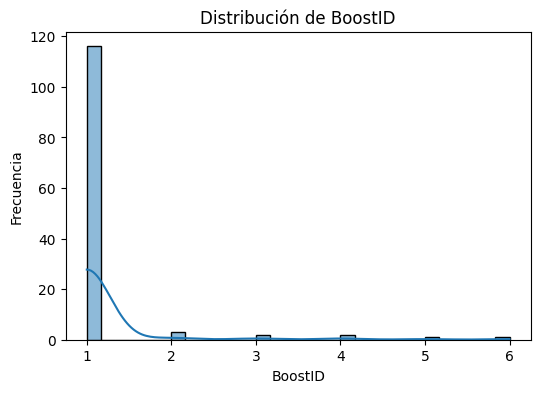

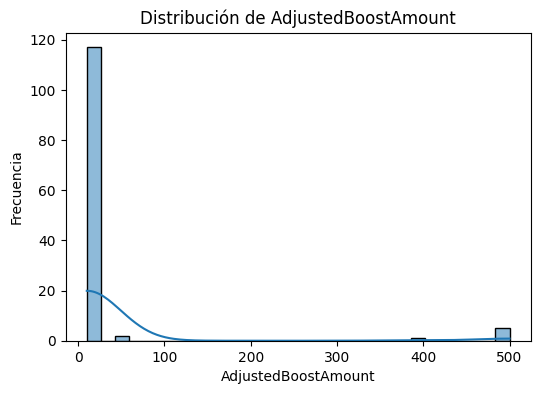

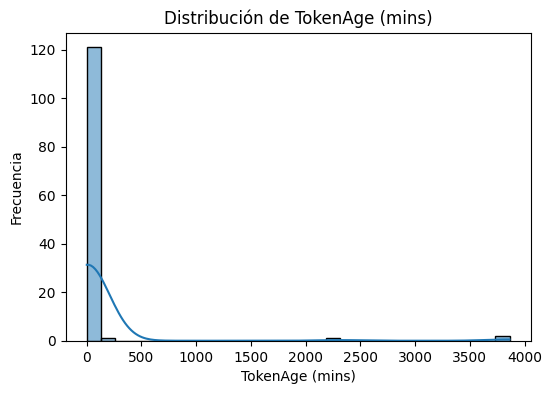

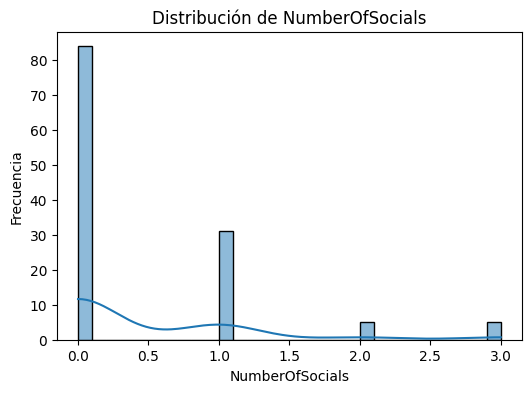

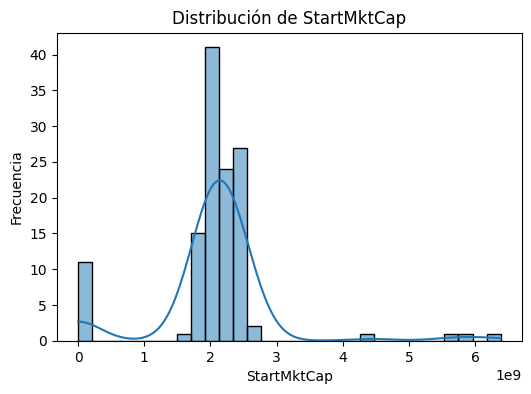

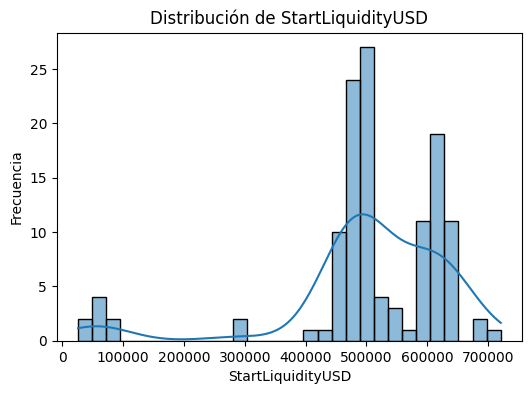

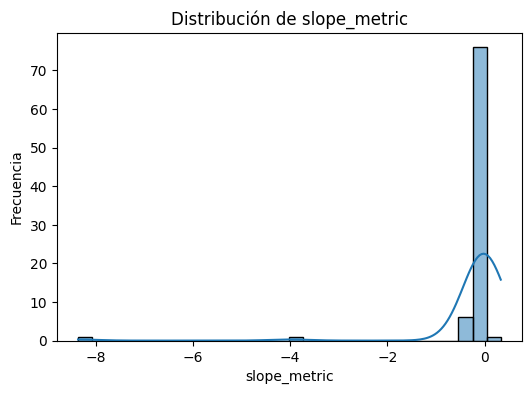

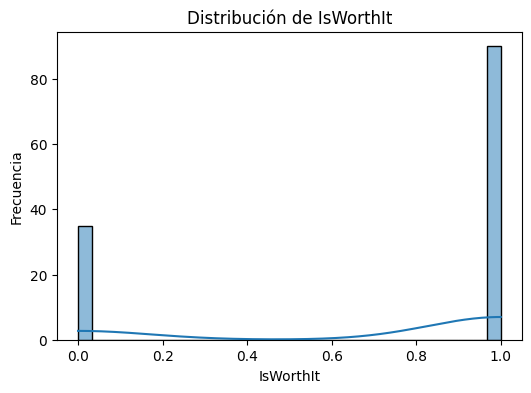

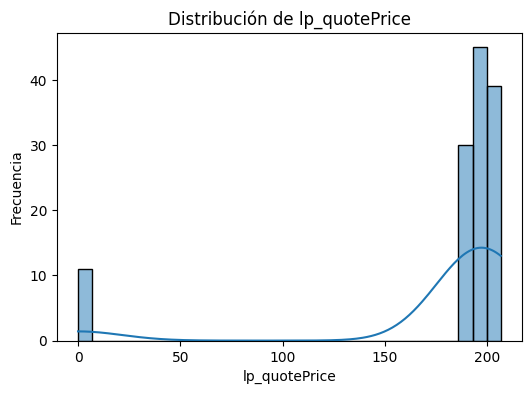

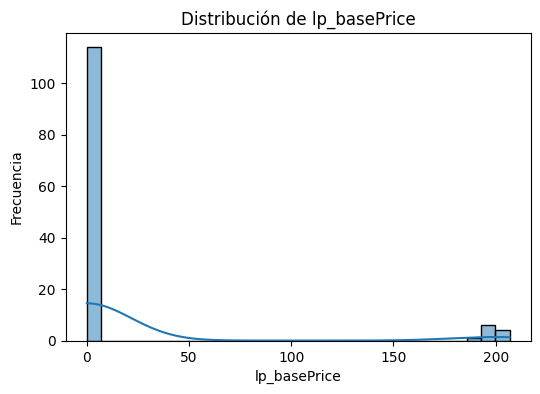

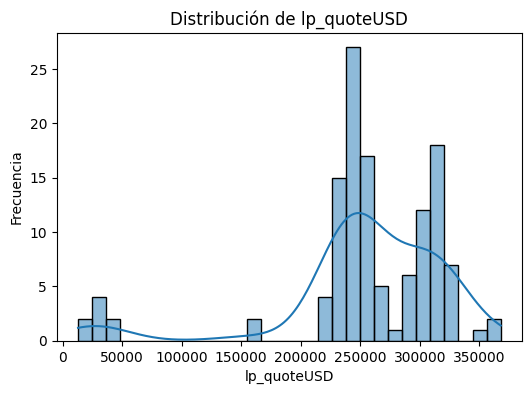

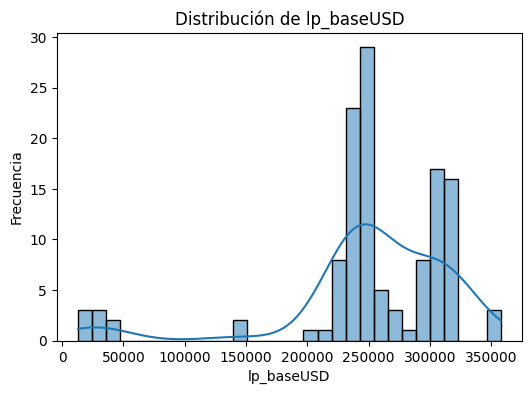

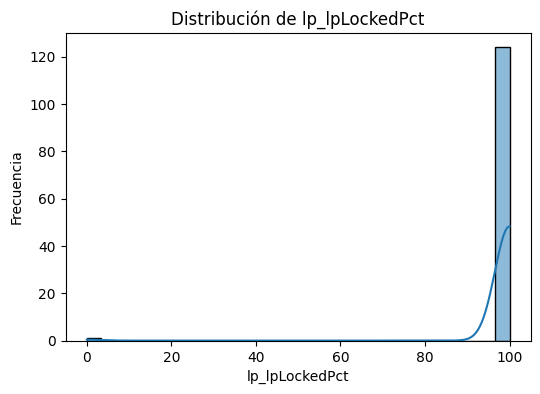

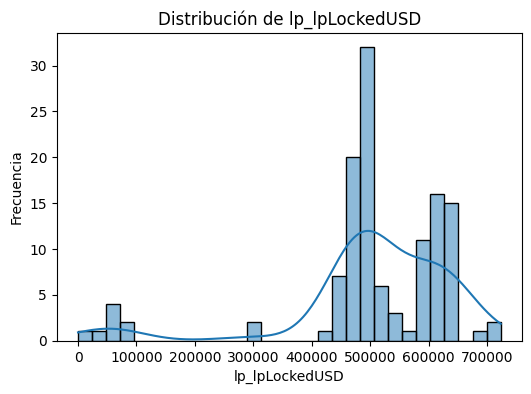

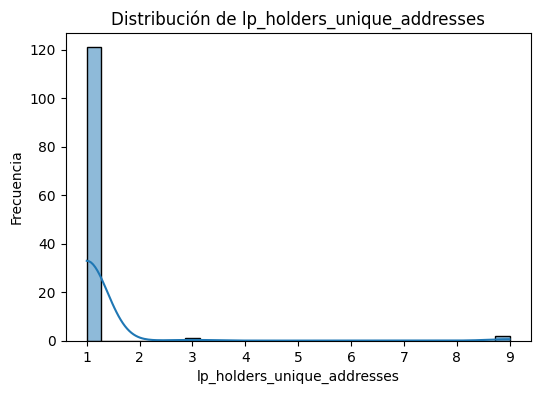

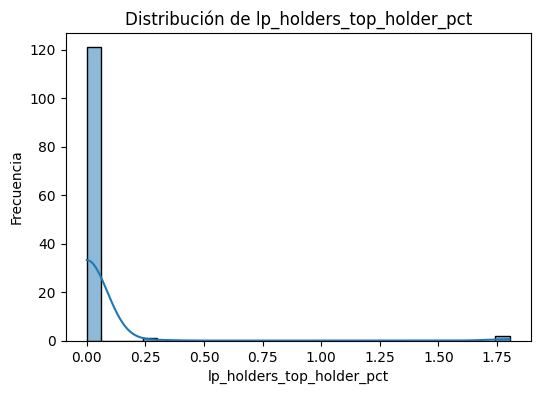

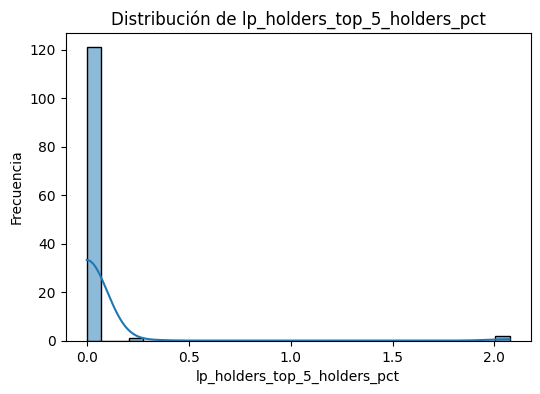

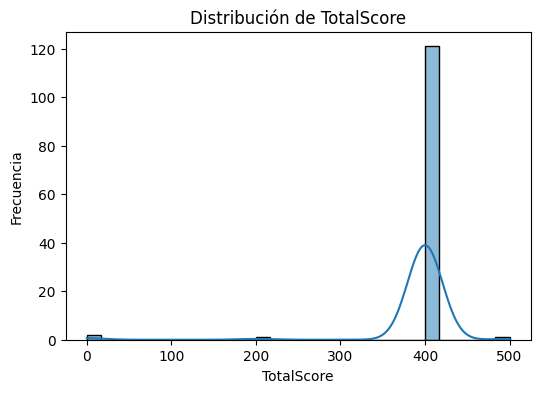

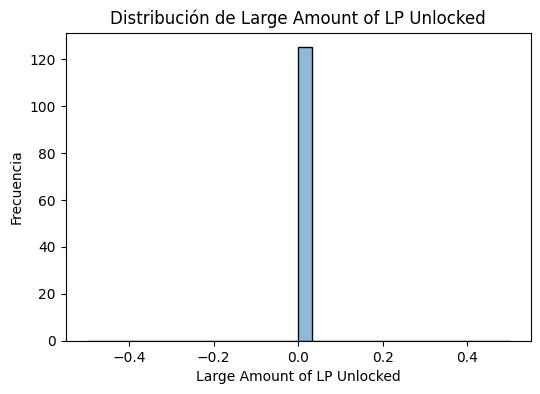

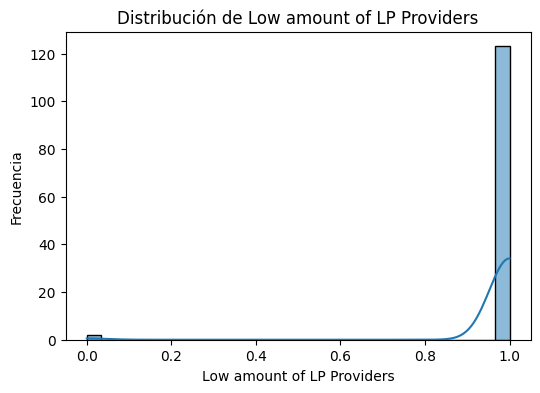

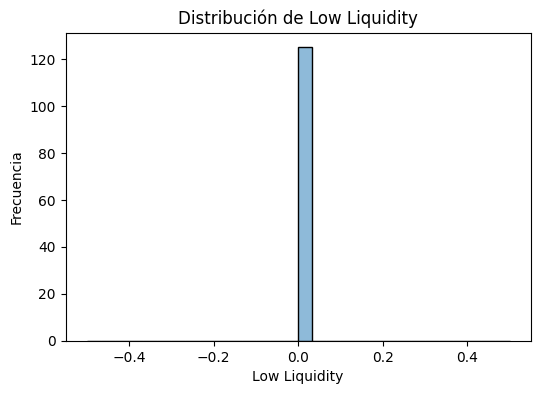

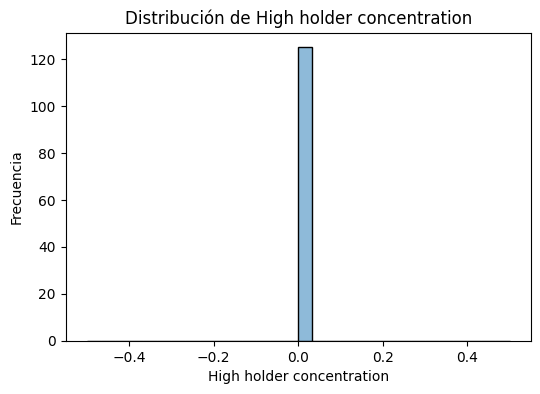

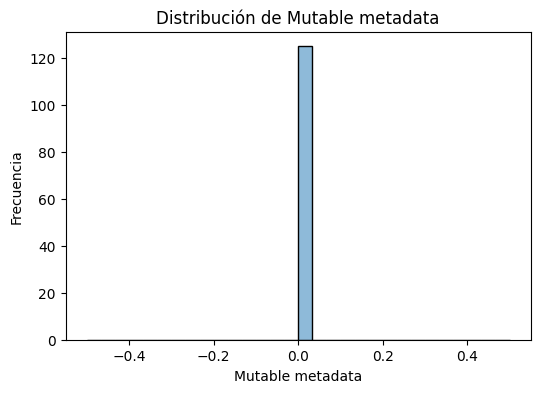

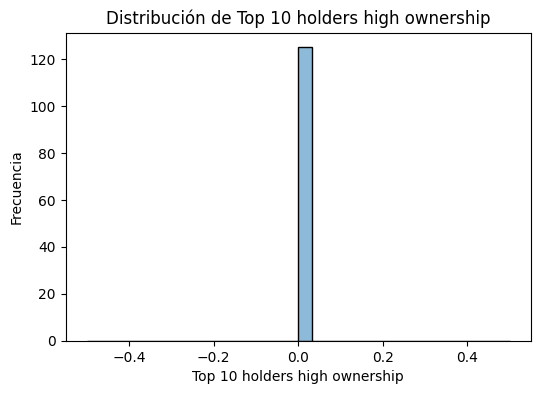

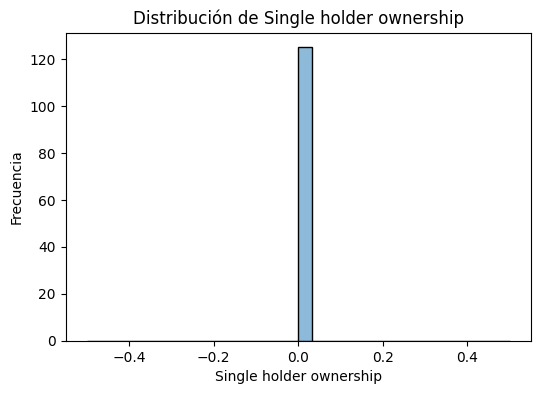

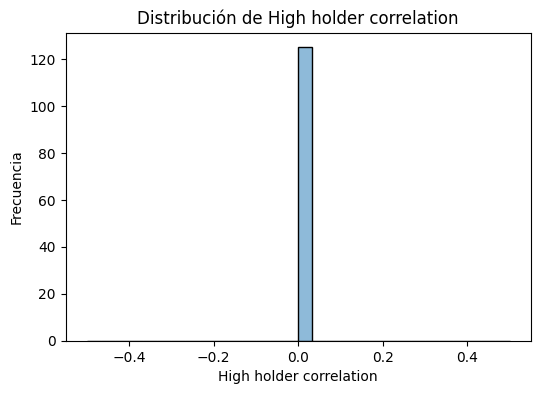

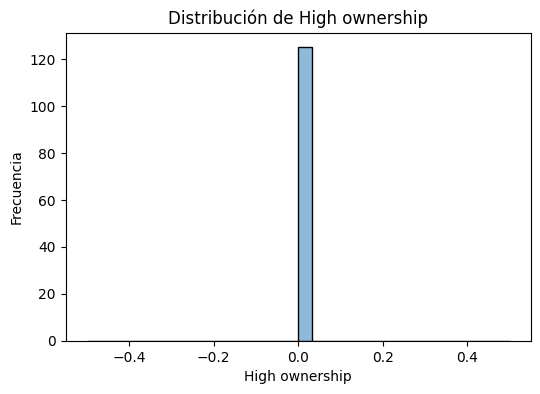

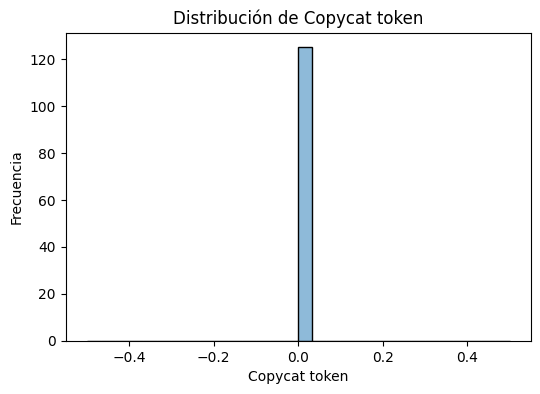

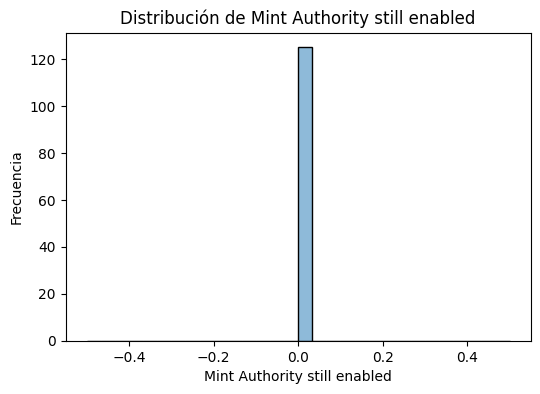

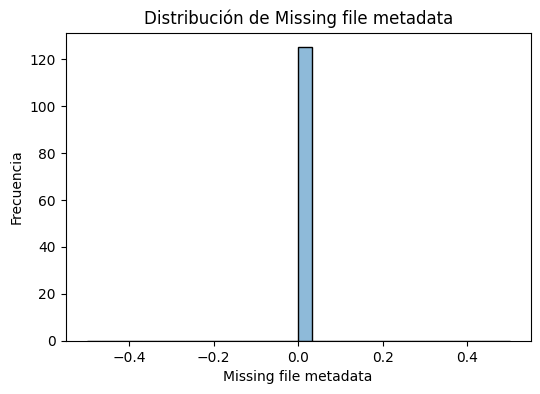

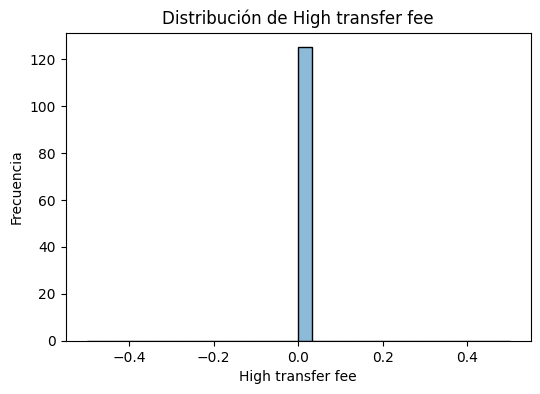

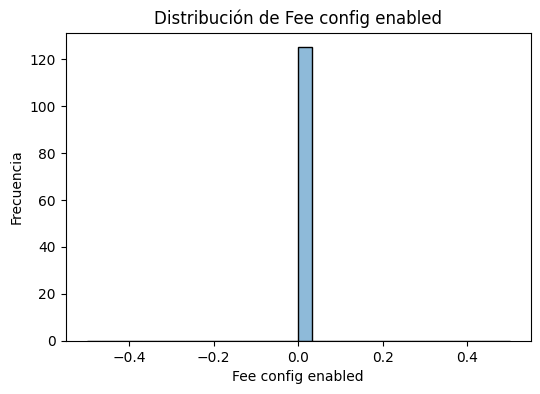

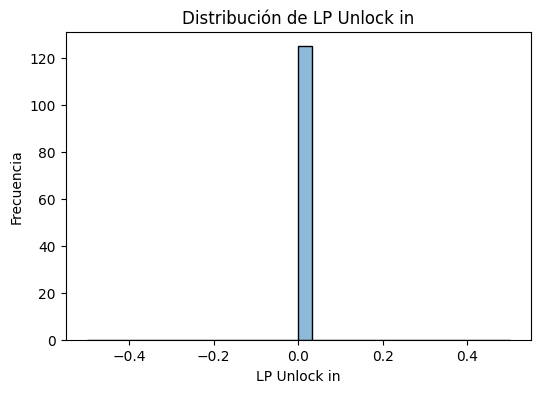

,count,mean,std,min,25%,50%,75%,max
BoostID,125.0,1.176000e+00,7.302673e-01,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00
AdjustedBoostAmount,125.0,3.328000e+01,1.016142e+02,10.000000,1.000000e+01,1.000000e+01,1.000000e+01,5.000000e+02
TokenAge (mins),125.0,8.982600e+01,5.233834e+02,1.783333,7.400000e+00,8.383333e+00,9.233334e+00,3.862450e+03
NumberOfSocials,125.0,4.480000e-01,7.562215e-01,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00
StartMktCap,125.0,2.068061e+09,9.185732e+08,43817.000000,1.950251e+09,2.088764e+09,2.347665e+09,6.383123e+09
StartLiquidityUSD,125.0,5.041939e+05,1.396413e+05,25844.000000,4.760920e+05,4.996990e+05,6.085920e+05,7.209960e+05
slope_metric,85.0,-1.777016e-01,1.002979e+00,-8.362874,-1.286320e-02,0.000000e+00,0.000000e+00,3.325429e-01
IsWorthIt,125.0,7.200000e-01,4.508057e-01,0.000000,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
lp_quotePrice,125.0,1.799447e+02,5.631333e+01,0.000044,1.920441e+02,1.964773e+02,2.012704e+02,2.067516e+02
lp_basePrice,125.0,1.756603e+01,5.678428e+01,0.000156,2.018830e-04,2.192812e-04,2.455361e-04,2.067934e+02


In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_token_feature_similarity(df):
    """
    Esta función analiza la similitud entre tokens a partir de sus valores en
    variables numéricas relacionadas con el precio y liquidez (provenientes de markets y precios),
    excluyendo aquellas columnas que contienen información de variación de precio y diferencias de tiempo.
    
    Se realizan los siguientes pasos:
      1. Selección de columnas numéricas excluyendo:
         - "max_price_variation (%)"
         - "min_price_variation (%)"
         - "final_variation (%)"
         - "trigger_time_diff (s)"
         - "max_price_time_diff (s)"
         - "min_price_time_diff (s)"
         
      2. Cálculo y muestra de un resumen estadístico de cada variable.
      3. Visualización de la distribución (histograma + KDE) de cada variable.
      4. Si el número de variables es razonable, se genera un pairplot para ver la dispersión entre pares.
    
    Esto te ayudará a detectar qué rangos se solapan y qué valores son característicos para cada variable,
    de forma que luego puedas configurar un filtro en tu bot.
    """
    # Definir las columnas a excluir
    exclude_cols = [
        "max_price_variation (%)",
        "min_price_variation (%)",
        "final_variation (%)",
        "trigger_time_diff (s)",
        "max_price_time_diff (s)",
        "min_price_time_diff (s)"
    ]
    
    # Seleccionar todas las columnas numéricas
    numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
    # Excluir las columnas de variación y tiempos
    selected_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    if not selected_cols:
        print("No se encontraron columnas numéricas tras excluir las de variación de precios y tiempos.")
        return None
    
    # 1. Resumen estadístico
    summary_stats = df[selected_cols].describe().T
    print("Resumen estadístico de las variables seleccionadas:")
    print(summary_stats)
    
    # 2. Visualización de histogramas para cada variable
    for col in selected_cols:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col].dropna(), kde=True, bins=30)
        plt.title(f"Distribución de {col}")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.show()
    
    # 3. Pairplot para ver la dispersión entre variables (si no hay demasiadas)
    if len(selected_cols) <= 10:
        sns.pairplot(df[selected_cols].dropna())
        plt.suptitle("Pairplot de variables seleccionadas", y=1.02)
        plt.show()
    
    return summary_stats

# Ejemplo de uso:
# summary = analyze_token_feature_similarity(mi_dataframe)


analyze_token_feature_similarity(final_data_rich)


In [27]:
def filter_core_tokens(final_data):
    filters = (final_data['TokenAge (mins)'] < 10) & \
              (final_data['StartMktCap'] >= 1000000000) & (final_data['StartMktCap'] <= 2000000000) & \
              (final_data['StartLiquidityUSD'] >= 450000) & (final_data['StartLiquidityUSD'] <= 620000) & \
              (final_data['AdjustedBoostAmount'] == 10) & \
              (final_data['TotalScore'] >= 380) & (final_data['TotalScore'] <= 400) & \
              (final_data['BoostID'] == 1)
    
    filtered_data = final_data[filters]
    return filtered_data

please_work = filter_core_tokens(final_data=final_data)

please_work

,TokenMint,BoostID,AdjustedBoostAmount,TokenAge (mins),TimeBoost,IsPump,NumberOfSocials,StartMktCap,StartLiquidityUSD,max_price_variation (%),...,Top 10 holders high ownership,Single holder ownership,High holder correlation,High ownership,Copycat token,Mint Authority still enabled,Missing file metadata,High transfer fee,Fee config enabled,LP Unlock in
43,26AAknygTqz5xHyzkdnbaKZAHk1w5RXQXnjiJihDstua,1,10,6.916667,2025-02-12 04:32:32,False,0,1970093516,481266,18.226866,...,0,0,0,0,0,0,0,0,0,0
132,2U5sVmgdR1zthqShLpmh8agw9cB8FU62F4BWMtBB8MEp,1,10,6.933333,2025-02-08 06:36:07,False,0,1916005337,468678,19.104670,...,0,0,0,0,0,0,0,0,0,0
190,2qTYpoKTM5jABwHRgMo4zfVsufrKfJG76zYNMBeujiuc,1,10,8.366667,2025-02-07 09:25:17,False,0,1950250774,476168,28.850157,...,0,0,0,0,0,0,0,0,0,0
264,3Fy7QQ62878xDnmLHLcu7ENJSETgqXS8Pm7VYARLtqhx,1,10,6.533333,2025-02-14 05:37:53,False,0,1983953364,483961,22.250816,...,0,0,0,0,0,0,0,0,0,0
286,3SvssPwT7iT19yNLMmi8B9oof5hHSFhjzxFPuRraixxd,1,10,8.633333,2025-02-12 00:16:00,False,0,1922033112,478561,23.397284,...,0,0,0,0,0,0,0,0,0,0
315,3Z7aasEPcSTruJErFBdpJRPyvEPWhKABXHRFcLxoqSpw,1,10,7.766667,2025-02-13 15:16:14,False,0,1990197954,476842,22.689959,...,0,0,0,0,0,0,0,0,0,0
431,46BGsg9Q24ou87yviPNZZb7bGtTZQTndUHJXo2DEAtzJ,1,10,5.833333,2025-02-11 05:40:15,False,0,1982471916,492501,18.628765,...,0,0,0,0,0,0,0,0,0,0
448,4BnWEQdKNHf5KVC5NaM7smY8L6JRZkusQyKn21x2bFDv,1,10,5.416667,2025-02-08 05:19:40,False,0,1901598866,469691,20.707006,...,0,0,0,0,0,0,0,0,0,0
552,4eB1BfQi5Ar52Jjd3itFcCNSTvKKTqBjfXzN5akNPLgi,1,10,6.350000,2025-02-07 07:34:52,False,0,1528573975,483474,55.659748,...,0,0,0,0,0,0,0,0,0,0
622,53hTy7hASc469WxjGm1u5dvqt5hSocufbZc1DrAw8XE1,1,10,9.283334,2025-02-11 22:40:57,False,1,1897089899,475994,28.157183,...,0,0,0,0,0,0,0,0,0,0


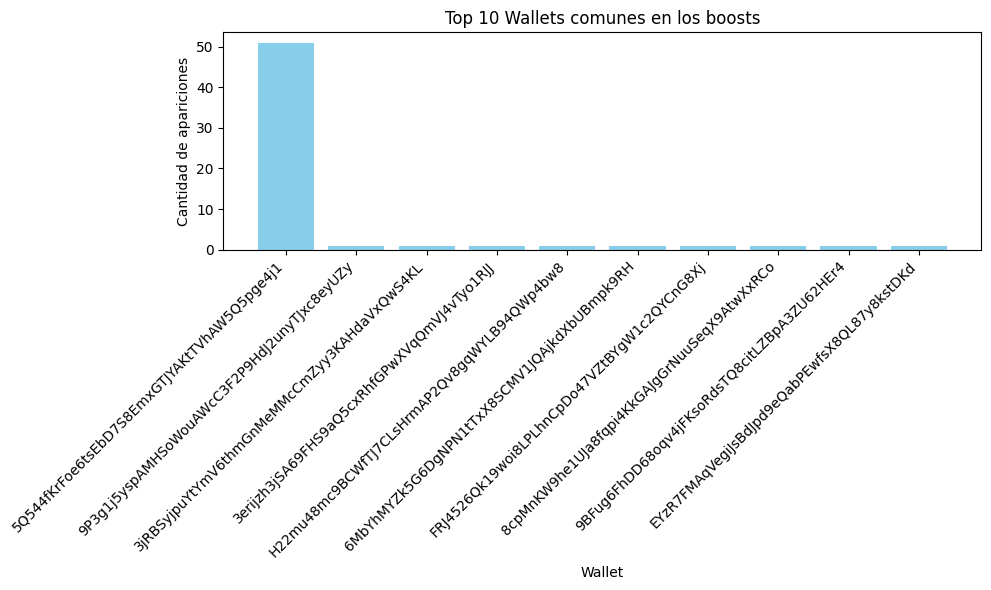

                                          Wallet  Count
51  5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1     51
0   9P3g1j5yspAMHSoWouAWcC3F2P9HdJ2unyTJxc8eyUZy      1
2   3jRBSyjpuYtYmV6thmGnMeMMcCmZyy3KAHdaVxQwS4KL      1
1   3erijzh3jSA69FHS9aQ5cxRhfGPwXVqQmVJ4vTyo1RJJ      1
4   H22mu48mc9BCWfTJ7CLsHrmAP2Qv8gqWYLB94QWp4bw8      1
5   6MbYhMYZk5G6DgNPN1tTxX8SCMV1JQAjkdXbUBmpk9RH      1
6   FRJ4526Qk19woi8LPLhnCpDo47VZtBYgW1c2QYCnG8Xj      1
7   8cpMnKW9he1UJa8fqpi4KkGAJgGrNuuSeqX9AtwXxRCo      1
8   9BFug6FhDD68oqv4jFKsoRdsTQ8citLZBpA3ZU62HEr4      1
9   EYzR7FMAqVegiJsBdJpd9eQabPEwfsX8QL87y8kstDKd      1
10  EgGtDe3LLok9CYZRGxwQppZjEPWbd5uKVUZcWzvxw3re      1
11  2jomqib9Q8NfyozdUt4VQpzvDwbHNxYbiq2bcywqi55U      1
12  J8JK9hGEMpXEzGyuMk6uzCUmLnZvwHE2Rc2hveRTLe5p      1
13  9bjwsUSAhKYa5bmpuga1jqYAdtfoQMespUUxZs9NqmhH      1
14  8CWv1KSfTZbXNPATLrjEp68oWyQ4YK3zTkynTQfiNEYU      1
15  2FPe9KiLVbFJCT3tGq95jra3UV8SAKX1cFnEZzfSDGNr      1
16  3bGgym7Rsd538HvmKBchSC1Hmj6c5JY48xmKeGfmGuYW

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

def find_common_wallets(df, top_n=10):
    """
    Esta función analiza las columnas de direcciones para identificar wallets comunes entre los tokens.
    Se buscan coincidencias en:
      - 'lp_holders_addresses': cadena con direcciones separadas por comas.
      - 'lp_liquidity_owner': el propietario principal de la liquidez.
    
    Retorna un DataFrame con cada wallet y la cantidad de veces que aparece, ordenado de mayor a menor.
    Además, muestra un gráfico de barras con las top_n wallets.
    """
    wallet_counts = {}

    # Procesar la columna 'lp_holders_addresses'
    if 'lp_holders_addresses' in df.columns:
        for addresses in df['lp_holders_addresses'].dropna():
            # Separar la cadena por comas y quitar espacios
            addr_list = [addr.strip() for addr in addresses.split(',') if addr.strip()]
            for addr in addr_list:
                wallet_counts[addr] = wallet_counts.get(addr, 0) + 1

    # Procesar la columna 'lp_liquidity_owner'
    if 'lp_liquidity_owner' in df.columns:
        for owner in df['lp_liquidity_owner'].dropna():
            owner = str(owner).strip()
            if owner:
                wallet_counts[owner] = wallet_counts.get(owner, 0) + 1

    # Convertir el diccionario a DataFrame y ordenar por el recuento
    wallet_df = pd.DataFrame(list(wallet_counts.items()), columns=['Wallet', 'Count'])
    wallet_df = wallet_df.sort_values(by='Count', ascending=False)

    # Graficar las top_n wallets
    plt.figure(figsize=(10, 6))
    top_wallets = wallet_df.head(top_n)
    plt.bar(top_wallets['Wallet'], top_wallets['Count'], color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Wallet")
    plt.ylabel("Cantidad de apariciones")
    plt.title(f"Top {top_n} Wallets comunes en los boosts")
    plt.tight_layout()
    plt.show()

    return wallet_df

# Ejemplo de uso:
common_wallets = find_common_wallets(please_work, top_n=10)
print(common_wallets)

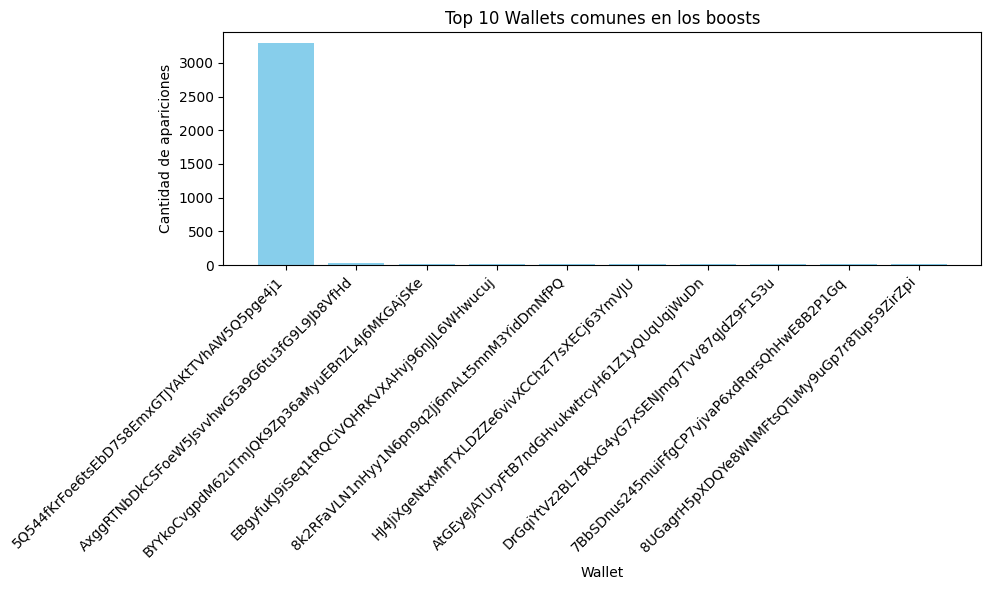

                                            Wallet  Count
2998  5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1   3288
2341  AxggRTNbDkCSFoeW5JsvvhwG5a9G6tu3fG9L9Jb8VfHd     27
939   BYYkoCvgpdM62uTmJQK9Zp36aMyuEBnZL4J6MKGAjSKe     21
810   EBgyfuKJ9iSeq1tRQCiVQHRKVXAHvj96nJJL6WHwucuj     20
2891   8k2RFaVLN1nHyy1N6pn9q2Jj6mALt5mnM3YidDmNfPQ     19
...                                            ...    ...
2953  BaGsNqmHLj2ro8xo1cRuuzh8qc8f1pDbPrfv2kGScedp      1
2952  AmeTtDTiGmzTqMTmYhJM55jTToWYu95hShFnpNe99THi      1
2951  Hhxf3rVdG3wN2o2ERzi4b3FSxpukdzfKpRhyc2AZB8Bi      1
16    3uCrSrpY8zhJefq51eH5mnxBBHE2Kobp7dTGfH6GdcxX      1
3     DemAf95MGH2ETV7EpEW7MK8BFiNuh1joJvrPUox25C1i      1

[2999 rows x 2 columns]


In [29]:
common_wallets_2 = find_common_wallets(final_data, top_n=10)
print(common_wallets_2)

In [30]:
please_work['IsWorthIt'].mean()

np.float64(0.6666666666666666)

## *3.6. Comprobando resultados filtro antiguo*

In [31]:
filters = (final_data['TokenAge (mins)'] < 10) & \
          (final_data['StartMktCap'] > 100000) & \
          (final_data['StartLiquidityUSD'] > 40000) & \
          (final_data['AdjustedBoostAmount'] >= 200) & \
          (final_data['TotalScore'] < 1000) & \
          (final_data['BoostID'] == 1)

filtered_data = final_data[filters]

filtered_data[['TokenMint', 'BoostID', 'AdjustedBoostAmount', 'TokenAge (mins)', 'IsPump', 'NumberOfSocials', 'StartMktCap', 'StartLiquidityUSD', 'TotalScore',
               'max_price_variation (%)', 'min_price_variation (%)', 'final_variation (%)', 'trigger_signal', 'trigger_time_diff (s)', 'max_price_time_diff (s)',
               'min_price_time_diff (s)']]

,TokenMint,BoostID,AdjustedBoostAmount,TokenAge (mins),IsPump,NumberOfSocials,StartMktCap,StartLiquidityUSD,TotalScore,max_price_variation (%),min_price_variation (%),final_variation (%),trigger_signal,trigger_time_diff (s),max_price_time_diff (s),min_price_time_diff (s)
243,3ALHT6WfDgjQBTxYvTvEWSJfHDSkgCEzYrsmifGbpump,1,500,5.400000,True,3,165330,46955,400,-0.010006,-55.638962,-34.188301,SL,132,9,831
265,3GsqZXf5DP1pwW7ZoQ16pw6dtbwc9haNwuEaaWc8pump,1,500,3.950000,True,3,144213,43347,400,9.024018,-22.658867,-11.741803,None,1000,778,86
426,45uRPQ2ktFFXQEtnSpABbgZo2o4QZ2UU62hQXrZgpump,1,500,7.416667,True,2,152577,47079,400,24.512438,-21.117645,24.512438,None,1000,999,203
453,4CQJwTSHvLt2HNWsiXkYBf9N5fED4N2R6AK2QPWYpump,1,500,5.850000,True,2,132153,43076,400,3.140495,-88.633224,-31.126768,SL,832,47,997
457,4D93YgrLrps12ZjM8uAT7k3mEFP7X5DkjyzTu9ftpump,1,500,2.783333,True,3,146430,45331,400,8.411657,-28.878439,4.127169,None,1000,838,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3593,wq98CvTqZCmM6suvyBXUKjCBWJBeAJJbKxt1pr2pump,1,500,3.916667,True,0,146919,43723,400,45.141384,-94.037537,-92.941170,SL,413,106,424
3605,xVPYVqLbomaf2t2KWE4xDEXwrPm89HvZHnhno1wpump,1,500,9.616667,True,0,320243,65771,400,9.946330,-52.243267,-52.243267,SL,834,68,834
3612,yYffzr4HFYB3T6nVWXSkGag6JKpZ2Dio7kWUtf3pump,1,500,5.633333,True,1,133470,41147,400,52.520668,-96.448174,-77.117867,SL,946,760,987
3613,ykPcmFuaN3JhRsbBxu83t3QN7w9EDFqJiutQ8mKpump,1,500,4.366667,True,0,140462,42792,400,18.581341,-93.985718,-93.273651,SL,349,308,585


In [32]:
filtered_data['trigger_signal'].value_counts()

trigger_signal
None    24
SL      20
TP      19
Name: count, dtype: int64

In [33]:
filtered_data.to_csv('data/output_data/filtered_data.csv')

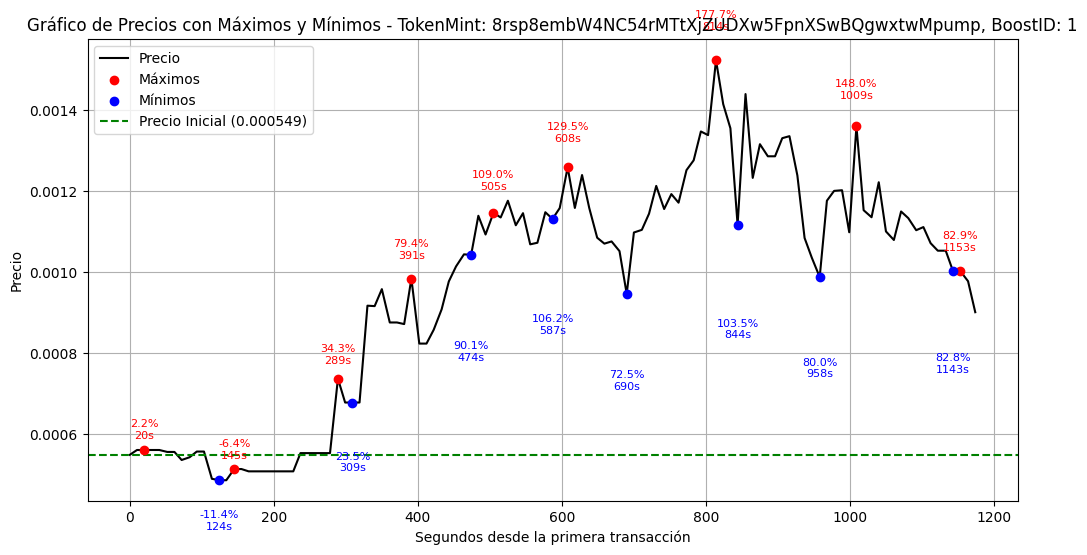

In [34]:
from scipy.signal import find_peaks

def plot_with_peaks_by_token_mint(token_df, token_mint, boost_id, distance):
    """
    Genera un gráfico de precios con máximos y mínimos locales y añade etiquetas de porcentaje para los máximos y mínimos.

    Args:
        token_df (pd.DataFrame): DataFrame consolidado con los datos.
        token_mint (str): Identificador del token a graficar.
        boost_id (int): ID del boost específico.
        distance (int): Distancia mínima en puntos entre los máximos/mínimos locales.
    """
    filtered_df = token_df[(token_df['TokenMint'] == token_mint) & (token_df['BoostID'] == boost_id)].sort_values(by='TimeSinceBoostStart')

    if filtered_df.empty:
        print(f"No se encontraron datos para TokenMint: {token_mint} y BoostID: {boost_id}")
        return

    time_diff = filtered_df['TimeSinceBoostStart']
    prices = filtered_df['Price']

    peaks, _ = find_peaks(prices, distance=distance)
    troughs, _ = find_peaks(-prices, distance=distance)

    initial_price = prices.iloc[0]
    percentage_increase = ((prices.iloc[peaks] - initial_price) / initial_price) * 100
    percentage_decrease = ((prices.iloc[troughs] - initial_price) / initial_price) * 100

    plt.figure(figsize=(12, 6))
    plt.plot(time_diff, prices, label='Precio', color='black')
    plt.scatter(time_diff.iloc[peaks], prices.iloc[peaks], color='red', label='Máximos', zorder=5)
    plt.scatter(time_diff.iloc[troughs], prices.iloc[troughs], color='blue', label='Mínimos', zorder=5)

    plt.axhline(y=initial_price, color='green', linestyle='--', label=f"Precio Inicial ({initial_price:.6f})")

    for i, peak in enumerate(peaks):
        plt.text(
            time_diff.iloc[peak], prices.iloc[peak] * 1.05,
            f"{percentage_increase.iloc[i]:.1f}%\n{int(time_diff.iloc[peak])}s",
            color="red", fontsize=8, ha="center"
        )

    for i, trough in enumerate(troughs):
        plt.text(
            time_diff.iloc[trough], prices.iloc[trough] * 0.75,
            f"{percentage_decrease.iloc[i]:.1f}%\n{int(time_diff.iloc[trough])}s",
            color="blue", fontsize=8, ha="center"
        )

    plt.title(f"Gráfico de Precios con Máximos y Mínimos - TokenMint: {token_mint}, BoostID: {boost_id}")
    plt.xlabel("Segundos desde la primera transacción")
    plt.ylabel("Precio")
    plt.legend()
    plt.grid()
    plt.show()


plot_with_peaks_by_token_mint(price_evo_boost, '8rsp8embW4NC54rMTtXjZUDXw5FpnXSwBQgwxtwMpump', 1, distance=10)

# 4. Data antigua

In [35]:
data_ant = pd.read_csv("data/AnalysisDex3.txt", sep=',')
data_ant.head()

,id,Time,CreatedAt,NumberOfSocials,BoostAmount,TokenName,StartPrice,StartMktCap,StartLiquidity,IsPump,TokenMint,Risks,PriceHistory
0,1,2025-01-03T14:11:43.521+01:00,2025-01-02T18:35:19.000+01:00,2,30,DOGIUS MAXIMUS,0.000027,26988,"{""usd"":6646.44,""base"":123081949,""quote"":15.5511}",0,HmJ5ospo7my38GhCSApxc32BnQZMmdS3PwkD1fnto8RK,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.00002723038863479164\"",\""time..."
1,2,2025-01-03T14:13:19.090+01:00,2025-01-03T14:08:59.000+01:00,0,10,ZAILGO,0.005078,507832441,"{""usd"":209115.57,""base"":20614613,""quote"":487.7...",0,EcwoHuB1zH1su46AV6Z2XU27CTbMW1Fn4PjZJDcqvEF9,"[{""Name"":""Large Amount of LP Unlocked"",""Descri...","""[{\""price\"":\""0.005347783152681791\"",\""time\""..."
2,3,2025-01-03T14:19:12.988+01:00,2025-01-03T14:11:25.000+01:00,2,10,Dogius Maximus,0.000127,127233,"{""usd"":42143.15,""base"":165500590,""quote"":99.06...",1,5ABhEwJgZLeQxyB25z88nFbHjjm1LJEs8iDJ2CSmpump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.00012723313541830708\"",\""time..."
3,4,2025-01-03T14:20:18.348+01:00,2025-01-03T13:47:41.000+01:00,2,500,Keir Starmer,0.000195,195194,"{""usd"":54779.73,""base"":140497220,""quote"":128.5...",1,BiTbpHw253ceCPXke9k1uFSzjFhoqjdobVemLq6pump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.00020345715042533727\"",\""time..."
4,5,2025-01-03T14:21:23.858+01:00,2025-01-03T11:04:14.000+01:00,2,50,CHIZZLER,0.000056,55813,"{""usd"":28954.05,""base"":257793281,""quote"":68.5105}",1,7C6DYeYFZRUjysPeHTVEsopxkXynNNz9sskjBwUspump,"[{""Name"":""Low amount of LP Providers"",""Descrip...","""[{\""price\"":\""0.000053050589716867185\"",\""tim..."


In [36]:
data_antigua = process_boost_data(data_ant)
data_antigua.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3516 entries, 0 to 3515
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Time                 3516 non-null   object        
 1   CreatedAt            3516 non-null   datetime64[ns]
 2   NumberOfSocials      3516 non-null   int64         
 3   BoostAmount          3516 non-null   int64         
 4   TokenName            3516 non-null   object        
 5   StartPrice           3516 non-null   float64       
 6   StartMktCap          3516 non-null   int64         
 7   StartLiquidity       3516 non-null   object        
 8   IsPump               3516 non-null   int64         
 9   TokenMint            3516 non-null   object        
 10  Risks                3516 non-null   object        
 11  PriceHistory         3516 non-null   object        
 12  BoostID              3516 non-null   int64         
 13  AdjustedBoostAmount  3516 non-nul

In [37]:
price_evo_antigua = parse_to_flat_format_optimized_with_boundaries(data_antigua)

C:\Users\Laú\AppData\Local\Temp\ipykernel_12596\2216473275.py:127: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(determine_decision)


In [38]:
price_metrics_antigua = prepare_and_simulate_boosts_with_metrics(price_evo_antigua, stop_loss = -20, take_profit = 60, max_time_diff = 2000, slippage = 0.0001)

In [39]:
price_metrics_antigua

,TokenMint,BoostID,AdjustedBoostAmount,TokenAge (mins),BoostTime,IsPump,NumberOfSocials,StartMktCap,StartLiquidityUSD,max_price_variation (%),min_price_variation (%),final_variation (%),trigger_signal,trigger_time_diff (s),max_price_time_diff (s),min_price_time_diff (s),slope_metric
0,127LNZfN3PbnkRfPdNgSdAFHW2duWZ6nXfQHnCjopump,1,10,10080.183594,2025-01-06 03:28:55,True,3,7236,11160,0.294305,-0.010003,0.294305,None,2000,331,9,0.0
1,12SDbC7Qfkm6PRf2suETXAH2AggSKr3mRNajXJq5ZqA4,1,10,6.816667,2025-01-08 11:08:26,False,1,5756226821,674543,6.542396,-100.000000,-94.930923,SL,601,580,938,-4.535343
2,12XbSPVc5hmWjKUzf5ExTysM2pEL3tM953YkMXmLWkGd,1,500,16842.716797,2025-01-04 16:52:38,False,1,13339577,363352,28.475424,-0.113494,25.946293,None,2000,1361,27,-0.043225
3,12XbSPVc5hmWjKUzf5ExTysM2pEL3tM953YkMXmLWkGd,2,500,16864.517578,2025-01-04 17:14:26,False,1,15814193,396267,3.703325,-3.186773,-2.833299,None,2000,53,1451,-0.043225
4,12XbSPVc5hmWjKUzf5ExTysM2pEL3tM953YkMXmLWkGd,3,500,16865.050781,2025-01-04 17:14:58,False,1,15727364,395178,0.950914,-5.756312,-5.412219,None,2000,21,1419,-0.043225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3400,z1P4bzKNxJwzgmRYDLX2y5UjK1tbHs816nSndD2Pmog,1,50,14.733334,2025-01-09 15:25:20,False,3,23823,7518,35.265873,-72.800377,-24.182758,SL,50,1107,1976,-0.099489
3401,z3d8PNyqv12BRr9EHkfcgQECPJQHHyLGFqrMybEpump,1,30,69.616669,2025-01-03 22:43:31,True,3,33870,22263,26.619894,-34.437351,-20.740408,SL,1516,853,1723,0.0
3402,zZxKYWvPm669u65hKq6FQaBT87RjXqVhE7HjEhApump,1,10,846.616638,2025-01-05 20:43:07,True,3,33582,22902,-0.010000,-7.622222,-5.523579,None,2000,1,1449,0.0
3403,zdpvqCsVFvPVfVN5SZFNRfymZqmrEjuTXoPDi3YDpZe,1,10,25.333334,2025-01-10 22:19:39,False,3,31800,7054,39.216019,-6.288431,2.766946,None,2000,775,124,-0.343771


In [40]:
risks_df_antigua = create_risks_dummies(data_antigua, risks_column = 'Risks', index_column = 'TokenMint', time_column='Time') 

In [41]:
df_prices_antigua = assign_worthit(price_metrics_antigua)


df_prices_antigua['IsWorthIt'].mean()

np.float64(0.41145374449339206)

In [42]:
risks_df_antigua['BoostID'] = risks_df_antigua['BoostID'].astype(int)
df_prices_antigua['BoostID'] = df_prices_antigua['BoostID'].astype(int)

# Asegurar que los TokenMint son str

risks_df_antigua['TokenMint'] = risks_df_antigua['TokenMint'].astype(str)
df_prices_antigua['TokenMint'] = df_prices_antigua['TokenMint'].astype(str)

# Realizar el merge empezando por price_evo ya que es el que tiene menos filas y nos interesa la variable worthit

df_merged_antigua = df_prices_antigua.merge(risks_df_antigua, on=['TokenMint', 'BoostID'], how='left')

In [43]:
pls_man = df_merged_antigua[(df_merged_antigua['TokenAge (mins)'] < 30) & \
              (df_merged_antigua['StartMktCap'] >= 1.8e9) & (df_merged_antigua['StartMktCap'] <= 2.5e9) & \
              (df_merged_antigua['StartLiquidityUSD'] >= 450000) & (df_merged_antigua['StartLiquidityUSD'] <= 620000) & \
              (df_merged_antigua['AdjustedBoostAmount'] == 10) & \
              (df_merged_antigua['TotalScore'] >= 380) & (df_merged_antigua['TotalScore'] <= 400) & \
              (df_merged_antigua['BoostID'] == 1)]

In [44]:
pls_man

,TokenMint,BoostID,AdjustedBoostAmount,TokenAge (mins),BoostTime_x,IsPump,NumberOfSocials,StartMktCap,StartLiquidityUSD,max_price_variation (%),...,Top 10 holders high ownership,Single holder ownership,High ownership,Low Liquidity,High holder concentration,High transfer fee,Fee config enabled,LP Unlock in,Mint Authority still enabled,Missing file metadata


In [45]:
antigua_rich_pls_man = filter_core_tokens(df_merged_antigua)

antigua_rich_pls_man

,TokenMint,BoostID,AdjustedBoostAmount,TokenAge (mins),BoostTime_x,IsPump,NumberOfSocials,StartMktCap,StartLiquidityUSD,max_price_variation (%),...,Top 10 holders high ownership,Single holder ownership,High ownership,Low Liquidity,High holder concentration,High transfer fee,Fee config enabled,LP Unlock in,Mint Authority still enabled,Missing file metadata


In [46]:
final_data_antigua = df_merged_antigua.copy()
final_data_antigua.drop(columns=['max_price_variation (%)', 'min_price_variation (%)',
       'final_variation (%)', 'trigger_signal', 'trigger_time_diff (s)',
       'max_price_time_diff (s)', 'min_price_time_diff (s)', 'slope_metric', 'BoostTime_y'], inplace=True)
final_data_antigua.rename(columns={'BoostTime_x': 'TimeBoost'}, inplace=True)


In [47]:
final_df = pd.concat([final_data_antigua, final_data], axis=0)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7026 entries, 0 to 3620
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   TokenMint                      7026 non-null   object        
 1   BoostID                        7026 non-null   int64         
 2   AdjustedBoostAmount            7026 non-null   int32         
 3   TokenAge (mins)                7026 non-null   float32       
 4   TimeBoost                      7026 non-null   datetime64[ns]
 5   IsPump                         7026 non-null   bool          
 6   NumberOfSocials                7026 non-null   int8          
 7   StartMktCap                    7026 non-null   int64         
 8   StartLiquidityUSD              7026 non-null   int64         
 9   IsWorthIt                      7026 non-null   int64         
 10  TotalScore                     7026 non-null   int64         
 11  Low amount of LP Provi

# *5. Entrenando modelo.*


## *5.1. Preparando data con pd.concat* 

In [48]:
df_numeric = final_df
df_numeric

,TokenMint,BoostID,AdjustedBoostAmount,TokenAge (mins),TimeBoost,IsPump,NumberOfSocials,StartMktCap,StartLiquidityUSD,IsWorthIt,...,lp_quotePrice,lp_basePrice,lp_quoteUSD,lp_baseUSD,lp_lpLockedPct,lp_lpLockedUSD,lp_holders_unique_addresses,lp_holders_top_holder_pct,lp_holders_top_5_holders_pct,lp_holders_addresses
0,127LNZfN3PbnkRfPdNgSdAFHW2duWZ6nXfQHnCjopump,1,10,10080.183594,2025-01-06 03:28:55,True,3,7236,11160,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12SDbC7Qfkm6PRf2suETXAH2AggSKr3mRNajXJq5ZqA4,1,10,6.816667,2025-01-08 11:08:26,False,1,5756226821,674543,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12XbSPVc5hmWjKUzf5ExTysM2pEL3tM953YkMXmLWkGd,1,500,16842.716797,2025-01-04 16:52:38,False,1,13339577,363352,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12XbSPVc5hmWjKUzf5ExTysM2pEL3tM953YkMXmLWkGd,2,500,16864.517578,2025-01-04 17:14:26,False,1,15814193,396267,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12XbSPVc5hmWjKUzf5ExTysM2pEL3tM953YkMXmLWkGd,3,500,16865.050781,2025-01-04 17:14:58,False,1,15727364,395178,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3616,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,2,100,8.983334,2025-02-03 19:52:35,True,3,356358,70448,0,...,0.000318,211.716034,31591.553866,35097.419838,100.0,66688.973704,1.0,0.0,0.0,2yyGqk2HQBbAFcWjYpYwwUPLpdoJgdEoVSZJ31cCxKAf
3617,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,3,500,25.150000,2025-02-03 20:08:45,True,3,333319,68788,1,...,0.000339,212.254990,33958.531776,35556.009347,100.0,69514.541123,1.0,0.0,0.0,2yyGqk2HQBbAFcWjYpYwwUPLpdoJgdEoVSZJ31cCxKAf
3618,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,4,100,27.283333,2025-02-03 20:10:53,True,3,370335,72566,1,...,0.000357,211.843522,34584.859511,36739.846476,100.0,71324.705987,1.0,0.0,0.0,2yyGqk2HQBbAFcWjYpYwwUPLpdoJgdEoVSZJ31cCxKAf
3619,zizzqUreKbQWpbYsQ35fD18WE9KpdSES8oJqvrZpump,1,10,1.983333,2025-02-11 10:47:11,True,0,80538,32700,1,...,0.000084,203.308188,16790.708324,16545.812369,100.0,33336.520693,1.0,0.0,0.0,FX1BUhAKhqXuiJ4x2g1z4EggctsyKoUafnYCVUgN9C9z


## *5.2. Método 1. Cross-validation con XGBoost*

Parece ser que aún hay poca data para que este modelo pueda exprimir todo su potencial

In [49]:
import pandas as pd
import numpy as np

# Preprocesado y splitting
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Métricas de clasificación
from sklearn.metrics import classification_report

# XGBoost
from xgboost import XGBClassifier


# Columnas numéricas
numeric_cols = [
    'AdjustedBoostAmount', 
    'TokenAge (mins)', 
    'NumberOfSocials', 
    'StartMktCap', 
    'StartLiquidityUSD', 
    'TotalScore'
]

# Columnas binarias
binary_cols = [
    'IsPump',
    'Low amount of LP Providers',
    'High holder correlation',
    'Mutable metadata',
]

# Unimos las features en X
X = df_numeric[numeric_cols + binary_cols].copy()
y = df_numeric["IsWorthIt"].copy()

# Cantidad total de filas
n_total = len(df_numeric)
# Calcular cuántas filas corresponderán al 80%
n_train = int(n_total * 0.8)

# Separamos (0 : n_train) como training, (n_train : end) como test hold-out
X_train_hold = X.iloc[:n_train].copy()
y_train_hold = y.iloc[:n_train].copy()

X_test_hold = X.iloc[n_train:].copy()
y_test_hold = y.iloc[n_train:].copy()

print("Tamaño training:", len(X_train_hold))
print("Tamaño test hold-out:", len(X_test_hold))

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

binary_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('bin', binary_transformer, binary_cols)
], remainder='drop')

xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='aucpr',  # o 'aucpr'
    scale_pos_weight=5.0,   # ajusta si la clase 1 es minoritaria
    random_state=42
)

pipe = Pipeline([
    ('prep', preprocessor),
    ('clf', xgb_clf)
])

tss = TimeSeriesSplit(n_splits=3)

param_dist = {
    'clf__n_estimators': [100, 300, 500, 700, 1000],
    'clf__max_depth': [3, 4, 5, 6, 7, 8],
    'clf__learning_rate': [0.005, 0.01, 0.02, 0.05, 0.1, 0.2],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__gamma': [0, 1, 5],
    'clf__reg_alpha': [0, 0.5, 1, 2],
    'clf__reg_lambda': [1, 2, 5, 10],
    # Opcional: 'clf__scale_pos_weight': [1, 2, 3, 4]
}

rs_cv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=250,             # número de combinaciones
    scoring='precision',    # o 'f1', 'average_precision'...
    cv=tss,                 # validación temporal en el 80%
    random_state=42,
    verbose=1,
    n_jobs=-1
)


Tamaño training: 5620
Tamaño test hold-out: 1406


*Entrenar el modelo*

In [50]:
rs_cv.fit(X_train_hold, y_train_hold)

print("\nBest Score from CV:", rs_cv.best_score_)
print("Best params:", rs_cv.best_params_)

best_model = rs_cv.best_estimator_




Fitting 3 folds for each of 250 candidates, totalling 750 fits


c:\Python\my_projects\dexboost\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:32:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Score from CV: 0.506984638383293
Best params: {'clf__subsample': 0.6, 'clf__reg_lambda': 2, 'clf__reg_alpha': 1, 'clf__n_estimators': 700, 'clf__max_depth': 8, 'clf__learning_rate': 0.2, 'clf__gamma': 0, 'clf__colsample_bytree': 0.6}


*Validar el modelo*

In [51]:
y_test_proba = best_model.predict_proba(X_test_hold)[:, 1]
for threshold in [0.7]:
    y_test_pred_adj = (y_test_proba >= threshold).astype(int)
    print(f"\nThreshold = {threshold}")
    print(classification_report(y_test_hold, y_test_pred_adj))



Threshold = 0.7
              precision    recall  f1-score   support

           0       0.65      0.62      0.64       793
           1       0.54      0.56      0.55       613

    accuracy                           0.60      1406
   macro avg       0.59      0.59      0.59      1406
weighted avg       0.60      0.60      0.60      1406



### *5.2.1. Nearest Neighbor and K-means*

In [52]:
def is_worth_it_final(token):
    if (10 <= token['AdjustedBoostAmount'] <= 500 and
        25000 <= token['StartLiquidityUSD'] <= 100000 and
        40000 <= token['StartMktCap'] <= 500000 and
        token['TokenAge (mins)'] <= 60 and
        token['TotalScore'] <= 1000 and
        token['Low amount of LP Providers'] == 1 and
        token['High holder correlation'] == 0 and
        token['Mutable metadata'] == 0):
        return 1
    return 0

# Aplicar las reglas refinadas finales al dataset
df_numeric['PredictedWorthIt'] = df_numeric.apply(is_worth_it_final, axis=1)

# Evaluar las reglas
from sklearn.metrics import classification_report
print(classification_report(df_numeric['IsWorthIt'], df_numeric['PredictedWorthIt']))



              precision    recall  f1-score   support

           0       0.61      0.85      0.71      4104
           1       0.52      0.23      0.32      2922

    accuracy                           0.59      7026
   macro avg       0.56      0.54      0.51      7026
weighted avg       0.57      0.59      0.55      7026



### *5.2.2. Buscando Rangos óptimos*

In [53]:
from scipy.optimize import minimize
from sklearn.metrics import f1_score

# Función para evaluar reglas con rangos dados
def evaluate_rules(ranges):
    lower_boost, upper_boost = ranges[0], ranges[1]
    lower_liquidity, upper_liquidity = ranges[2], ranges[3]
    lower_mktcap, upper_mktcap = ranges[4], ranges[5]
    upper_tokenage = ranges[6]
    upper_totalscore = ranges[7]
    
    # Función con rangos dinámicos
    def is_worth_it_optimized(token):
        if (lower_boost <= token['AdjustedBoostAmount'] <= upper_boost and
            lower_liquidity <= token['StartLiquidityUSD'] <= upper_liquidity and
            lower_mktcap <= token['StartMktCap'] <= upper_mktcap and
            token['TokenAge (mins)'] <= upper_tokenage and
            token['TotalScore'] <= upper_totalscore and
            token['Low amount of LP Providers'] == 1 and
            token['High holder correlation'] == 0 and
            token['Mutable metadata'] == 0):
            return 1
        return 0

    # Aplicar reglas dinámicas
    df_numeric['PredictedWorthIt'] = df_numeric.apply(is_worth_it_optimized, axis=1)
    
    # Calcular F1-score para la clase 1 (WorthIt=1)
    return -f1_score(df_numeric['IsWorthIt'], df_numeric['PredictedWorthIt'], pos_label=1)  # Negativo para maximizar

# Ranges iniciales [boost_min, boost_max, liquidity_min, liquidity_max, mktcap_min, mktcap_max, tokenage_max, totalscore_max]
initial_ranges = [10, 500, 25000, 100000, 50000, 500000, 240, 500]

# Definir límites para cada variable
bounds = [
    (0, 100),  # boost_min
    (200, 1000), # boost_max
    (10000, 20000), # liquidity_min
    (20000, 150000), # liquidity_max
    (10000, 80000), # mktcap_min
    (50000, 300000), # mktcap_max
    (2, 120), # tokenage_max
    (100, 2000) # totalscore_max
]

# Optimización
result = minimize(evaluate_rules, initial_ranges, bounds=bounds, method='L-BFGS-B')

# Mostrar los resultados óptimos
optimal_ranges = result.x
print("Rangos óptimos encontrados:", optimal_ranges)


Rangos óptimos encontrados: [1.0e+01 5.0e+02 2.0e+04 1.0e+05 5.0e+04 3.0e+05 1.2e+02 5.0e+02]


### *5.2.3. Clustering*

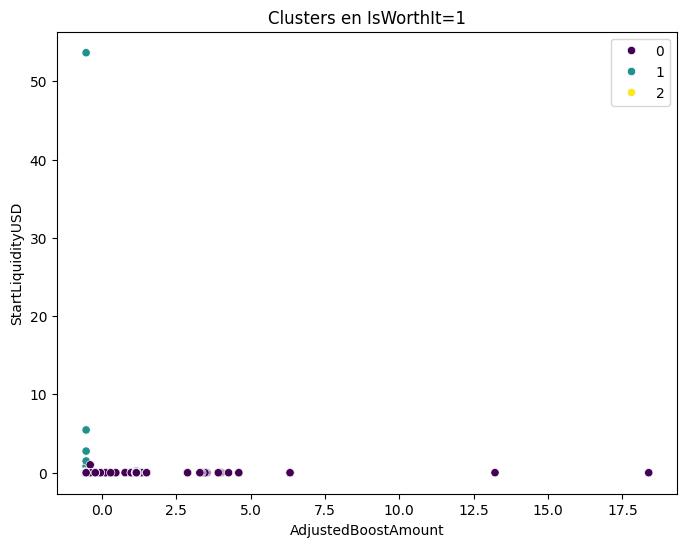

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 🚀 1. Filtrar solo los datos rentables
df_worthit = df_numeric[df_numeric['IsWorthIt'] == 1].copy()

# 🚀 2. Seleccionar variables para clustering (excluyendo variables binarias y categóricas)
features = [
    'AdjustedBoostAmount', 'StartLiquidityUSD', 'StartMktCap', 
    'TokenAge (mins)', 'TotalScore', 'IsPump', 'NumberOfSocials'
]

X = df_worthit[features]

# 🚀 3. Normalizar los datos para evitar sesgos en clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🚀 4. Aplicar K-Means con 3 clusters (ajustable)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_worthit['Cluster'] = kmeans.fit_predict(X_scaled)

# 🚀 5. Visualizar la distribución de los clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=df_worthit['Cluster'], palette='viridis')
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title('Clusters en IsWorthIt=1')
plt.legend()
plt.show()



# 🚀 6. Analizar características de cada cluster
cluster_summary = df_worthit.groupby("Cluster")[features].mean()

### *5.2.4. PCA*

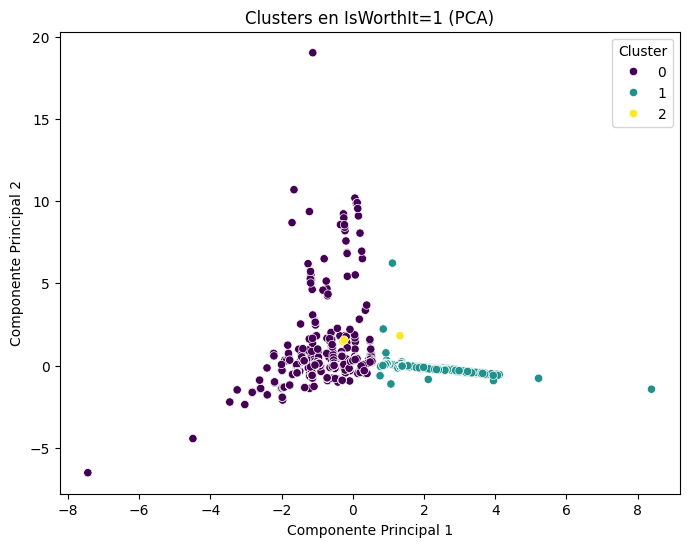

ValueError: cannot reindex on an axis with duplicate labels

In [55]:
from sklearn.decomposition import PCA

# 🚀 1. Reducir las dimensiones a 2 con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 🚀 2. Visualizar los clusters en el espacio reducido
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_worthit['Cluster'], palette='viridis')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters en IsWorthIt=1 (PCA)')
plt.legend(title="Cluster")
plt.show()

# 🚀 Seleccionar algunas variables importantes para visualización
selected_features = ['AdjustedBoostAmount', 'StartLiquidityUSD', 'TokenAge (mins)', 'TotalScore']

# 🚀 Crear un DataFrame con las variables y los clusters
visualization_data = pd.DataFrame(X_scaled, columns=features)
visualization_data['Cluster'] = df_worthit['Cluster']

# 🚀 Graficar pares de variables
sns.pairplot(visualization_data, vars=selected_features, hue='Cluster', palette='viridis', diag_kind='kde')
plt.suptitle("Relación entre variables y clusters", y=1.02)
plt.show()

# 🚀 Calcular estadísticas promedio por cluster
cluster_summary = df_worthit.groupby("Cluster")[features].mean()




In [ ]:
cluster_summary = df_worthit.groupby("Cluster")[features].mean()
print(cluster_summary)

         AdjustedBoostAmount  StartLiquidityUSD   StartMktCap  \
Cluster                                                         
0                  17.903226      608329.032258  3.605570e+09   
1                  32.852113       50904.985915  2.834316e+05   
2                  10.000000       90066.000000  1.087387e+06   
3                 120.277778       38052.365741  5.123031e+06   
4                 570.983607       65646.863388  3.643822e+05   
5                  29.375000      180395.625000  2.518006e+06   

         TokenAge (mins)    TotalScore    IsPump  NumberOfSocials  
Cluster                                                            
0             169.612903  6.335097e+03  0.032258         0.435484  
1            4311.355634  6.756954e+02  1.000000         2.209507  
2              43.000000  3.354928e+06  0.000000         2.000000  
3            2212.680556  2.379250e+03  0.000000         2.282407  
4             677.065574  6.742514e+02  0.972678         2.628415  
5  

## 5.3. Método 2. Regresión Logística

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# ------------------ 1️⃣ Preprocesamiento ------------------
# Convertir booleanos a enteros
df_numeric['IsPump'] = df_numeric['IsPump'].astype(int)

# Definir columnas numéricas y binarias
numeric_cols = [
    'AdjustedBoostAmount', 'TokenAge (mins)', 'NumberOfSocials', 
    'StartMktCap', 'StartLiquidityUSD', 
]

binary_cols = [
    'IsPump', 'Low amount of LP Providers', 'Low Liquidity'
]

# Seleccionar variables
X = df_numeric[numeric_cols + binary_cols]
y = df_numeric['IsWorthIt']

# Escalar variables numéricas
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# ------------------ 2️⃣ Entrenar Regresión Logística ------------------
logit_model = sm.Logit(y, sm.add_constant(X))  # Agregar constante para el intercepto
result = logit_model.fit()

# Mostrar coeficientes y significancia
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.612926
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              IsWorthIt   No. Observations:                 5255
Model:                          Logit   Df Residuals:                     5246
Method:                           MLE   Df Model:                            8
Date:                Sun, 09 Feb 2025   Pseudo R-squ.:                 0.03015
Time:                        15:00:36   Log-Likelihood:                -3220.9
converged:                       True   LL-Null:                       -3321.1
Covariance Type:            nonrobust   LLR p-value:                 5.617e-39
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -2.0642      0.245     -8.426      0.000      

C:\Users\Laú\AppData\Local\Temp\ipykernel_16660\1545274210.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_cols] = scaler.fit_transform(X[numeric_cols])


# *6. Distribuciones*

### *Variables continuas*

In [ ]:
df_under_120_mins = df_numeric[df_numeric['TokenAge (mins)'] <= 120]
df_under_120_mins

,TokenMint,BoostID,AdjustedBoostAmount,TokenAge (mins),TimeBoost,IsPump,NumberOfSocials,StartMktCap,StartLiquidityUSD,IsWorthIt,...,High ownership,Low Liquidity,High holder concentration,High transfer fee,Fee config enabled,LP Unlock in,Mint Authority still enabled,Missing file metadata,Liquidity_to_MarketCap,Boost_to_MarketCap
1,12SDbC7Qfkm6PRf2suETXAH2AggSKr3mRNajXJq5ZqA4,1,10,6.81666660,2025-01-08 11:08:26,False,1,5756226821,674543,0,...,0,0,0,0.00000000,0,0,0,0,0.00011718,0.00000000
11,12cnjtR7NYM8sK1UCbUyGhfHMBVfjebonFAu15sXpump,1,10,5.53333330,2025-01-06 05:04:05,True,0,68365,31109,1,...,0,0,0,0.00000000,0,0,0,0,0.45504279,0.00014627
12,12yueGxB5ebAHhkQ1HWNuCDLgCXVnDcsxwV5JGSrbDEE,1,30,8.96666622,2025-01-06 14:48:54,False,3,19081,7147,0,...,0,0,0,0.00000000,0,0,0,0,0.37456108,0.00157224
13,12ziu9W2RrqA5mPXS8sHQYubZeUmn3BWXCfKgCJvpump,1,10,22.85000038,2025-01-07 19:58:31,True,4,35283,22035,1,...,0,0,0,0.00000000,0,0,0,0,0.62452172,0.00028342
14,138WGQyf9mtYmzjEmNPut3zJRhEf5MBWuWrdwNYbpump,1,10,13.35000038,2025-01-06 14:54:40,True,4,89652,36056,1,...,0,0,0,0.00000000,0,0,0,0,0.40217731,0.00011154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1866,ypDxWR16qi4xjtxmoQrgXNrF693BBZPAoNRUqbQaTMn,1,10,7.40000010,2025-02-07 06:35:25,False,1,5297332578,640362,1,...,0,0,0,NaN,0,0,0,0,0.00012088,0.00000000
1867,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,1,500,6.31666660,2025-02-03 19:49:55,True,3,255242,59419,1,...,0,0,0,NaN,0,0,0,0,0.23279476,0.00195893
1868,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,2,100,8.98333359,2025-02-03 19:52:35,True,3,356358,70448,0,...,0,0,0,NaN,0,0,0,0,0.19768884,0.00028062
1869,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,3,500,25.14999962,2025-02-03 20:08:45,True,3,333319,68788,0,...,0,0,0,NaN,0,0,0,0,0.20637287,0.00150006


In [ ]:
# Filtrar datos según IsWorthIt
df_worthit = df_under_120_mins[df_under_120_mins["IsWorthIt"] == 1]
df_not_worthit = df_under_120_mins[df_under_120_mins["IsWorthIt"] == 0]
len(df_worthit)

1249

In [ ]:
def plot_distribution(df, column, upper_limit=None, bins=50):
    """
    Genera un gráfico de distribución comparando IsWorthIt=1 vs IsWorthIt=0.
    
    Args:
    - df (DataFrame): Dataset con IsWorthIt.
    - column (str): Nombre de la columna a graficar.
    - upper_limit (float, optional): Límite superior para filtrar valores extremos.
    - bins (int, optional): Número de bins en el histograma.
    
    Returns:
    - Gráfico de distribución.
    """
    plt.figure(figsize=(8, 4))
    
    # Filtrar valores extremos si se proporciona un límite
    if upper_limit:
        df_filtered = df[df[column] <= upper_limit]
    else:
        df_filtered = df

    # Graficar distribuciones para IsWorthIt=1 y IsWorthIt=0
    sns.histplot(df_filtered[df_filtered["IsWorthIt"] == 1][column], color="green", label="IsWorthIt=1", kde=True, bins=bins, alpha=0.5)
    sns.histplot(df_filtered[df_filtered["IsWorthIt"] == 0][column], color="red", label="IsWorthIt=0", kde=True, bins=bins, alpha=0.5)
    
    # Configuración del gráfico
    plt.title(f"Distribución de {column} entre IsWorthIt=1 y 0", fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Frecuencia", fontsize=12)
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


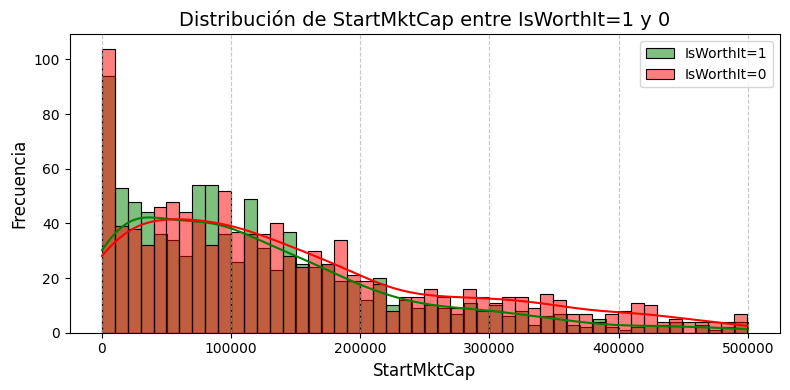

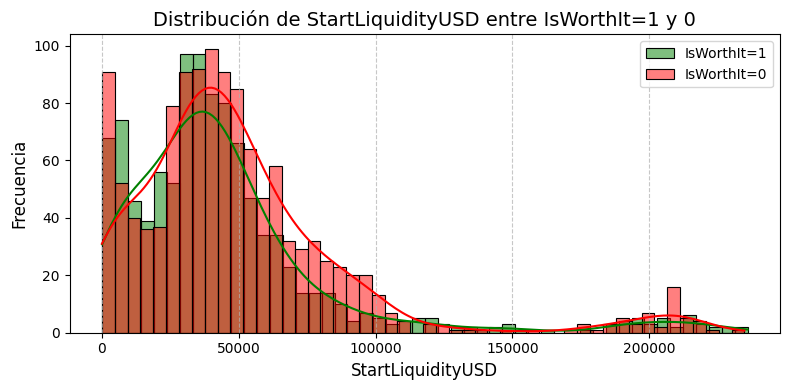

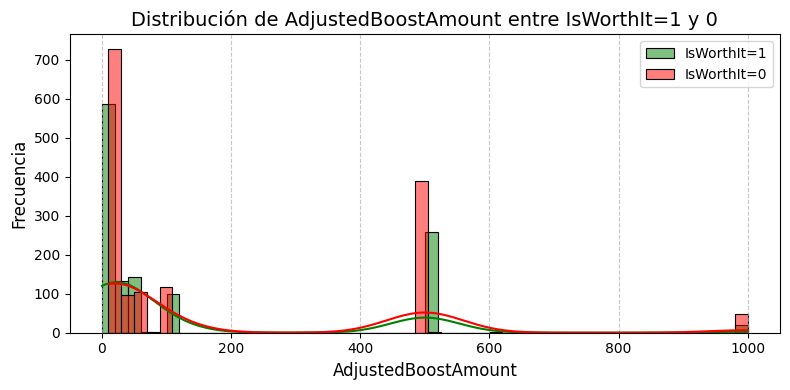

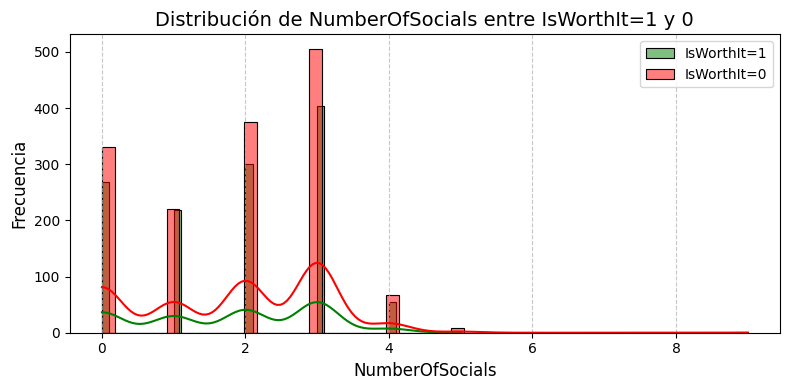

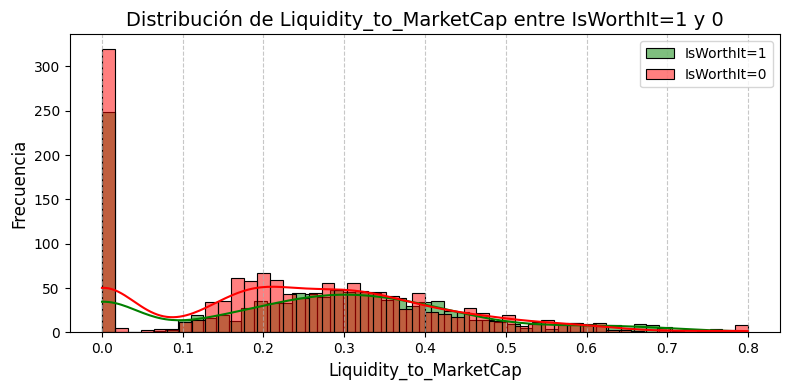

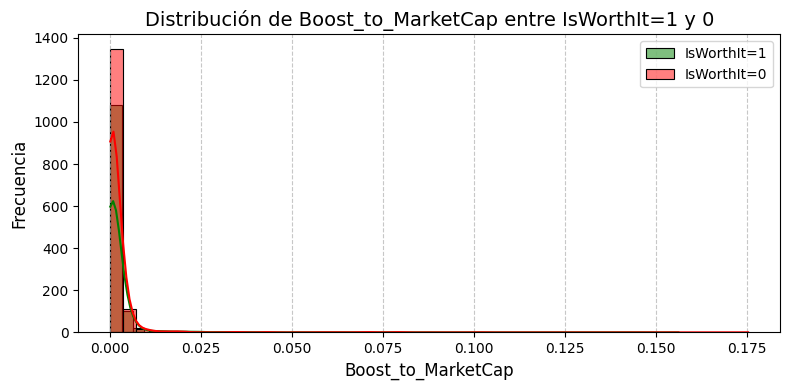

In [ ]:
df_boost = df_under_120_mins.copy()

# StartMarketCap - Filtramos valores extremos por encima de 500,000
plot_distribution(df_boost, "StartMktCap", upper_limit=500000)

# StartLiquidityUSD - Filtramos valores extremos por encima de 100,000
plot_distribution(df_boost, "StartLiquidityUSD", upper_limit=250000)

# AdjustedBoostAmount - Filtramos valores extremos por encima de 100
plot_distribution(df_boost, "AdjustedBoostAmount", upper_limit=1000)

# NumberOfSocials - Filtramos valores extremos por encima de 20
plot_distribution(df_boost, "NumberOfSocials", upper_limit=10)

# Liquidity-to-MarketCap Ratio
df_boost["Liquidity_to_MarketCap"] = df_boost["StartLiquidityUSD"] / df_boost["StartMktCap"]
plot_distribution(df_boost, "Liquidity_to_MarketCap", upper_limit=0.8)

# Boost-to-MarketCap Ratio
df_boost["Boost_to_MarketCap"] = df_boost["AdjustedBoostAmount"] / df_boost["StartMktCap"]
plot_distribution(df_boost, "Boost_to_MarketCap", upper_limit=0.20)


# 7. Simulaciones

In [ ]:
final_df_opt = final_df.copy()

,TokenMint,BoostID,AdjustedBoostAmount,TokenAge (mins),TimeBoost,IsPump,NumberOfSocials,StartMktCap,StartLiquidityUSD,IsWorthIt,...,Large Amount of LP Unlocked,Top 10 holders high ownership,Single holder ownership,High ownership,Low Liquidity,High holder concentration,Fee config enabled,LP Unlock in,Mint Authority still enabled,Missing file metadata
0,127LNZfN3PbnkRfPdNgSdAFHW2duWZ6nXfQHnCjopump,1,10,10080.18359375,2025-01-06 03:28:55,True,3,7236,11160,0,...,0,0,0,0,0,0,0,0,0,0
1,12SDbC7Qfkm6PRf2suETXAH2AggSKr3mRNajXJq5ZqA4,1,10,6.81666660,2025-01-08 11:08:26,False,1,5756226821,674543,0,...,0,0,0,0,0,0,0,0,0,0
2,12XbSPVc5hmWjKUzf5ExTysM2pEL3tM953YkMXmLWkGd,1,500,16842.71679688,2025-01-04 16:52:38,False,1,13339577,363352,0,...,0,0,0,0,0,0,0,0,0,0
3,12XbSPVc5hmWjKUzf5ExTysM2pEL3tM953YkMXmLWkGd,2,500,16864.51757812,2025-01-04 17:14:26,False,1,15814193,396267,0,...,0,0,0,0,0,0,0,0,0,0
4,12XbSPVc5hmWjKUzf5ExTysM2pEL3tM953YkMXmLWkGd,3,500,16865.05078125,2025-01-04 17:14:58,False,1,15727364,395178,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,1,500,6.31666660,2025-02-03 19:49:55,True,3,255242,59419,1,...,0,0,0,0,0,0,0,0,0,0
1868,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,2,100,8.98333359,2025-02-03 19:52:35,True,3,356358,70448,0,...,0,0,0,0,0,0,0,0,0,0
1869,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,3,500,25.14999962,2025-02-03 20:08:45,True,3,333319,68788,0,...,0,0,0,0,0,0,0,0,0,0
1870,zD8qcysrwAEF5YA4Afm1DupbcusUaK9HEq8egX2pump,4,100,27.28333282,2025-02-03 20:10:53,True,3,370335,72566,1,...,0,0,0,0,0,0,0,0,0,0


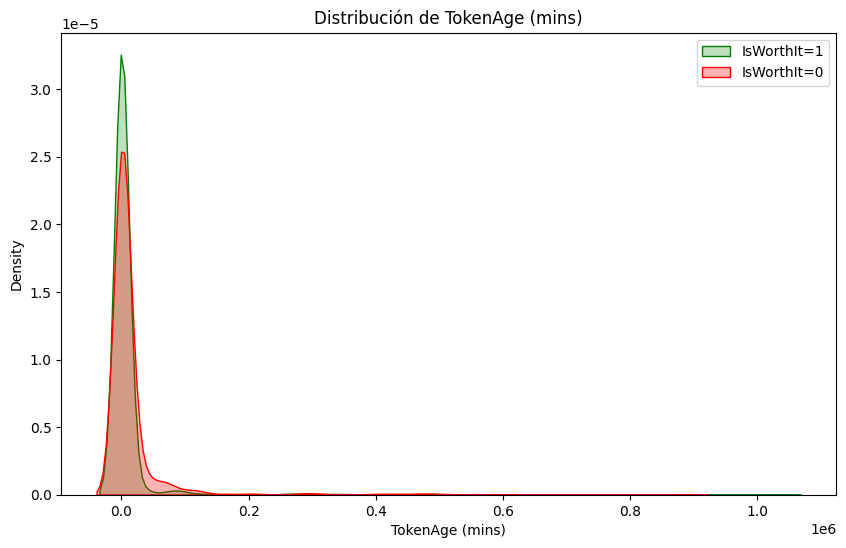

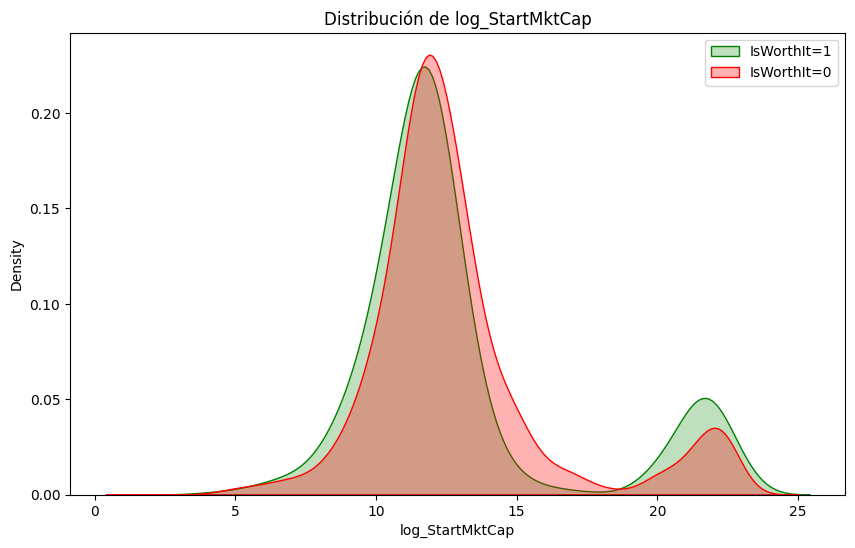

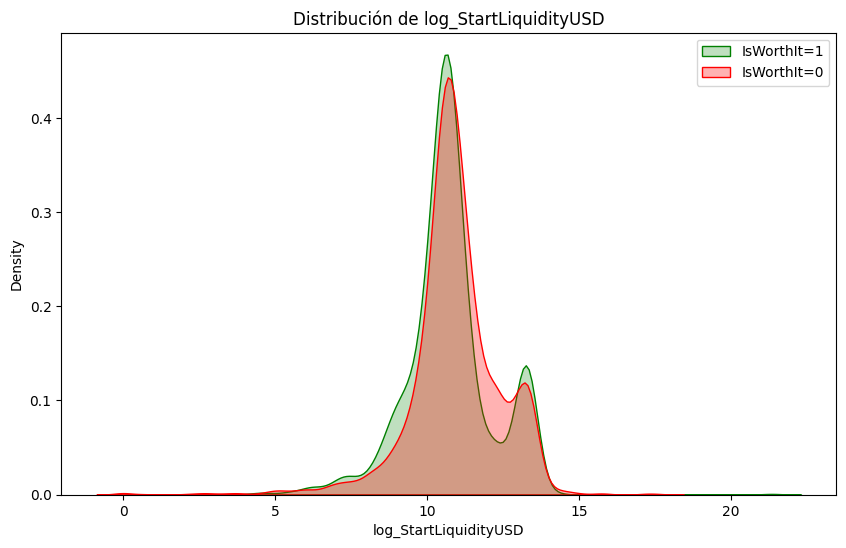

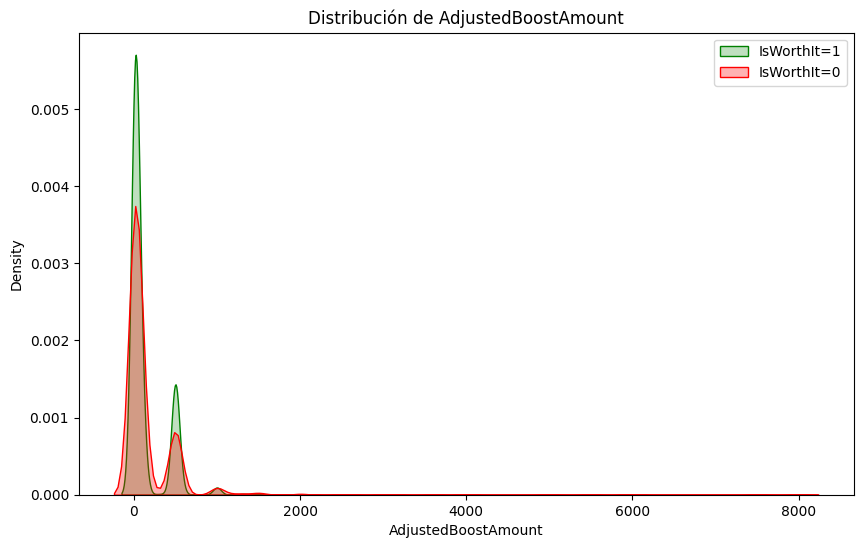

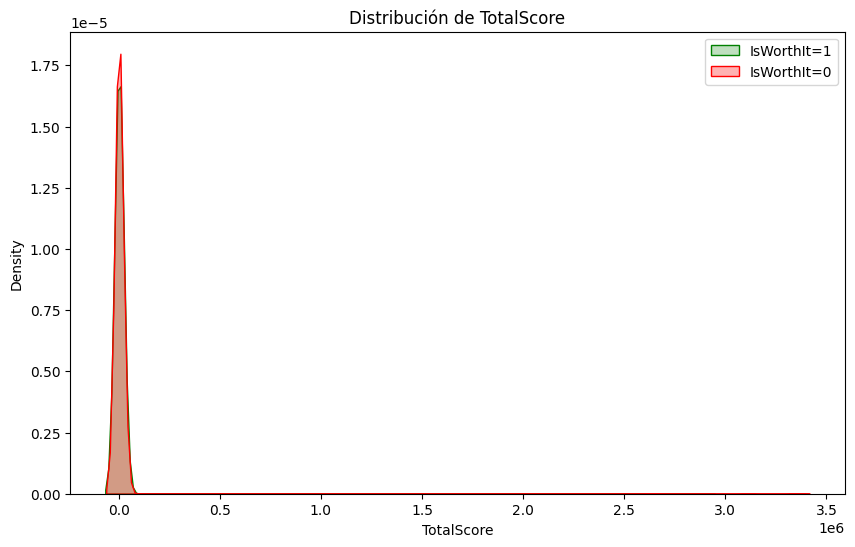

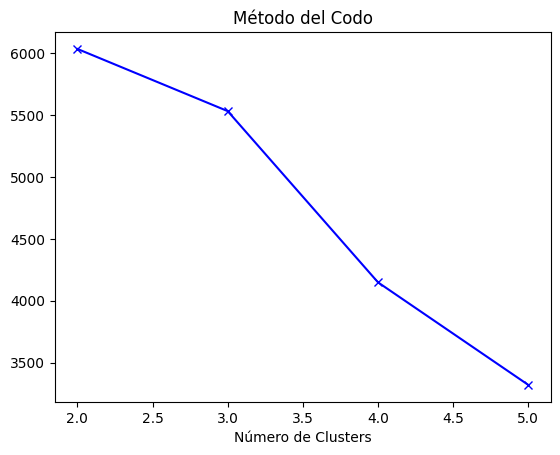

Rangos por cluster:

Cluster 0 (Size: 1436)
TokenAge (mins): [14.10, 189.50]
log_StartMktCap: [10.59, 12.27]
log_StartLiquidityUSD: [9.93, 10.88]
AdjustedBoostAmount: [10.00, 100.00]
TotalScore: [400.00, 500.00]

Cluster 1 (Size: 266)
TokenAge (mins): [6.17, 10.48]
log_StartMktCap: [20.95, 21.94]
log_StartLiquidityUSD: [12.94, 13.37]
AdjustedBoostAmount: [10.00, 10.00]
TotalScore: [400.00, 11499.75]

Cluster 2 (Size: 16)
TokenAge (mins): [3593.74, 34453.54]
log_StartMktCap: [12.72, 15.38]
log_StartLiquidityUSD: [11.42, 12.89]
AdjustedBoostAmount: [10.00, 175.00]
TotalScore: [0.00, 0.00]

Rangos óptimos KDE:
TokenAge (mins): [2.86, 19372.92]
log_StartMktCap: [8.49, 23.88]
log_StartLiquidityUSD: [8.33, 13.35]
AdjustedBoostAmount: [6.12, 1468.78]
TotalScore: [138.18, 18469.19]

Métricas Finales:
Entrenamiento - Precisión: 36.26%, Recall: 222.39%
Prueba - Precisión: 33.75%, Recall: 240.49%

Tokens que pasan los filtros óptimos: 3910/5255


c:\Python\my_projects\dexboost\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split

# 1. Carga y preparación de datos
def prepare_data(df):
    # Convertir a escalas logarítmicas donde sea necesario
    skewed_features = ['StartMktCap', 'StartLiquidityUSD']
    for feat in skewed_features:
        df[f'log_{feat}'] = np.log1p(df[feat])
    
    # Definir features finales
    features = [
        'TokenAge (mins)',
        'log_StartMktCap',
        'log_StartLiquidityUSD',
        'AdjustedBoostAmount',
        'TotalScore'
    ]
    
    # Separar datasets
    df_pos = df[df['IsWorthIt'] == 1].copy()
    df_neg = df[df['IsWorthIt'] == 0].copy()
    
    return df_pos, df_neg, features

# 2. Análisis comparativo visual
def comparative_visualization(df_pos, df_neg, features):
    for feature in features:
        plt.figure(figsize=(10, 6))
        
        # KDE Plot
        sns.kdeplot(df_pos[feature], label='IsWorthIt=1', color='green', fill=True)
        sns.kdeplot(df_neg[feature], label='IsWorthIt=0', color='red', fill=True, alpha=0.3)
        
        plt.title(f'Distribución de {feature}')
        plt.legend()
        plt.show()

# 3. Clustering de casos positivos
def cluster_positive_cases(df_pos, features):
    # Escalado robusto
    scaler = PowerTransformer()
    X = scaler.fit_transform(df_pos[features])
    
    # Determinación óptima de clusters
    distortions = []
    K_range = range(2, 6)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)
    
    plt.plot(K_range, distortions, 'bx-')
    plt.xlabel('Número de Clusters')
    plt.title('Método del Codo')
    plt.show()
    
    # Selección manual basada en gráfico (ajustar según resultado)
    optimal_clusters = 3
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    df_pos['Cluster'] = kmeans.fit_predict(X)
    
    return df_pos, scaler

# 4. Análisis de clusters
def analyze_clusters(df_pos, features):
    cluster_ranges = {}
    
    for cluster in sorted(df_pos['Cluster'].unique()):
        cluster_data = df_pos[df_pos['Cluster'] == cluster]
        
        ranges = {}
        for feature in features:
            q25 = cluster_data[feature].quantile(0.25)
            q75 = cluster_data[feature].quantile(0.75)
            ranges[feature] = (q25, q75)
        
        cluster_ranges[cluster] = {
            'size': len(cluster_data),
            'ranges': ranges
        }
    
    return cluster_ranges

# 5. Optimización de rangos con KDE
def optimize_ranges_with_kde(df_pos, features, scaler):
    # Transformar datos
    X = scaler.transform(df_pos[features])
    
    # Ajustar KDE
    kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
    kde.fit(X)
    
    # Generar muestras sintéticas óptimas
    samples = kde.sample(1000)
    synthetic_data = scaler.inverse_transform(samples)
    
    # Crear DataFrame con muestras
    df_synthetic = pd.DataFrame(synthetic_data, columns=features)
    
    # Calcular rangos óptimos
    optimal_ranges = {}
    for feature in features:
        q5 = df_synthetic[feature].quantile(0.05)
        q95 = df_synthetic[feature].quantile(0.95)
        optimal_ranges[feature] = (q5, q95)
    
    return optimal_ranges

# 6. Validación de resultados
def validate_ranges(df, optimal_ranges):
    # Convertir rangos a features originales
    ranges = {}
    for feature in optimal_ranges:
        if 'log_' in feature:
            original_feat = feature.replace('log_', '')
            min_val = np.expm1(optimal_ranges[feature][0])
            max_val = np.expm1(optimal_ranges[feature][1])
            ranges[original_feat] = (min_val, max_val)
        else:
            ranges[feature] = optimal_ranges[feature]
    
    # Aplicar filtros
    filtered = df.copy()
    for feature, (min_val, max_val) in ranges.items():
        filtered = filtered[(filtered[feature] >= min_val) & (filtered[feature] <= max_val)]
    
    # Calcular métricas
    if len(filtered) == 0:
        return 0.0, 0.0
    
    precision = filtered['IsWorthIt'].mean()
    recall = len(filtered) / len(df[df['IsWorthIt'] == 1])
    
    return precision, recall

# Flujo principal
def main_workflow(df):
    # 1. Preparación de datos
    df_pos, df_neg, features = prepare_data(df)
    
    # 2. Análisis visual comparativo
    comparative_visualization(df_pos, df_neg, features)
    
    # 3. Clustering de casos positivos
    df_pos_clustered, scaler = cluster_positive_cases(df_pos, features)
    
    # 4. Análisis de clusters
    cluster_ranges = analyze_clusters(df_pos_clustered, features)
    print("Rangos por cluster:")
    for cluster, data in cluster_ranges.items():
        print(f"\nCluster {cluster} (Size: {data['size']})")
        for feat, (q25, q75) in data['ranges'].items():
            print(f"{feat}: [{q25:.2f}, {q75:.2f}]")
    
    # 5. Optimización con KDE
    optimal_ranges = optimize_ranges_with_kde(df_pos_clustered, features, scaler)
    print("\nRangos óptimos KDE:")
    for feat, (q5, q95) in optimal_ranges.items():
        print(f"{feat}: [{q5:.2f}, {q95:.2f}]")
    
    # 6. Validación final
    train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
    train_precision, train_recall = validate_ranges(train_df, optimal_ranges)
    test_precision, test_recall = validate_ranges(test_df, optimal_ranges)
    
    print("\nMétricas Finales:")
    print(f"Entrenamiento - Precisión: {train_precision:.2%}, Recall: {train_recall:.2%}")
    print(f"Prueba - Precisión: {test_precision:.2%}, Recall: {test_recall:.2%}")
    
    return optimal_ranges

# Ejecutar el flujo completo
optimal_ranges = main_workflow(final_df_opt)

# Función para aplicar los filtros
def apply_optimal_filters(df, optimal_ranges):
    filtered = df.copy()
    for feature, (min_val, max_val) in optimal_ranges.items():
        # Convertir features logarítmicas
        if 'log_' in feature:
            original_feat = feature.replace('log_', '')
            filtered = filtered[
                (filtered[original_feat] >= np.expm1(min_val)) & 
                (filtered[original_feat] <= np.expm1(max_val))
            ]
        else:
            filtered = filtered[(filtered[feature] >= min_val) & (filtered[feature] <= max_val)]
    return filtered

# Ejemplo de uso
final_filtered_df = apply_optimal_filters(final_df_opt, optimal_ranges)
print(f"\nTokens que pasan los filtros óptimos: {len(final_filtered_df)}/{len(final_df_opt)}")

In [ ]:
df_comprobar = final_df_opt[
    (final_df_opt["TokenAge (mins)"] >= 30) & (final_df_opt["TokenAge (mins)"] <= 87) &
    (final_df_opt["StartLiquidityUSD"] >= 75165) & (final_df_opt["StartLiquidityUSD"] <= 174309) &
    (final_df_opt["StartMktCap"] >= 31184) & (final_df_opt["StartMktCap"] <= 414983) &
    (final_df_opt["AdjustedBoostAmount"] >= 276) & (final_df_opt["AdjustedBoostAmount"] <= 794) &
    (final_df_opt["TotalScore"] >= 418) & (final_df_opt["TotalScore"] <= 2897)
]

# Calcular la proporción de IsWorthIt = 1 en la data filtrada
proporcion_isworthit = df_comprobar["IsWorthIt"].mean()

# Mostrar resultados
len(df_comprobar), proporcion_isworthit


(1, np.float64(1.0))